# Demonstration of the iterative update in 2D

Exploration of an iterative solver scheme to solve the following three main blocs:
1. Source parameters
2. Attitude
3. Calibration parameters

The source parameters correspond to the _true_ values characterising each source (_What makes it a Global solution?_).

The attitude relates to the satellite telemetry: its pointing direction and orientation, as well as the focal distance.

The calibrations has to take care of everything else: distortions, translations, colour dependencies, etc.

This notebook demonstrates an optimization procedure for a simplistic 2D case where only positions are infered. In other words, stars do not move (relative to the Earth).

We use `jax` to make the best use of the _auto-differentiation_ technique.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as units
import scipy.stats
import pandas as pd
jax.config.update('jax_enable_x64', True)
np.random.seed(42)

In [2]:
from astropy.coordinates import SkyCoord,ICRS,Galactic,HeliocentricTrueEcliptic,GeocentricMeanEcliptic
import astropy.units as units

In [3]:
_astronomicalunit_to_meters = units.astronomical_unit.to(units.meter)
_radiants_to_mas = units.radian.to(units.mas)

## Simplest Model

The observation model is defined here.

##### Epoch Position

Each star has astrometric parameters $(\alpha_{0},\delta_{0})$, which correspond to the position in ICRS coordiantes at the catalog epoch. The catalog epoch is set $t=0$. The observed position of a star at the observation epoch, $\alpha_{i}(t),\delta_{i}(t)$, is given by the following expression.

$$
  \alpha_{i}(t) = \alpha_{0,i}
$$
$$
  \delta{i}(t) = \delta_{0,i}
$$

In [115]:
def longitude(t):
  ''' Longitude of the Earth

  Arguments:
      t: epoch of the observation [years]

  Returns:
    The longitude of the Earth in radian.
  '''
  return 2 * jnp.pi * t

def get_p0(alpha0,delta0):
    """
    First vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(alpha0),jnp.cos(alpha0),0])

def get_q0(alpha0,delta0):
    """
    Second vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(delta0)*jnp.cos(alpha0),jnp.sin(delta0)*jnp.sin(alpha0),jnp.cos(delta0)])

def get_barycentric_position_satellite(time):
    return jnp.array([jnp.sin(longitude(time)),jnp.cos(longitude(time)),0])

def get_parallax_factor_vectorial(vec,bary):
    A = _astronomicalunit_to_meters
    return -jnp.dot(vec,bary)/A

def get_parallax_factor_alpha(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(alpha0)*jnp.cos(L) - jnp.cos(alpha0)*jnp.sin(L)

def get_parallax_factor_delta(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(delta0)*jnp.cos(alpha0)*jnp.cos(L) - jnp.sin(delta0)*jnp.sin(alpha0)*jnp.sin(L)

def get_alpha_t(time,alpha0):
    """
    Predicted location of the right ascension of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - alpha0: in radians
    """
    return alpha0*_radiants_to_mas

def get_delta_t(time,delta0):
    """
    Predicted location of the declination of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - delta0: in radians
    """
    return delta0*_radiants_to_mas

def celestial_model(angle,pm,parallax,parallax_factor,t):
    """
    Celestial model describing the motion on the Celestial sphere of a star.
    1D
    """
    return angle + pm * t + parallax * parallax_factor

In [116]:
t = np.linspace(0,3,1000)
a0 = 0
d0 = np.pi/4

a = get_alpha_t(t,a0)
d = get_delta_t(t,d0)

In [ ]:
#this is a comment

In [117]:
def epoch_position(s, t):
    ''' Celestial position of a source
    
    Arguments:
      s: source parameters
        s[0]: right ascention
        s[1]: declination
    
    Returns:
    The celestial position of the source at the observation epoch.
    '''
    return s[0], s[1]

In [118]:
def position_ideal_plane_eta(s, e, t):
    ''' Position eta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    alpha = get_alpha_t(t,s[0])/_radiants_to_mas
    eta = alpha - e[0]
    return eta

def position_ideal_plane_zeta(s, e, t):
    ''' Position zeta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    delta = get_delta_t(t,s[1])/_radiants_to_mas
    zeta = delta - e[1]
    return zeta

In [119]:
def position_focal_plane(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta,zeta = position_ideal_plane(s, e, t)
    
    return eta,zeta

def position_focal_plane_eta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta = position_ideal_plane_eta(s, e, t)
    
    return eta

def position_focal_plane_zeta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    zeta = position_ideal_plane_zeta(s, e, t)
    
    return zeta


eta = jax.jit(lambda s,e,t: position_focal_plane_eta(s,e,t))
zeta = jax.jit(lambda s,e,t: position_focal_plane_zeta(s,e,t))

### Generate simulation (NO SCALING NO DEFORMATIONS)

We set up the simulation. We prepare 200 artificial sources. The astrometric parameters are randomly sampled. The observations are scheduled from $t=-10$ to $10$ with equal intervals. The number of observations is 501. The telescope pointing directions are randomly sampled. 

`src` and `exp` contain the ground truth of the parameters. `src` contains the source astrometric parameters with `source_id`. `exp` contains the exposure parameters with `exposure_id`.

In [120]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)
pt_dec = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

The initial estimates of the parameters are prepared. We assume that the source and exposure parameters can be estimated with uncertainties of 5%. We set the initial estimates of the calibration paramters to zeros.

In [121]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

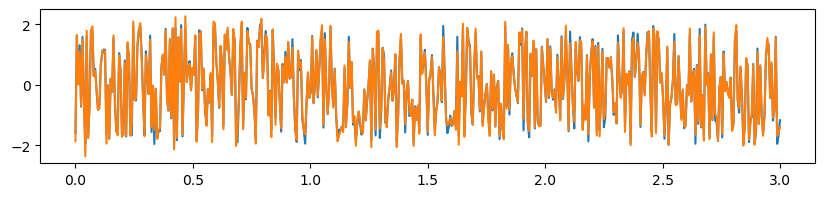

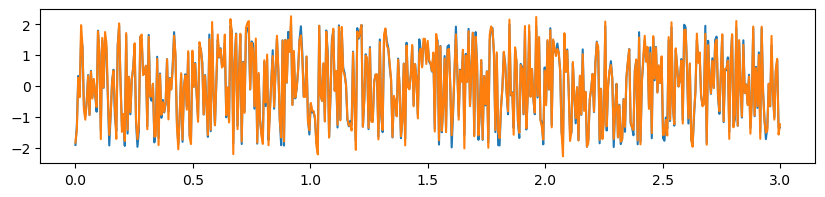

In [122]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])

plt.figure(figsize=(10,2))
plt.plot(ep,pt_dec)
plt.plot(ep,ehat[:,3]);

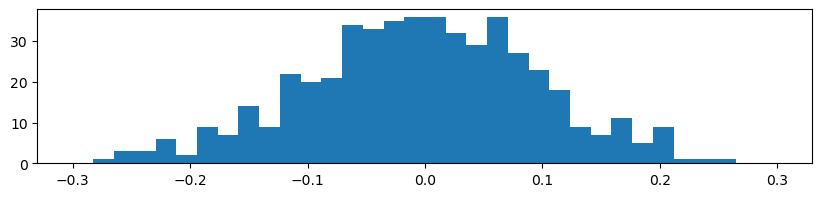

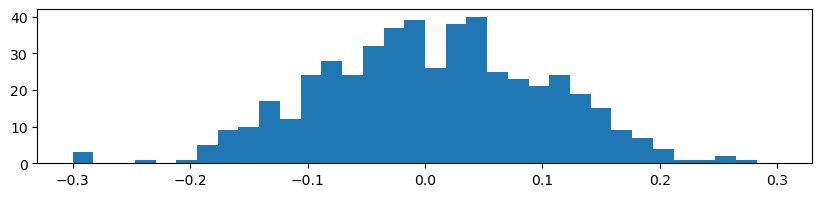

In [11]:
plt.figure(figsize=(10,2))
plt.hist((ehat[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,35))

plt.figure(figsize=(10,2))
plt.hist((ehat[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,35));

### Generate measurements

Predictions of the astrometric model are generated using the function `zeta`. The predictions can be affected by noise if desired, for instance, to generate mock observations. Here, we assume that the measurement error is given by a Gaussian distribution with the standard deviation of $\sigma_\text{obs}$.

$$
  \tilde\zeta_{i}(t) = \mathcal{N}(\zeta_{i}(t), \sigma_\text{obs})
$$

In [123]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [124]:
obs.shape

(200400, 4)

In [125]:
src[0]

Array([ 0.        , -0.25091976,  0.28406329], dtype=float64)

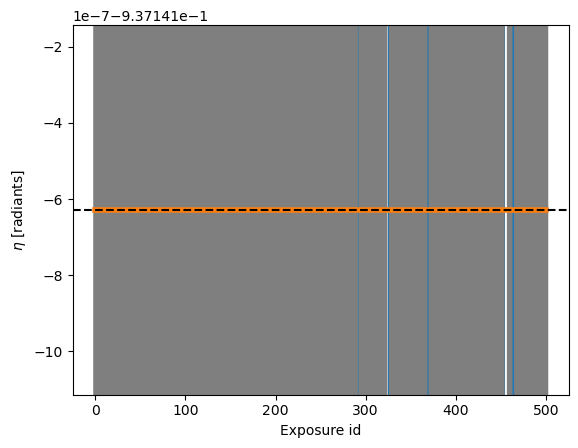

In [126]:
k = 100
plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1])

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + ehat[:,2],lw=4,color="tab:grey")

plt.plot(obs[(obs[:,0]==k)&(obs[:,2]==0)][:,1],
         obs[(obs[:,0]==k)&(obs[:,2]==0)][:,-1] + pt_ra,lw=4,color="tab:orange")

plt.axhline(alpha0[k],ls="--",color="k")
plt.ylim(alpha0[k]-100/_radiants_to_mas,alpha0[k]+100/_radiants_to_mas)
plt.xlabel("Exposure id")
plt.ylabel(r"$\eta$ [radiants]");

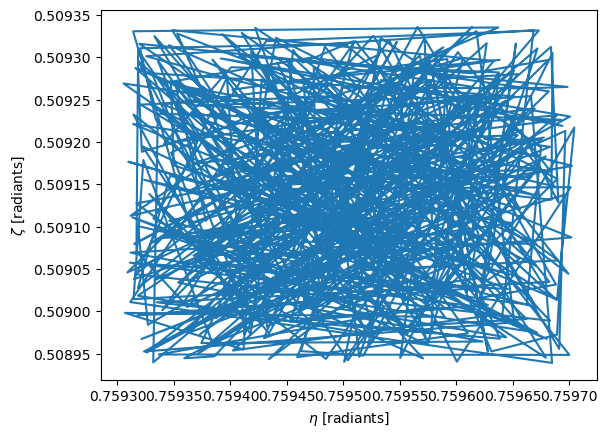

In [29]:
plt.plot(obs[(obs[:,0]==0)&(obs[:,2]==0)][:,-1],obs[(obs[:,0]==0)&(obs[:,2]==1)][:,-1])
plt.ylabel(r"$\zeta$ [radiants]")
plt.xlabel(r"$\eta$ [radiants]");

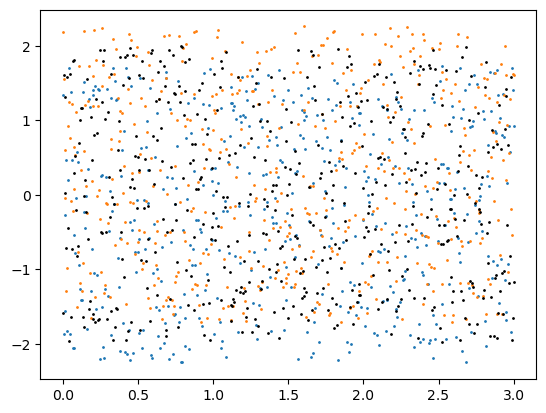

In [16]:
aux = obs[obs[:,0]==0]
plt.scatter(exp[:,1],aux[:exp.shape[0],3],s=1)
plt.scatter(exp[:,1],aux[exp.shape[0]:,3],s=1)
plt.scatter(exp[:,1],exp[:,2],s=1,c="k")

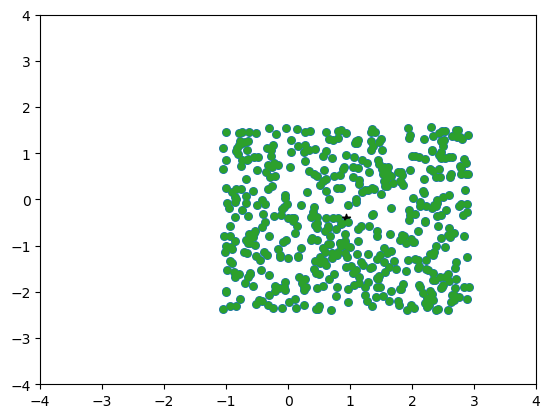

In [17]:
k = 50
aux = obs[obs[:,0]==k]
plt.scatter(aux[:exp.shape[0],3],aux[exp.shape[0]:,3],s=30)
plt.scatter(src[k,1],src[k,2],marker="*",color="k")
plt.scatter(src[k,1]-exp[:,2],src[k,2]-exp[:,3],color="tab:green",s=20)

plt.xlim(-4,4)
plt.ylim(-4,4);

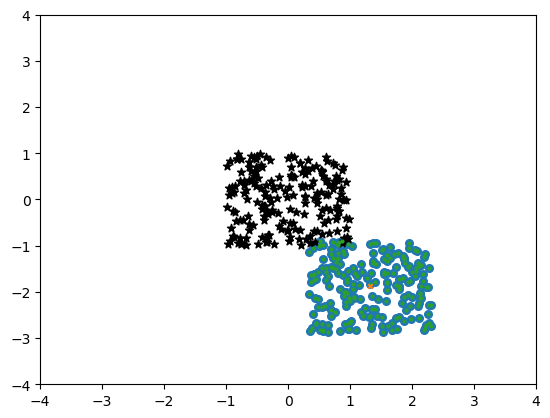

In [18]:
k = 200
aux = obs[obs[:,1]==k]
plt.scatter(aux[:src.shape[0],3],aux[src.shape[0]:,3],s=30)
plt.scatter(src[:,1],src[:,2],marker="*",color="k")
plt.scatter(src[:,1]-exp[k,2],src[:,2]-exp[k,3],color="tab:green",s=4)
plt.scatter(-exp[k,2],-exp[k,3],c="tab:orange",s=10,marker="x")

plt.xlim(-4,4)
plt.ylim(-4,4);

#### Calculate gradients

Gradient functions are obtained via `jax.grad`. Three functions are defined:

- `dzds`: Gradients in terms of the source parameters.
- `dzde`: Gradients in terms of the exposure parameters.
- `dzdc`: Gradients in terms of the calibration parameters.

In [127]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [128]:
aux = jax.grad(zeta, argnums=(0))

### Calculate update

The updates of the parameters are obtained via the gradients. We define three functions:

- `update_source` returns the updated source parameters.
- `update_exposure` returns the updated exposure parameters.
- `update_calibration` returns the updated calibration parameters.

In [129]:
def update_source_inner(src, exp):
    c_eta = _iterate_exp_eta(src[1:],exp[:,2:],exp[:,1])
    o_eta = obs[(obs[:, 0] == src[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_exp_zeta(src[1:],exp[:,2:],exp[:,1])
    o_zeta = obs[(obs[:, 0] == src[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    Ds = np.vstack([deds(src[1:], exp[:, 2:], exp[:, 1]),
                    dzds(src[1:], exp[:, 2:], exp[:, 1])])

    
    
    N = Ds.T @ Ds
    b = Ds.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp) for _ in src])

In [130]:
update_source_inner(shat[0],exp)

Array([-0.25091976,  0.28406329], dtype=float64)

In [131]:
src[0]

Array([ 0.        , -0.25091976,  0.28406329], dtype=float64)

In [132]:
def update_exposure_inner(src, exp):
    c_eta = _iterate_src_eta(src[:,1:], exp[2:],exp[1])
    o_eta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(src[:,1:], exp[2:],exp[1])
    o_zeta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(src[:,1:], exp[2:], exp[1]),
                    dzde(src[:,1:], exp[2:], exp[1])])

    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _) for _ in exp])

In [133]:
update_exposure_inner(src,exp[0])

Array([-1.58750452, -1.89387118], dtype=float64)

In [134]:
exp[0]

Array([ 0.        ,  0.        , -1.58750452, -1.89387118], dtype=float64)

In [27]:
_exp = ehat[0]

In [28]:
for _exp in ehat:
    c_eta = _iterate_src_eta(shat[:,1:], _exp[2:],_exp[1])
    o_eta = obs[(obs[:, 1] == _exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(shat[:,1:], _exp[2:],_exp[1])
    o_zeta = obs[(obs[:, 1] == _exp[0])&(obs[:,2]==1)][:, 3]
    
    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(shat[:,1:], _exp[2:], _exp[1]),
                    dzde(shat[:,1:], _exp[2:], _exp[1])])
    
    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)

    print(b,delta)

[ 55.04397589 -14.15112951] [ 0.27521988 -0.07075565]
[-7.02308182 24.75329102] [-0.03511541  0.12376646]
[ 0.80870014 12.6836846 ] [0.0040435  0.06341842]
[40.05766891  8.92270868] [0.20028834 0.04461354]
[ -7.73185015 -79.37653965] [-0.03865925 -0.3968827 ]
[18.06655989 -3.70071022] [ 0.0903328  -0.01850355]
[13.88177285 26.37238648] [0.06940886 0.13186193]
[80.88551182 24.24242753] [0.40442756 0.12121214]
[-32.99820192   6.68889885] [-0.16499101  0.03344449]
[25.6628407   4.96760222] [0.1283142  0.02483801]
[-11.61427306   0.92344687] [-0.05807137  0.00461723]
[6.34020741 5.487481  ] [0.03170104 0.02743741]
[-24.89105553   7.90922126] [-0.12445528  0.03954611]
[-0.30667587 -5.16604241] [-0.00153338 -0.02583021]
[ 1.22540861e+01 -3.51652966e-03] [ 6.12704307e-02 -1.75826483e-05]
[ -2.74371471 -29.70491525] [-0.01371857 -0.14852458]
[-1.15508068  5.35390544] [-0.0057754   0.02676953]
[ 20.95732532 -12.31678959] [ 0.10478663 -0.06158395]
[14.34800771 54.36713846] [0.07174004 0.27183569

In [29]:
o_eta[0]

Array(0.91753522, dtype=float64)

In [30]:
c_eta[0]

Array(1.15842212, dtype=float64)

In [31]:
shat[0][1] - _exp[2]

Array(1.15842212, dtype=float64)

In [32]:
print(np.sum(o_eta - c_eta),np.sum(o_zeta - c_zeta))

-46.77600705604709 19.399693782072543


In [33]:
b

Array([ 46.77600706, -19.39969378], dtype=float64)

In [34]:
N

array([[200.,   0.],
       [  0., 200.]])

In [35]:
print(-np.mean(o_eta - c_eta),-np.mean(o_zeta - c_zeta))

0.23388003528023546 -0.09699846891036272


In [36]:
delta

Array([ 0.23388004, -0.09699847], dtype=float64)

### Update parameters

We demonstrate the parameter optimization with the AGIS-like approach. First, we visualize the residuals calculated for the initial estimates. The horizontal axes show the ground truth values, and the vertical axes shows the estimated parameters. The bottom panel shows the residuals against the exposure ID. The root-mean-squared residual is denoted in the legend. Since the measurement error is $\sigma_\text{obs} = 0.015$, the RMS residual will be 0.015 when the parameters are successfully converged.

#### Updating attitude first and then source

In [135]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2)))

In [136]:
scipy.stats.describe(ehat2 - ehat1)

DescribeResult(nobs=501, minmax=(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.22044605e-16]), array([0.00000000e+00, 0.00000000e+00, 2.22044605e-16, 2.22044605e-16])), mean=array([0.00000000e+00, 0.00000000e+00, 2.03250036e-18, 1.24533929e-17]), variance=array([0.00000000e+00, 0.00000000e+00, 1.49661233e-34, 2.35940814e-33]), skewness=array([        nan,         nan, 12.81800836,  2.8276895 ]), kurtosis=array([         nan,          nan, 211.36398036,  12.91706261]))

In [137]:
scipy.stats.describe(shat2-shat1)

DescribeResult(nobs=200, minmax=(array([ 0.00000000e+00, -7.77156117e-16, -8.88178420e-16]), array([0.00000000e+00, 8.88178420e-16, 9.99200722e-16])), mean=array([0.00000000e+00, 2.42861287e-18, 1.65145675e-17]), variance=array([0.00000000e+00, 3.67615507e-32, 4.65493142e-32]), skewness=array([       nan, 0.43914869, 0.25521505]), kurtosis=array([       nan, 4.3975929 , 5.25606563]))

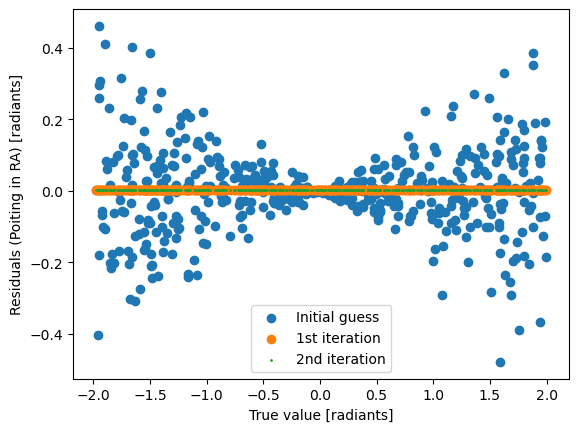

In [138]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

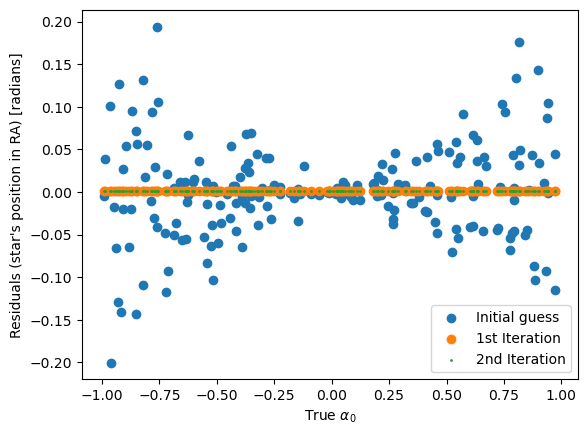

In [139]:
j = 0
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals (star's position in {}) [radians]".format("RA" if j==0 else "DEC"));

In [140]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(0.0010635866830452922, 0.0010635866830455143), mean=0.001063586683045512, variance=1.722327740056451e-34, skewness=-10.843457054935357, kurtosis=159.89840799871706)

In [141]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(0.0010635866830446261, 0.0010635866830462914), mean=0.0010635866830455143, variance=3.7206094113556556e-32, skewness=-0.5306966457871901, kurtosis=4.388177589455172)

In [142]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(0.004930298083698492, 0.004930298083698936), mean=0.004930298083698697, variance=2.4469993186378167e-33, skewness=-2.4494570616374856, kurtosis=10.788708376085347)

In [143]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(0.004930298083697604, 0.0049302980836997135), mean=0.004930298083698693, variance=4.9132021367705834e-32, skewness=-0.1559411641367509, kurtosis=5.853269334785439)

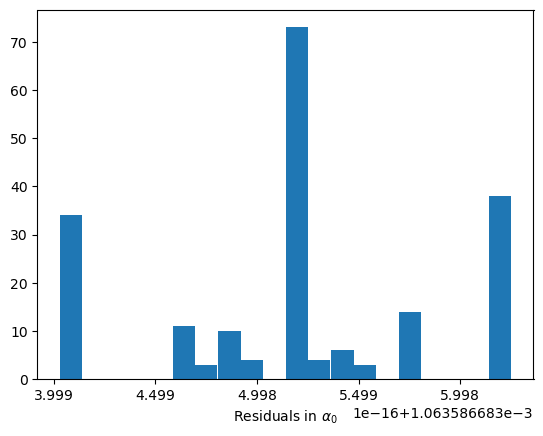

In [45]:
j = 0
#plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
#plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [144]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(0.0010635866830454588, 0.001063586683045516), mean=0.0010635866830455139, variance=2.4476237412369737e-35, skewness=-11.048108993824743, kurtosis=120.13034543594438)

In [145]:
scipy.stats.describe(shat2[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(0.0010635866830454033, 0.0010635866830456253), mean=0.001063586683045517, variance=4.9550014399723574e-33, skewness=-0.02708001430825215, kurtosis=-0.7005762859550266)

In [146]:
scipy.stats.describe(ehat2[:,3]-pt_dec)

DescribeResult(nobs=501, minmax=(0.004930298083698659, 0.004930298083698714), mean=0.004930298083698709, variance=2.030712570424054e-34, skewness=-2.7986050283996198, kurtosis=6.648295428003804)

In [147]:
scipy.stats.describe(shat2[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(0.004930298083698603, 0.004930298083698825), mean=0.004930298083698709, variance=4.405821820721218e-33, skewness=0.06278019775369967, kurtosis=-0.505127330735327)

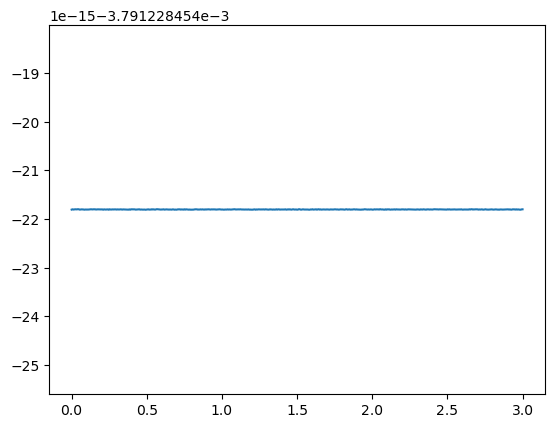

In [52]:
plt.plot(ep,ehat2[:,2]-pt_ra)

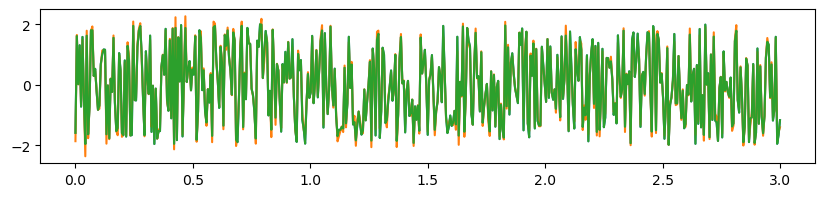

In [47]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])
plt.plot(ep,ehat2[:,2])

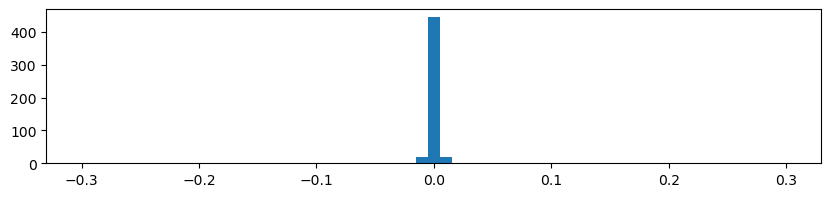

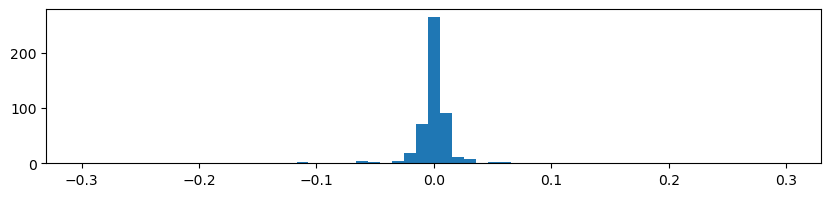

In [48]:
plt.figure(figsize=(10,2))
plt.hist((ehat2[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,60))

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,60));

#### Updating source first and then attitue

In [54]:
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat)))
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat)))

shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat1)))
ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat2,ehat)))

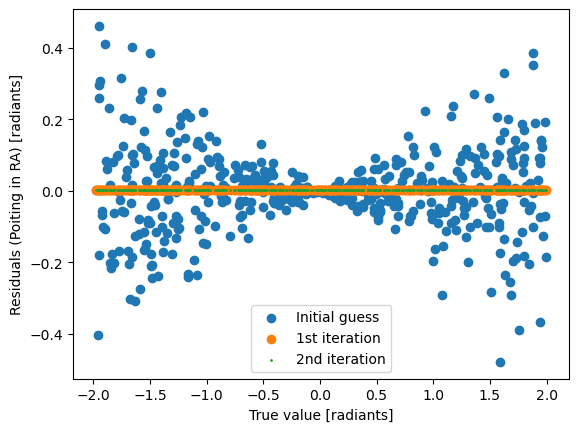

In [55]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

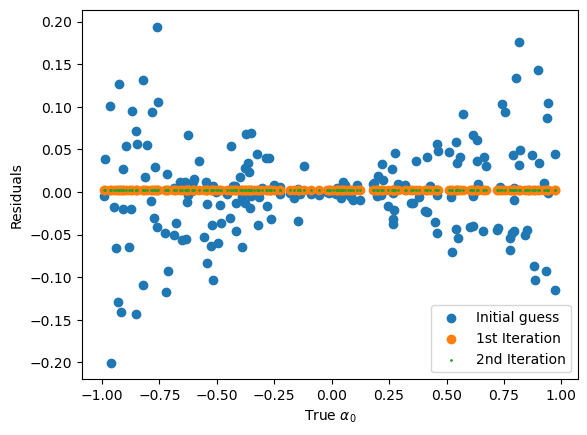

In [56]:
j = 0
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals");

In [57]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(0.0016851731326930075, 0.0016851731326947839), mean=0.0016851731326938155, variance=2.599163319577749e-32, skewness=0.3896960405937842, kurtosis=6.125756823990237)

In [58]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(0.0016851731326935626, 0.0016851731326941177), mean=0.001685173132693808, variance=5.527000062726012e-33, skewness=0.07068097247571038, kurtosis=2.490991375343161)

In [59]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(0.0017374200666739892, 0.0017374200666755435), mean=0.001737420066674649, variance=2.50807594564044e-32, skewness=0.5342067759352748, kurtosis=5.483994356941874)

In [60]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(0.0017374200666743222, 0.0017374200666748774), mean=0.0017374200666746412, variance=5.324014516824662e-33, skewness=-0.4535294705135007, kurtosis=4.292338435613624)

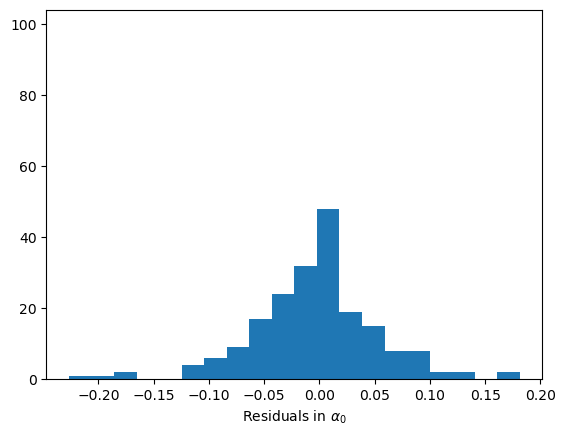

In [60]:
j = 0
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [61]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(8.019547652223964e-07, 8.019547652366367e-07), mean=8.01954765229656e-07, variance=5.508242272307281e-36, skewness=-0.006946938205347898, kurtosis=-0.36114237117720327)

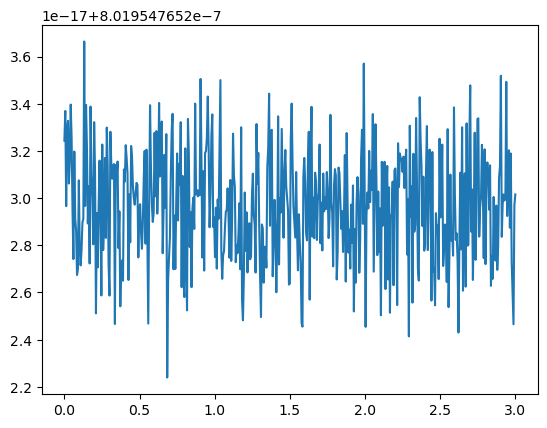

In [62]:
plt.plot(ep,ehat2[:,2]-pt_ra)

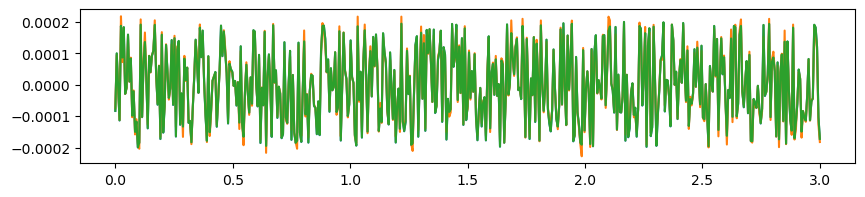

In [142]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])
plt.plot(ep,ehat2[:,2])

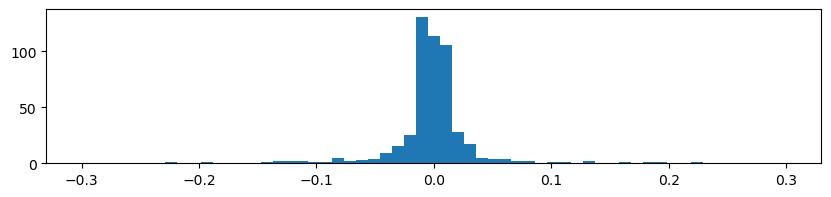

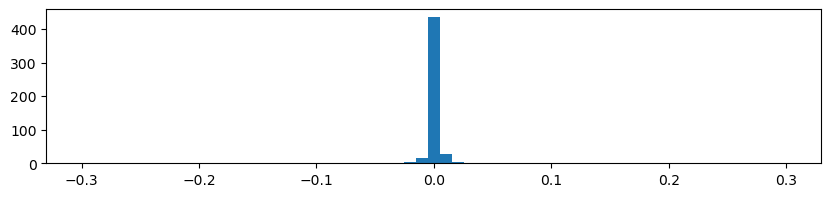

In [143]:
plt.figure(figsize=(10,2))
plt.hist((ehat2[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,60))

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,60));

In [144]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(8.019547652223964e-07, 8.019547652366367e-07), mean=8.01954765229656e-07, variance=5.508242272307281e-36, skewness=-0.006946938205347898, kurtosis=-0.36114237117720327)

#### Updating attitude first and then source twice

In [63]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat1,ehat1)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat2,ehat2)))

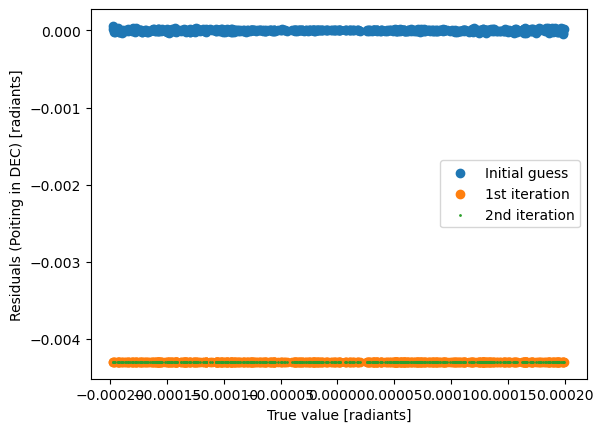

In [64]:
j = 1
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

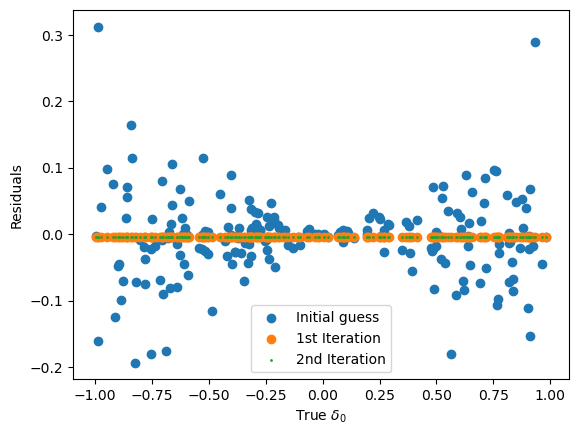

In [65]:
j = 1
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals");

In [66]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_83653/1503528511.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.describe(ehat1[:,2]-exp[:,2])


DescribeResult(nobs=501, minmax=(-0.0037912284541218107, -0.0037912284541217894), mean=-0.0037912284541218003, variance=1.742665673116638e-35, skewness=0.039456903091446595, kurtosis=-0.41934497133068493)

In [67]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.003791228454121942, -0.00379122845412172), mean=-0.0037912284541218, variance=1.6655093900843014e-33, skewness=0.7691436580814581, kurtosis=0.22205172819555408)

In [68]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_83653/4242913570.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.describe(ehat1[:,3]-exp[:,3])


DescribeResult(nobs=501, minmax=(-0.004295560085732456, -0.0042955600857324345), mean=-0.004295560085732445, variance=1.4916929272386762e-35, skewness=nan, kurtosis=nan)

In [69]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.004295560085732619, -0.004295560085732397), mean=-0.00429556008573245, variance=1.913076297616435e-33, skewness=-0.371903831885773, kurtosis=-0.3761905482225272)

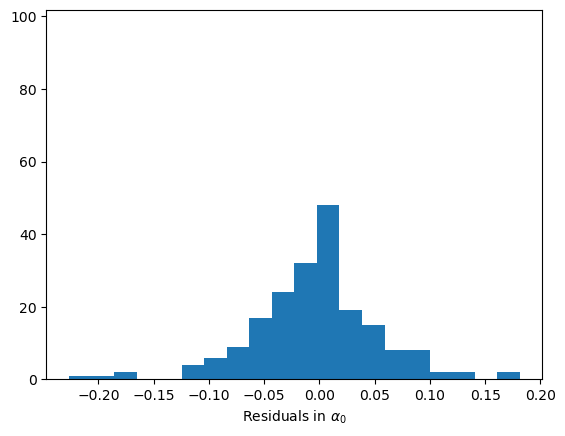

In [70]:
j = 0
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [71]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_83653/2473275113.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.describe(ehat2[:,2]-pt_ra)


DescribeResult(nobs=501, minmax=(-0.003791228454121805, -0.0037912284541217933), mean=-0.0037912284541217994, variance=5.859416160882807e-36, skewness=nan, kurtosis=nan)

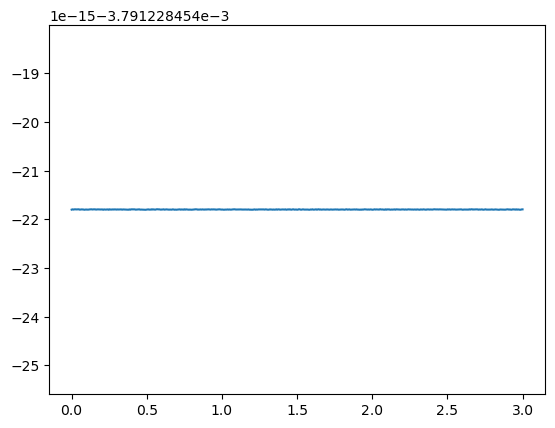

In [72]:
plt.plot(ep,ehat2[:,2]-pt_ra)

## Model with projection onto plane

The observation model is defined here.

### Epoch Position

Each star has astrometric parameters $(\alpha_{0},\delta_{0})$, which correspond to the position in ICRS coordiantes at the catalog epoch. The catalog epoch is set $t=0$. The observed position of a star at the observation epoch, $\alpha_{i}(t),\delta_{i}(t)$, is given by the following expression.

$$
  \alpha_{i}(t) = \alpha_{0,i}
$$
$$
  \delta{i}(t) = \delta_{0,i}
$$

In [2]:
_astronomicalunit_to_meters = units.astronomical_unit.to(units.meter)
_radiants_to_mas = units.radian.to(units.mas)

In [61]:
def longitude(t):
  ''' Longitude of the Earth

  Arguments:
      t: epoch of the observation [years]

  Returns:
    The longitude of the Earth in radian.
  '''
  return 2 * jnp.pi * t

def get_p0(alpha0,delta0):
    """
    First vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(alpha0),jnp.cos(alpha0),0])

def get_q0(alpha0,delta0):
    """
    Second vector of the reference triad. alpha0 and delta0 in radiants.
    """
    return jnp.array([-jnp.sin(delta0)*jnp.cos(alpha0),jnp.sin(delta0)*jnp.sin(alpha0),jnp.cos(delta0)])

def get_barycentric_position_satellite(time):
    return jnp.array([jnp.sin(longitude(time)),jnp.cos(longitude(time)),0])

def get_parallax_factor_vectorial(vec,bary):
    A = _astronomicalunit_to_meters
    return -jnp.dot(vec,bary)/A

def get_parallax_factor_alpha(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(alpha0)*jnp.cos(L) - jnp.cos(alpha0)*jnp.sin(L)

def get_parallax_factor_delta(time,alpha0,delta0):
    L = longitude(time)
    return jnp.sin(delta0)*jnp.cos(alpha0)*jnp.cos(L) - jnp.sin(delta0)*jnp.sin(alpha0)*jnp.sin(L)

def get_alpha_t(time,alpha0):
    """
    Predicted location of the right ascension of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - alpha0: in radians
    """
    return alpha0*_radiants_to_mas

def get_delta_t(time,delta0):
    """
    Predicted location of the declination of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - delta0: in radians
    """
    return delta0*_radiants_to_mas

def celestial_model(angle,pm,parallax,parallax_factor,t):
    """
    Celestial model describing the motion on the Celestial sphere of a star.
    1D
    """
    return angle + pm * t + parallax * parallax_factor

In [62]:
t = np.linspace(0,3,1000)
a0 = 0
d0 = np.pi/4

a = get_alpha_t(t,a0)
d = get_delta_t(t,d0)

In [63]:
def epoch_position(s, t):
    ''' Celestial position of a source
    
    Arguments:
      s: source parameters
        s[0]: right ascention
        s[1]: declination
    
    Returns:
    The celestial position of the source at the observation epoch.
    '''
    return s[0], s[1]

### Projection onto flat focal plane

In [64]:

def gnomonic_Rsint(tel_lon, tel_lat, lon, lat):
    ''' Calculate the projected coordinate x '''
    return jnp.sin(lon - tel_lon) * jnp.cos(lat) \
        / sptrig_cosr(tel_lon, tel_lat, lon, lat)


def gnomonic_Rcost(tel_lon, tel_lat, lon, lat):
    ''' Calculate the projected coordinate y '''
    return (jnp.sin(lat) * jnp.cos(tel_lat)
        - jnp.sin(tel_lat) * jnp.cos(lat) * jnp.cos(lon - tel_lon)) \
        / sptrig_cosr(tel_lon, tel_lat, lon, lat)


def sptrig_cosr(tel_lon, tel_lat, lon, lat):
    ''' Calculate cos(r), the cosine of the distance r

    Arguments:
      tel_lon: Longitude of the telescope center in radian.
      tel_lat: Latitude of the telescope center in radian.
      lon: Longitude of the target in radian.
      lat: Latitude of the target in radian.

    Return:
      cos(r) where r is the true distance from the telescope to the target.

    - PR: this function returns the angular separation between the point  
    where the telescope is pointing and the position of the target. 
    '''
    return jnp.sin(tel_lat) * jnp.sin(lat) \
        + jnp.cos(tel_lat) * jnp.cos(lat) * jnp.cos(lon - tel_lon)


def generate_conversion(xfunc, yfunc):
    """
    Takes in two functions and return one function.
    The function it returns simply takes pointing of
    the telescope and position of the star and returns 2
    values: the evaluation of the two functions with 
    some scaling and sign change
    
    - PR: why define a function on the local env. just to
    spit it out into the Global env.?
    """
    def conversion(tel_ra, tel_dec, ra, dec):
        X = -xfunc(tel_ra, tel_dec, ra, dec) * 180.0 / jnp.pi
        Y = +yfunc(tel_ra, tel_dec, ra, dec) * 180.0 / jnp.pi
        return X, Y
    return conversion


def generate_projection(func):
    def inner_func(tel_ra, tel_dec, tel_pa, ra, dec, scale):
        ''' Gnomonic projection of the spherical coordinates

        Arguments:
          tel_ra: A right ascension of the telescope center in degree.
          tel_dec: A declination of the telescope center in degree.
          tel_pa: A position angle of the telescope in degree.
          ra: A right ascension of the target in degree.
          dec: A declination of the target in degree.
          scale: Physical scales of the focal plane (mm/deg).

        Returns:
          Converted coordinates on the focal plane
        '''
        tel_ra = jnp.deg2rad(tel_ra)
        tel_dec = jnp.deg2rad(tel_dec)
        tel_pa = jnp.deg2rad(tel_pa)
        ra = jnp.deg2rad(ra)
        dec = jnp.deg2rad(dec)
        X, Y = func(tel_ra, tel_dec, ra, dec)
        return (rotation_matrix(-tel_pa) @ jnp.stack([X, Y])).T * scale
    return inner_func

def rotation_matrix(theta):
    ''' Calculate rotation matrix R '''
    rot = [jnp.cos(theta), -jnp.sin(theta), jnp.sin(theta), jnp.cos(theta)]
    return jnp.array(rot).reshape([2, 2])

In [65]:
gnomonic_conversion = \
    generate_conversion(gnomonic_Rsint, gnomonic_Rcost)

gnomonic = generate_projection(gnomonic_conversion)

In [66]:
projection_itersource = jax.vmap(gnomonic, (None, None, None, 0, 0, None), 0)
projection = jax.vmap(gnomonic, (0, 0, 0, 0, 0, 0), 0)

In [67]:
dprojdtel_ra = jax.vmap(jax.grad(gnomonic, argnums=(0)), (None, None,None,0,0,None))

In [221]:
dprojdtel_ra(tel_ra,tel_dec,rot,ra,dec,scale)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

#### Testing gnomonic projection

In [211]:
ra = np.arange(-1,1.2,0.2)
dec = np.arange(-0.5,0.75,0.25)

R,D = np.meshgrid(ra,dec)
ra = R.flatten()
dec = D.flatten()

In [216]:
tel_ra = 0.
tel_dec = 0.5
scale = 1.
rot = 45

aux = projection_itersource(tel_ra,tel_dec,rot,ra,dec,scale)

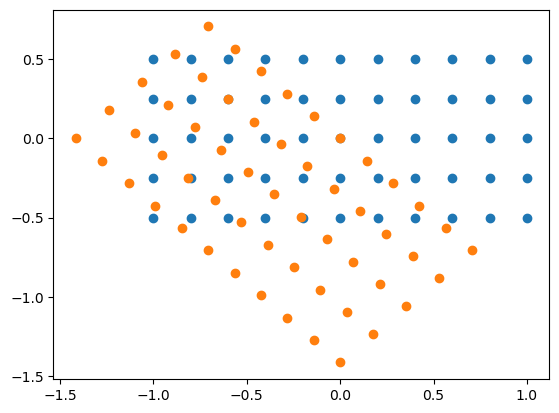

In [217]:
plt.scatter(ra,dec)
plt.scatter(aux[:,0],aux[:,1])
#plt.quiver(ra,dec,aux[:,0]-ra,aux[:,1]-dec,angles="xy",scale_units="xy",scale=1,alpha=0.5)

What could cause a displacement? It's basically saying that a star observed right in front of the telescope will NOT end up at the centre of the focal plane. How does that happen?

In [68]:
def position_ideal_plane_x(s, e, t):
    ''' Position X on the ideal focal plane (FPRS)
    This gives the coordinates of each star on a projected plane
    with inverted image along longitude (pinhole camera model).
    The plane can be rotated and displaced. 
    
    Arguments:
    s: source parameters
        s[0]: true right ascension [radiants]
        s[1]: true declination [radiants]
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
        e[2]: rotation of the telescope [radiants]
        e[3]: scale parameter of the telescope []
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FPRS reference system.
    '''
    #right ascension predicted by the model at time t
    alpha = get_alpha_t(t,s[0])/_radiants_to_mas
    #declination predicted by the model at time t
    delta = get_delta_t(t,s[1])/_radiants_to_mas
    a = alpha - e[0]
    x = -e[3]/sptrig_cosr(e[0],e[1],alpha,delta)*(jnp.sin(a)*jnp.cos(delta)*jnp.cos(e[2]) + \
                           (jnp.sin(delta)*jnp.cos(e[1])-jnp.sin(e[1])*jnp.cos(delta)*jnp.cos(a))*jnp.sin(e[2]))
    return x

def position_ideal_plane_y(s, e, t):
    ''' Position Y on the ideal focal plane (FPRS)
    This gives the coordinates of each star on a projected plane
    with inverted image along longitude (pinhole camera model).
    The plane can be rotated and displaced. 
    
    Arguments:
    s: source parameters
        s[0]: true right ascension [radiants]
        s[1]: true declination [radiants]
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
        e[2]: rotation of the telescope [radiants]
        e[3]: scale parameter of the telescope []
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FPRS reference system.
    '''
    #right ascension predicted by the model at time t
    alpha = get_alpha_t(t,s[0])/_radiants_to_mas
    #declination predicted by the model at time t
    delta = get_delta_t(t,s[1])/_radiants_to_mas
    a = alpha - e[0]
    y = e[3]/sptrig_cosr(e[0],e[1],alpha,delta)*(-jnp.sin(a)*jnp.cos(delta)*jnp.sin(e[2]) + \
                           (jnp.sin(delta)*jnp.cos(e[1])-jnp.sin(e[1])*jnp.cos(delta)*jnp.cos(a))*jnp.cos(e[2]))
    return y

In [69]:
def position_focal_plane(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta,zeta = position_ideal_plane(s, e, t)
    
    return eta,zeta

def position_focal_plane_eta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta = position_ideal_plane_x(s, e, t)
    
    return eta

def position_focal_plane_zeta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    zeta = position_ideal_plane_y(s, e, t)
    
    return zeta


eta = jax.jit(lambda s,e,t: position_focal_plane_eta(s,e,t))
zeta = jax.jit(lambda s,e,t: position_focal_plane_zeta(s,e,t))

### Generate simulation (NO DEFORMATIONS)

We set up the simulation. We prepare 200 artificial sources. The astrometric parameters are randomly sampled. The observations are scheduled from $t=0$ to $3$ years with equal intervals. The number of observations is 501. The telescope pointing directions are randomly sampled. 

`src` and `exp` contain the ground truth of the parameters. `src` contains the source astrometric parameters with `source_id`. `exp` contains the exposure parameters with `exposure_id`.

In [70]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.random.uniform(-1.0, 1.0, size=source_id.shape) #radiants
delta0 = np.random.uniform(-1.0, 1.0, size=source_id.shape) #radiants

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.random.uniform(-.2, .2, size=exposure_id.shape)
pt_dec = np.random.uniform(-.2, .2, size=exposure_id.shape)
rott = np.random.uniform(-0.1,0.1,size=exposure_id.shape)+np.pi/2
scalet = np.random.uniform(0.99,1.01,size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec,rott,scalet]).T

The initial estimates of the parameters are prepared. We assume that the source and exposure parameters can be estimated with uncertainties of 5%. We set the initial estimates of the calibration paramters to zeros.

In [71]:
perc = 1/10
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, perc, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, perc, size=exp[:, 2:].shape)])

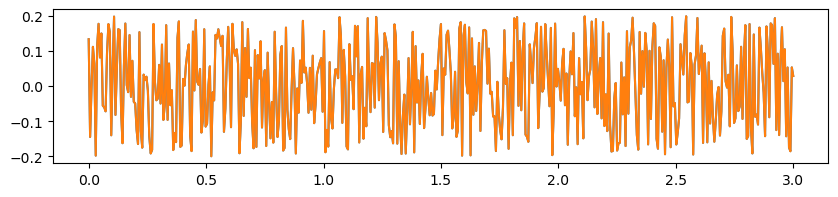

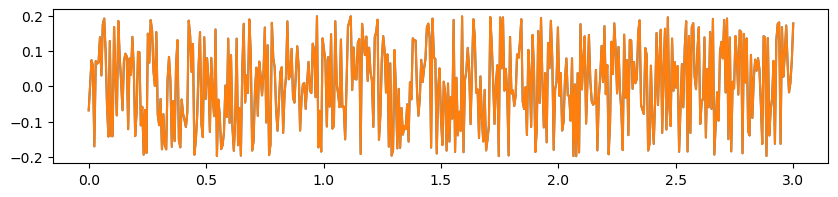

In [454]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])

plt.figure(figsize=(10,2))
plt.plot(ep,pt_dec)
plt.plot(ep,ehat[:,3]);

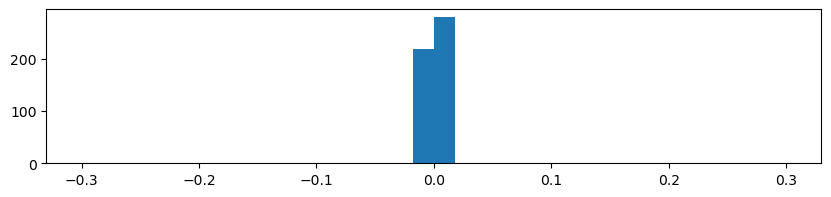

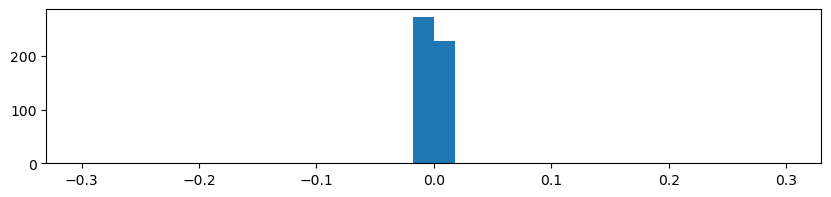

In [455]:
plt.figure(figsize=(10,2))
plt.hist((ehat[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,35))

plt.figure(figsize=(10,2))
plt.hist((ehat[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,35));

### Generate measurements

Predictions of the astrometric model are generated using the function `zeta`. The predictions can be affected by noise if desired, for instance, to generate mock observations. Here, we assume that the measurement error is given by a Gaussian distribution with the standard deviation of $\sigma_\text{obs}$.

$$
  \tilde\zeta_{i}(t) = \mathcal{N}(\zeta_{i}(t), \sigma_\text{obs})
$$

In [72]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [73]:
obs.shape

(200400, 4)

In [74]:
src[0]

Array([0.        , 0.87256124, 0.39231229], dtype=float64)

In [75]:
exp[0]

Array([ 0.        ,  0.        , -0.09054383, -0.18394446,  1.65714441,
        0.99694005], dtype=float64)

In [76]:
obs[0]

Array([ 0.        ,  0.        ,  0.        , -0.90015312], dtype=float64)

In [390]:
tel_ra = 0.
tel_dec = 0.3
scale = 1.
rot = 0

x_aux = [eta(s[1:],[tel_ra,tel_dec,rot,scale],0) for s in src]
y_aux = [zeta(s[1:],[tel_ra,tel_dec,rot,scale],0) for s in src]

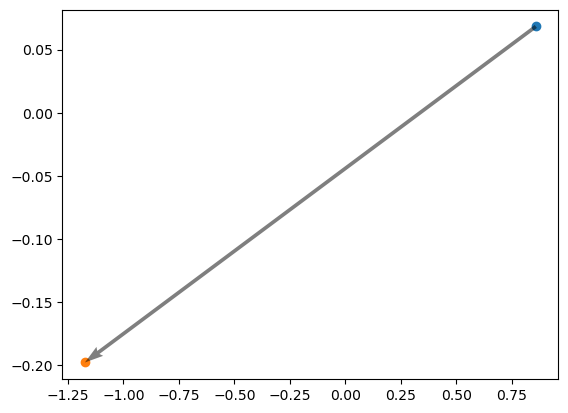

In [391]:
i = 0
plt.scatter(src[i,1],src[i,2])
plt.scatter(x_aux[i],y_aux[i])
plt.quiver(src[i,1],src[i,2],x_aux[i]-src[i,1],y_aux[i]-src[i,2],angles="xy",scale_units="xy",scale=1,alpha=0.5)

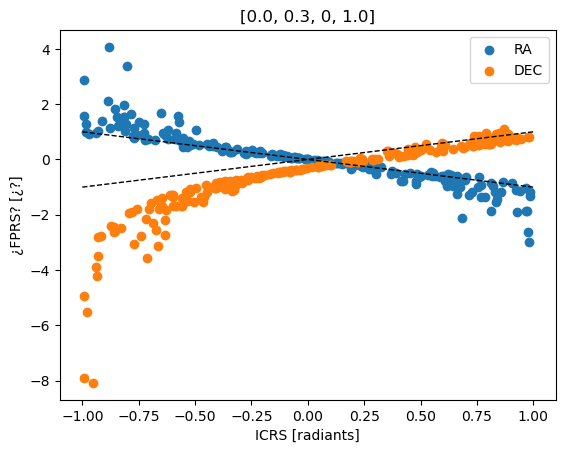

In [392]:
plt.scatter(src[:,1],x_aux,label="RA")
plt.scatter(src[:,2],y_aux,label="DEC")
plt.plot(np.linspace(-1,1,2),np.linspace(-1,1,2),color="k",ls="--",lw=1)
plt.plot(np.linspace(-1,1,2),-np.linspace(-1,1,2),color="k",ls="--",lw=1)
plt.legend()
plt.title([tel_ra,tel_dec,rot,scale])
plt.xlabel("ICRS [radiants]")
plt.ylabel("¿FPRS? [¿?]");

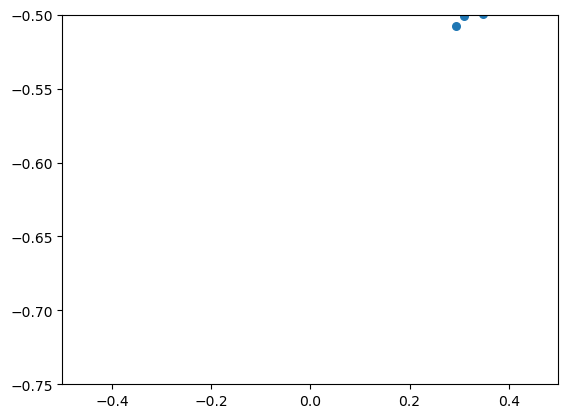

In [393]:
k = 50
aux = obs[obs[:,0]==k]
plt.scatter(aux[:exp.shape[0],3],aux[exp.shape[0]:,3],s=30)
plt.scatter(src[k,1],src[k,2],marker="*",color="k")
plt.scatter(src[k,1]-exp[:,2],src[k,2]-exp[:,3],color="tab:green",s=20)

plt.xlim(-0.5,0.5)
plt.ylim(-0.75,-0.5);

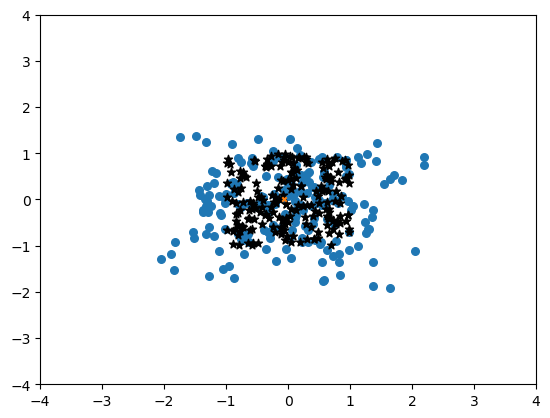

In [397]:
k = 23
aux = obs[obs[:,1]==k]
plt.scatter(aux[:src.shape[0],3],aux[src.shape[0]:,3],s=30)
plt.scatter(src[:,1],src[:,2],marker="*",color="k")
#plt.scatter(src[:,1]-exp[k,2],src[:,2]-exp[k,3],color="tab:green",s=4)
plt.scatter(exp[k,2],exp[k,3],c="tab:orange",s=10,marker="x")

plt.xlim(-4,4)
plt.ylim(-4,4);

In [77]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

### Calculate update

The updates of the parameters are obtained via the gradients. We define three functions:

- `update_source` returns the updated source parameters.
- `update_exposure` returns the updated exposure parameters.
- `update_calibration` returns the updated calibration parameters.

In [78]:
def update_source_inner(src, exp):
    c_eta = _iterate_exp_eta(src[1:],exp[:,2:],exp[:,1])
    o_eta = obs[(obs[:, 0] == src[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_exp_zeta(src[1:],exp[:,2:],exp[:,1])
    o_zeta = obs[(obs[:, 0] == src[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    Ds = np.vstack([deds(src[1:], exp[:, 2:], exp[:, 1]),
                    dzds(src[1:], exp[:, 2:], exp[:, 1])])

    
    
    N = Ds.T @ Ds
    b = Ds.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp) for _ in src])

In [79]:
shat[0]

Array([0.        , 0.79397215, 0.35448554], dtype=float64)

In [80]:
update_source_inner(shat[0],exp)

Array([0.8813612 , 0.39833122], dtype=float64)

In [81]:
src[0]

Array([0.        , 0.87256124, 0.39231229], dtype=float64)

In [547]:
update_source_inner(src[0],exp)

Array([0.85807499, 0.068386  ], dtype=float64)

In [553]:
update_source_inner(shat4[0],exp)

Array([0.86484441, 0.07018494], dtype=float64)

In [557]:
shat[j]

Array([0.        , 0.97548235, 0.0700426 ], dtype=float64)

In [574]:
j = 0
test = []
for i in range(10):
    if i==0:
        new_src_params = update_source_inner(shat[j],exp)
    else:
        new_src_params = update_source_inner(np.array([0]+new_src_params.tolist()),exp)
    test.append(new_src_params)

test = np.array(test)

In [577]:
j = 0
test_approx = []
for i in range(10):
    if i==0:
        new_src_params = update_source_inner(shat[j],ehat)
    else:
        new_src_params = update_source_inner(np.array([0]+new_src_params.tolist()),ehat)
    test_approx.append(new_src_params)

test_approx = np.array(test_approx)

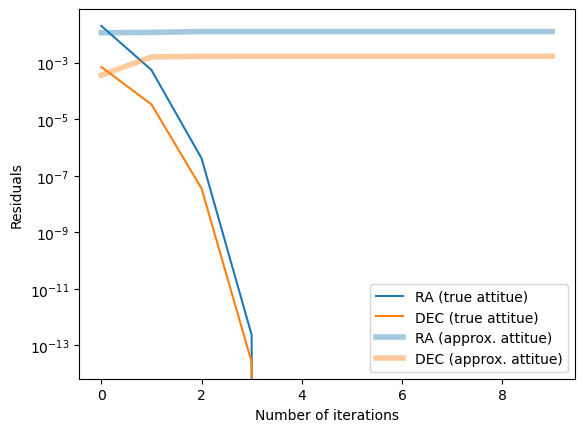

In [580]:
plt.plot(np.abs(test[:,0]-src[0][1]),label="RA (true attitue)")
plt.plot(np.abs(test[:,0+1]-src[0][1+1]),label="DEC (true attitue)")

plt.plot(np.abs(test_approx[:,0]-src[0][1]),lw=4,alpha=.4,color="tab:blue",label="RA (approx. attitue)")
plt.plot(np.abs(test_approx[:,0+1]-src[0][1+1]),lw=4,alpha=.4,color="tab:orange",label="DEC (approx. attitue)")
plt.axhline(0,color="tab:green",lw=1);
plt.legend()
plt.gca().set_yscale("log");
plt.xlabel("Number of iterations")
plt.ylabel("Residuals");

In [576]:
np.abs(test[:,0]-src[0][1])

array([2.01814135e-02, 5.56854533e-04, 4.17896923e-07, 2.35256259e-13,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [82]:
def update_exposure_inner(src, exp):
    c_eta = _iterate_src_eta(src[:,1:], exp[2:],exp[1])
    o_eta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(src[:,1:], exp[2:],exp[1])
    o_zeta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(src[:,1:], exp[2:], exp[1]),
                    dzde(src[:,1:], exp[2:], exp[1])])

    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _) for _ in exp])

In [83]:
ehat[0]

Array([ 0.        ,  0.        , -0.09494594, -0.14808684,  1.31737057,
        1.07063191], dtype=float64)

In [407]:
update_exposure_inner(src,exp[0])

Array([ 0.13381331, -0.06829954,  1.64875807,  1.0098466 ], dtype=float64)

In [408]:
exp[0]

Array([ 0.        ,  0.        ,  0.13381331, -0.06829954,  1.64875807,
        1.0098466 ], dtype=float64)

In [583]:
j = 0
test = []
for i in range(10):
    if i==0:
        new_src_params = update_exposure_inner(src,ehat[j])
    else:
        new_src_params = update_exposure_inner(src,np.array([0,0]+new_src_params.tolist()))
    test.append(new_src_params)

test = np.array(test)

In [584]:
j = 0
test_approx = []
for i in range(10):
    if i==0:
        new_src_params = update_exposure_inner(shat,ehat[j])
    else:
        new_src_params = update_exposure_inner(shat,np.array([0,0]+new_src_params.tolist()))
    test_approx.append(new_src_params)

test_approx = np.array(test_approx)

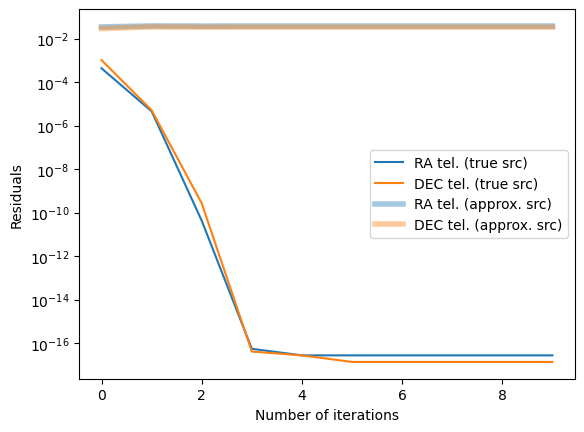

In [588]:
plt.plot(np.abs(test[:,0]-exp[0][2]),label="RA tel. (true src)")
plt.plot(np.abs(test[:,0+1]-exp[0][2+1]),label="DEC tel. (true src)")

plt.plot(np.abs(test_approx[:,0]-exp[0][2]),lw=4,alpha=.4,color="tab:blue",label="RA tel. (approx. src)")
plt.plot(np.abs(test_approx[:,0+1]-exp[0][2+1]),lw=4,alpha=.4,color="tab:orange",label="DEC tel. (approx. src)")
plt.axhline(0,color="tab:green",lw=1);
plt.legend()
plt.gca().set_yscale("log");
plt.xlabel("Number of iterations")
plt.ylabel("Residuals");

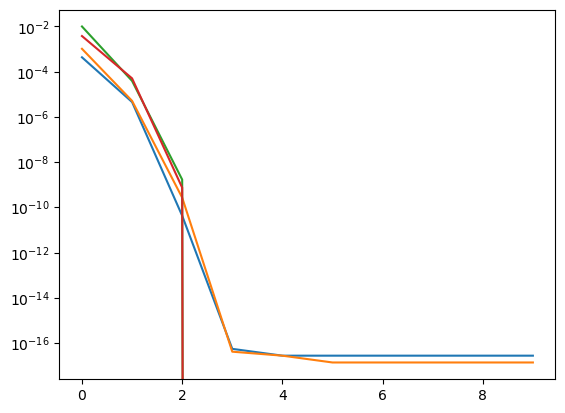

In [586]:
plt.plot(np.abs(test[:,0]-exp[0][2]))
plt.plot(np.abs(test[:,0+1]-exp[0][2+1]))
plt.plot(np.abs(test[:,0+2]-exp[0][2+2]))
plt.plot(np.abs(test[:,0+3]-exp[0][2+3]))
plt.axhline(0,color="tab:green",lw=1);
plt.gca().set_yscale("log");

In [571]:
np.abs(test[:,0]-exp[0][2])

array([4.30779435e-04, 4.54050065e-06, 4.28091729e-11, 5.55111512e-17,
       2.77555756e-17, 2.77555756e-17, 2.77555756e-17, 2.77555756e-17,
       2.77555756e-17, 2.77555756e-17])

In [411]:
for _exp in ehat:
    c_eta = _iterate_src_eta(shat[:,1:], _exp[2:],_exp[1])
    o_eta = obs[(obs[:, 1] == _exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(shat[:,1:], _exp[2:],_exp[1])
    o_zeta = obs[(obs[:, 1] == _exp[0])&(obs[:,2]==1)][:, 3]
    
    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(shat[:,1:], _exp[2:], _exp[1]),
                    dzde(shat[:,1:], _exp[2:], _exp[1])])
    
    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)

    print(b,delta)

[-72.47431264  27.10294672 -15.96196436 -71.15455305] [-0.00457351 -0.01051645 -0.03647496 -0.21373595]
[ 92.51222921 -14.32992373  14.49702742 -72.02350621] [ 0.01261397 -0.01097682  0.03406519 -0.20049492]
[ -5.65215862 -87.48807898 -34.61545645 -33.65877872] [ 0.00597606 -0.03445815 -0.10748553 -0.07928055]
[ -38.0352036  -127.34135388   25.23037204  -45.80727889] [ 0.00039162 -0.0373619   0.06393114 -0.10180394]
[  6.79888608 -13.03389982  33.88945653  -7.17460821] [ 0.01936532 -0.01560753  0.09981148 -0.04722085]
[-43.05564266 -21.24525889  -0.77782503  45.52736137] [ 0.00359683 -0.04017281  0.00331754  0.14814119]
[  2.73406572 -77.95559916 -20.06164858  -0.86738488] [ 0.01973973 -0.04732499 -0.07738025  0.02961192]
[ -86.1042     -267.1841747    29.18092043  -67.59771791] [ 0.0053271  -0.04771252  0.05634666 -0.10819721]
[-121.43629679 -756.48081945   73.42349549 -125.38858505] [ 0.01188367 -0.05480427  0.12885525 -0.16058842]
[-55.11212398 -53.98283665 -65.15209066 -47.34881328

### Update parameters

The problem is no longer linear so there is no guarantee that, starting from a random point, we make it to the optimal in one step.

We can try:
1. Internal Looping => results: just feeding the output to the input does not work. The solver seems to advance very close to the minima in just one step.
2. Starting closer to the truth => it helps, but still the mean value of the final resudials increases x10 wrt initial guess. The dispersion of the residuals, on the other hand, decrease significantly.
3. External Looping => it does help (no more trends and very small dispersions in residuals) but it converges to the wrong value. Also, if we start far from the truth, it doesn't matter that we add more iterations, it does not progress forward anymore.

NOTE: looping either the source parameter solver or the attitue solver on its own (i.e. taking the true values for the other) converges to machine precision in about 4 iteretions for an initial guess that is not that good.

#### Updating attitude first and then source

In [84]:
loop = False

In [85]:
## inner loop on exposure parameters due to non-linearity
if not loop:
    ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
else:
    ehat1a = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
    ehat1b = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat1a)))
    ehat1c = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat1b)))
    ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat1c)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

if not loop:
    ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
else:
    ehat2a = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
    ehat2b = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat2a)))
    ehat2c = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat2b)))
    ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat2c)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2)))

In [86]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2)))

ehat3 = jnp.column_stack((ehat[:,:2],update_exposure(shat2,ehat2)))
shat3 = jnp.column_stack((shat[:,0],update_source(shat2,ehat3)))

ehat4 = jnp.column_stack((ehat[:,:2],update_exposure(shat3,ehat3)))
shat4 = jnp.column_stack((shat[:,0],update_source(shat3,ehat4)))

In [532]:
ehat5 = jnp.column_stack((ehat[:,:2],update_exposure(shat4,ehat4)))
shat5 = jnp.column_stack((shat[:,0],update_source(shat4,ehat5)))

In [450]:
scipy.stats.describe(ehat2c - ehat2b)

DescribeResult(nobs=501, minmax=(array([ 0.00000000e+00,  0.00000000e+00, -3.44139668e-04, -1.21104316e-04,
       -4.64453154e-05, -1.72994105e-03]), array([0.        , 0.        , 0.00010793, 0.00074065, 0.00062622,
       0.00042606])), mean=array([ 0.00000000e+00,  0.00000000e+00, -1.75599447e-05,  6.06918493e-06,
        3.48489420e-05, -5.60228621e-05]), variance=array([0.00000000e+00, 0.00000000e+00, 3.86337206e-09, 1.41015551e-08,
       8.83991732e-09, 4.57007834e-08]), skewness=array([        nan,         nan, -2.82558382,  3.28599485,  3.96101264,
       -3.38965795]), kurtosis=array([        nan,         nan,  9.87177668, 12.12424155, 17.12418787,
       17.76984431]))

In [87]:
scipy.stats.describe(shat2-shat1)

DescribeResult(nobs=200, minmax=(array([ 0.        , -0.02881215, -0.08458011]), array([0.        , 0.01858901, 0.0447035 ])), mean=array([ 0.        , -0.00327973,  0.00785462]), variance=array([0.00000000e+00, 9.23717544e-05, 1.27604801e-04]), skewness=array([        nan, -0.0520456 , -2.86400137]), kurtosis=array([        nan, -0.62443589, 22.63771714]))

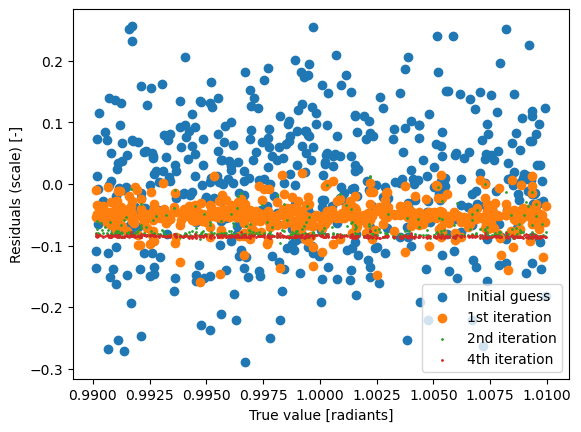

In [91]:
j = 3
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
plt.scatter(exp[:,2+j],ehat4[:,2+j]-exp[:,2+j],label="4th iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
elif j==2:
    plt.ylabel("Residuals (rotation) [radiants]")
elif j==3:
    plt.ylabel("Residuals (scale) [-]")
plt.xlabel("True value [radiants]")
plt.legend();

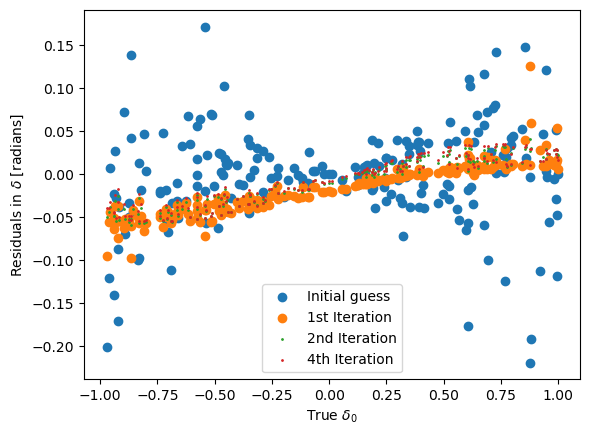

In [94]:
j = 1
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.scatter(src[:,1+j],shat4[:,1+j]-src[:,1+j],label="4th Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals in {}".format([r"$\alpha$ [radians]",r"$\delta$ [radians]",r"$\mu_{\alpha}$",
                        r"$\mu_{\delta}$",r"$\varpi$"][j]));

In [95]:
scipy.stats.describe(ehat[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.05461362302904452, 0.0471396058232782), mean=-2.3915858132418796e-05, variance=0.0001410730362779552, skewness=-0.18341331391166968, kurtosis=2.1636124834022343)

In [96]:
scipy.stats.describe(ehat[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.05598048846687545, 0.041804343539277755), mean=-0.0005546038737847447, variance=0.00012784939580705082, skewness=-0.4550678433148417, kurtosis=2.6754031636214206)

In [97]:
scipy.stats.describe(ehat2[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.028240724042251655, 0.011076581215662906), mean=-0.0021508125995199027, variance=7.51341099820479e-05, skewness=-1.0456525334891238, kurtosis=0.39815355689772547)

In [98]:
scipy.stats.describe(shat2[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.045788735277990544, 0.060438036204172874), mean=-0.003235771813135034, variance=0.0010421810070908822, skewness=0.18955604810482574, kurtosis=-1.4331062744271708)

In [99]:
scipy.stats.describe(ehat2[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.03711960698530675, 0.03978471530537156), mean=-0.010943659967519871, variance=0.000245330444714814, skewness=0.9749167829108364, kurtosis=0.5480564206260965)

In [100]:
scipy.stats.describe(shat2[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.058823056194352796, 0.04096928074145889), mean=-0.008736856989450327, variance=0.0008008167755608407, skewness=-0.204158024430678, kurtosis=-1.3516856399355008)

In [101]:
scipy.stats.describe(ehat2[:,4]-exp[:,4])

DescribeResult(nobs=501, minmax=(-0.010247826832605833, 0.007304936125608563), mean=-0.000941350708864381, variance=9.219429280703867e-06, skewness=-0.2608190301978194, kurtosis=0.007204667194733005)

In [102]:
scipy.stats.describe(ehat2[:,5]-exp[:,5])

DescribeResult(nobs=501, minmax=(-0.09579398951296914, 0.012438455119127667), mean=-0.0766973446312263, variance=0.00024456061739703064, skewness=3.0875940744675687, kurtosis=10.271564299602613)

In [533]:
scipy.stats.describe(ehat[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.03622204099518431, 0.04943742446871979), mean=0.0004845561590713847, variance=0.0001340112483593583, skewness=0.382956764180959, kurtosis=1.9316921856306575)

In [534]:
scipy.stats.describe(ehat[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.05466584009311812, 0.0386484121252208), mean=0.0002563684085642979, variance=0.0001266318310102836, skewness=0.12816858985324678, kurtosis=2.4223981655508595)

In [537]:
scipy.stats.describe(ehat5[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.3258738777482019, 0.022514716359640252), mean=0.00655523525859029, variance=0.0003165186419024417, skewness=-15.001520260945968, kurtosis=260.83761050078283)

In [103]:
scipy.stats.describe(ehat4[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.014430452257687854, 0.0055414570090179804), mean=-0.0036469947877305568, variance=9.474569009755445e-06, skewness=-0.430710342626295, kurtosis=1.469889698056745)

In [104]:
scipy.stats.describe(shat4[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.05198765027399155, 0.04617361951566745), mean=-0.005866388732893788, variance=0.0011411778898312538, skewness=0.1020593357179127, kurtosis=-1.5497751962962836)

In [105]:
scipy.stats.describe(ehat4[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.02217341106522777, 0.002921989689385951), mean=-0.009850587463620327, variance=2.22892358478512e-05, skewness=0.007378212676398464, kurtosis=-0.2585772704181024)

In [106]:
scipy.stats.describe(shat4[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.05497606043999703, 0.035472296302819784), mean=-0.007142369945591305, variance=0.0007669430155819266, skewness=-0.2006743427236383, kurtosis=-1.324892799227315)

In [107]:
scipy.stats.describe(ehat4[:,4]-exp[:,4])

DescribeResult(nobs=501, minmax=(-0.004955674282057121, 0.004313814513453362), mean=-0.00020835799210735647, variance=1.5040238818652783e-06, skewness=-0.817814008161225, kurtosis=2.2377749789261445)

In [108]:
scipy.stats.describe(ehat4[:,5]-exp[:,5])

DescribeResult(nobs=501, minmax=(-0.0882012110256829, -0.07658060863085636), mean=-0.08486293422487917, variance=2.640396940745271e-06, skewness=1.103160431423073, kurtosis=3.096299171426587)

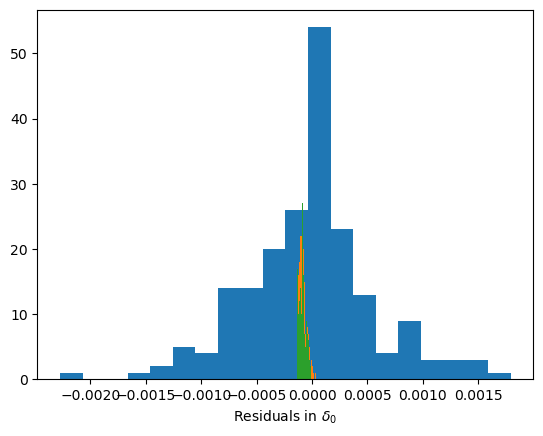

In [505]:
j = 1
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [424]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(-0.0015631191734544053, 0.053570560877180096), mean=0.008822796116757075, variance=3.1446350748305634e-05, skewness=3.1205151592497558, kurtosis=19.649620786667448)

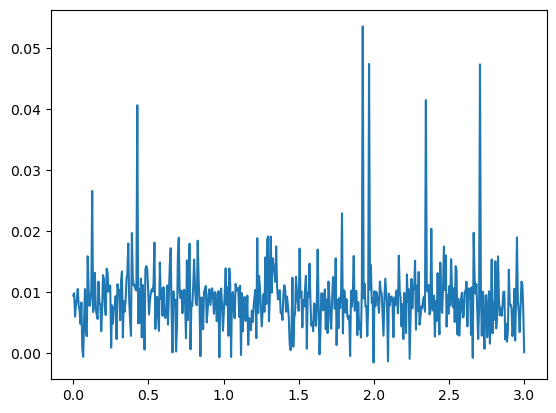

In [425]:
plt.plot(ep,ehat2[:,2]-pt_ra)

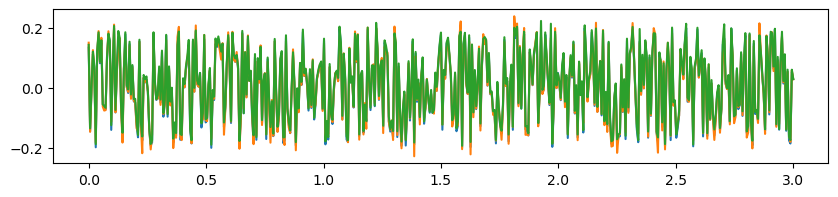

In [426]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])
plt.plot(ep,ehat2[:,2])

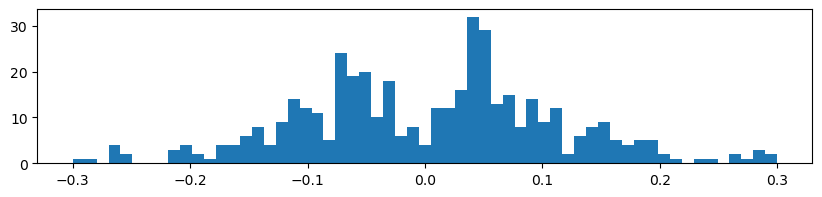

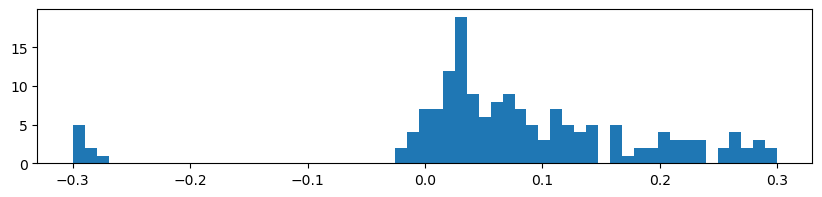

In [427]:
plt.figure(figsize=(10,2))
plt.hist((ehat2[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,60))

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,60));

#### Updating source first and then attitue

In [428]:
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat)))
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat)))

shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat1)))
ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat2,ehat)))

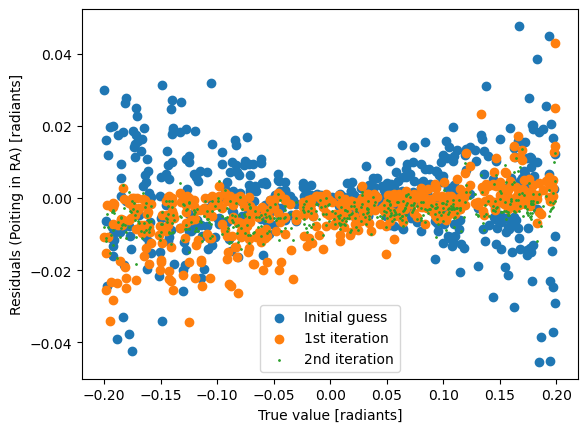

In [431]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

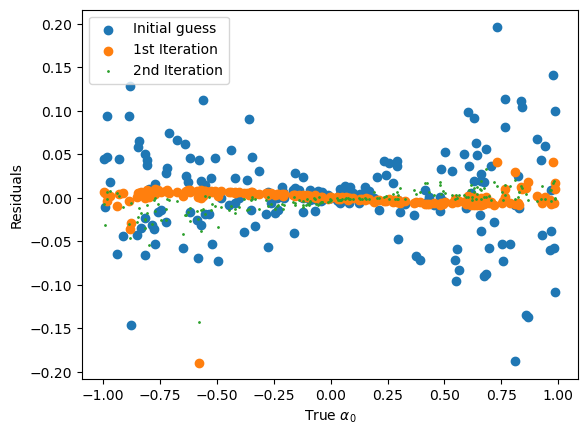

In [432]:
j = 0
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals");

In [433]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.03448437700559395, 0.043158474325799945), mean=-0.0037354200316865316, variance=5.7600229812117745e-05, skewness=-0.3014910325458316, kurtosis=4.892685153212282)

In [434]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.18929856491391406, 0.041783821566375945), mean=0.00015081217859820315, variance=0.00024318528188426922, skewness=-8.876730894391407, kurtosis=107.82523381396118)

In [435]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.11132026386831087, 0.0021206439578088376), mean=-0.0241990806900024, variance=0.0003711815802078191, skewness=-0.9890910749120798, kurtosis=0.3699498999635411)

In [436]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.18362897161574243, 0.060724001519395276), mean=-0.00013078063481830203, variance=0.00027593447862548514, skewness=-6.432397653777777, kurtosis=74.92726158462624)

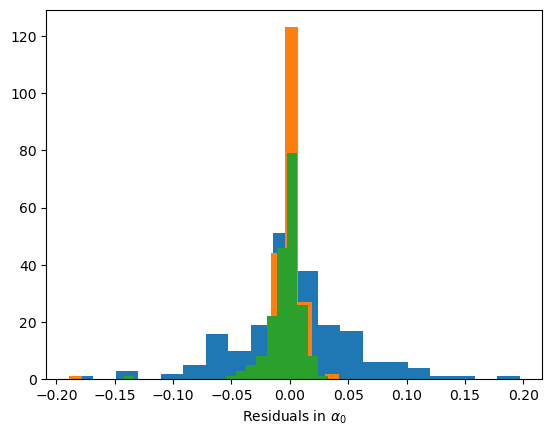

In [437]:
j = 0
plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

In [438]:
scipy.stats.describe(ehat2[:,2]-pt_ra)

DescribeResult(nobs=501, minmax=(-0.018271039207467754, 0.013737559015973122), mean=-0.0041966085063553015, variance=1.695898292499292e-05, skewness=0.4565970549605903, kurtosis=2.124022959405803)

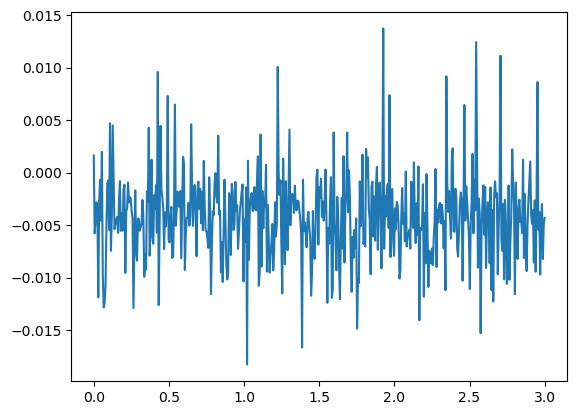

In [439]:
plt.plot(ep,ehat2[:,2]-pt_ra)

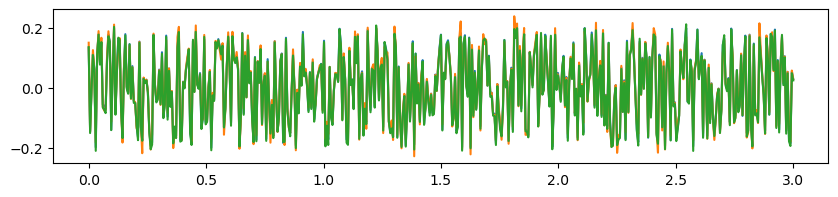

In [440]:
plt.figure(figsize=(10,2))
plt.plot(ep,pt_ra)
plt.plot(ep,ehat[:,2])
plt.plot(ep,ehat2[:,2])

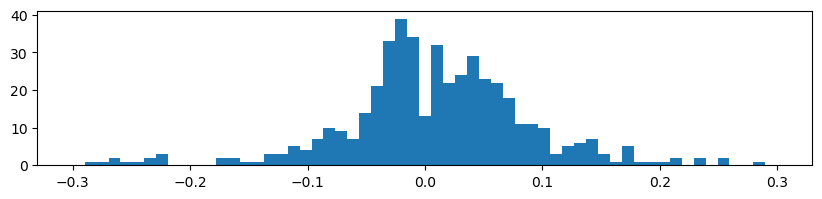

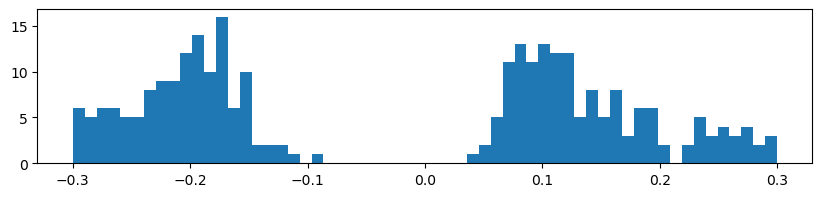

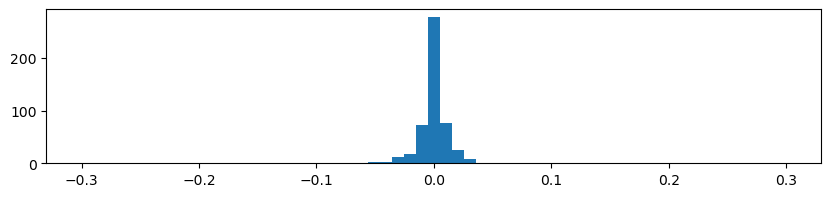

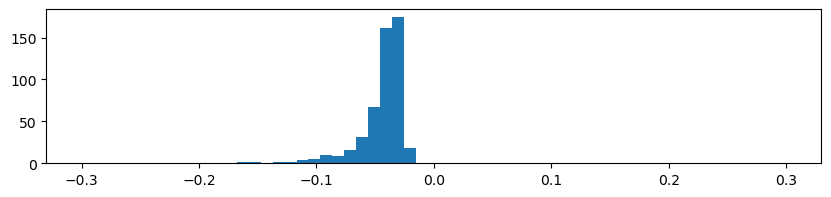

In [444]:
plt.figure(figsize=(10,2))
plt.hist((ehat2[:,2]-pt_ra)/pt_ra,bins=np.linspace(-0.3,0.3,60))

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,3]-pt_dec)/pt_dec,bins=np.linspace(-0.3,0.3,60));

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,4]-rott)/rott,bins=np.linspace(-0.3,0.3,60));

plt.figure(figsize=(10,2))
plt.hist((ehat2[:,5]-scalet)/scalet,bins=np.linspace(-0.3,0.3,60));

## Simplest Model with priors

##### Differences with the previous models

In this implementation, we consider that each observation is accompanied by an observational uncertainty. For simplicity, we use the same value for all observations.

In [569]:
def get_alpha_t(time,alpha0):
    """
    Predicted location of the right ascension of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - alpha0: in radians
    """
    return alpha0*_radiants_to_mas

def get_delta_t(time,delta0):
    """
    Predicted location of the declination of a source with linear motion on the tangential plane
    (Earth rotating on a circular orbit along the ICRS plane)
    - delta0: in radians
    """
    return delta0*_radiants_to_mas

In [570]:
def epoch_position(s, t):
    ''' Celestial position of a source
    
    Arguments:
      s: source parameters
        s[0]: right ascention
        s[1]: declination
    
    Returns:
    The celestial position of the source at the observation epoch.
    '''
    return s[0], s[1]

In [571]:
def position_ideal_plane_eta(s, e, t):
    ''' Position eta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    alpha = get_alpha_t(t,s[0])/_radiants_to_mas
    eta = alpha - e[0]
    return eta

def position_ideal_plane_zeta(s, e, t):
    ''' Position zeta on the ideal focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing in right ascension [radiants]
        e[1]: telescope pointing in declination [radiants]
    
    Returns:
    The position on the ideal focal plane at the observation epoch. FoV reference system.
    '''
    delta = get_delta_t(t,s[1])/_radiants_to_mas
    zeta = delta - e[1]
    return zeta

In [572]:
def position_focal_plane(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta,zeta = position_ideal_plane(s, e, t)
    
    return eta,zeta

def position_focal_plane_eta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    eta = position_ideal_plane_eta(s, e, t)
    
    return eta

def position_focal_plane_zeta(s, e, t):
    ''' Position on the actual focal plane
    
    Arguments:
    s: source parameters
    e: exposure parameters
    
    Returns:
    Ideally, the position on the focal plane (Detector reference system) with distortion. 
    For now, it changes nothing. There is no projection onto a flat plane either.
    '''
    zeta = position_ideal_plane_zeta(s, e, t)
    
    return zeta


eta = jax.jit(lambda s,e,t: position_focal_plane_eta(s,e,t))
zeta = jax.jit(lambda s,e,t: position_focal_plane_zeta(s,e,t))

### Generate simulation (NO SCALING NO DEFORMATIONS)

We set up the simulation. We prepare 200 artificial sources. The astrometric parameters are randomly sampled. The observations are scheduled from $t=-10$ to $10$ with equal intervals. The number of observations is 501. The telescope pointing directions are randomly sampled. 

`src` and `exp` contain the ground truth of the parameters. `src` contains the source astrometric parameters with `source_id`. `exp` contains the exposure parameters with `exposure_id`.

In [573]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)
pt_dec = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

The initial estimates of the parameters are prepared. We assume that the source and exposure parameters can be estimated with uncertainties of 5%. We set the initial estimates of the calibration paramters to zeros.

In [574]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

### Generate measurements

Predictions of the astrometric model are generated using the function `eta` and `zeta`. The predictions can be affected by noise if desired, for instance, to generate mock observations. Here, we assume that the measurement error is given by a Gaussian distribution with the standard deviation of $\sigma_\text{obs}$.

$$
  \tilde\eta_{i}(t) = \mathcal{N}(\eta_{i}(t), \sigma_\text{obs})
$$
$$
  \tilde\zeta_{i}(t) = \mathcal{N}(\zeta_{i}(t), \sigma_\text{obs})
$$

In [664]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 10/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

## priors are drawn from the true values with the posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 10/_radiants_to_mas
priors = [np.random.normal(src_[1:],priors_uncertainty) for src_ in src]
sig_prior = np.array([[priors_uncertainty,priors_uncertainty]]*len(src))

In [623]:
obs.shape

(200400, 4)

#### Calculate gradients

Gradient functions are obtained via `jax.grad`. Three functions are defined:

- `dzds`: Gradients in terms of the source parameters.
- `dzde`: Gradients in terms of the exposure parameters.
- `dzdc`: Gradients in terms of the calibration parameters.

In [667]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

### Calculate update

The updates of the parameters are obtained via the gradients. We define three functions:

- `update_source` returns the updated source parameters.
- `update_exposure` returns the updated exposure parameters.
- `update_calibration` returns the updated calibration parameters.

In [668]:
def update_source_inner(src, exp,obs,sig_obs,priors=None,sig_prior=None):
    """
    Compute the optimal new set of source parameters that 
    minimize the residuals. It assumes a set of attitude 
    parameters.
    
    Inputs:
        - src: best guess for the source parameters of this source
        - exp: assumed attitude parameters for each of the observations 
        - obs: actual observations of this source
        - sig_obs: vector of observational uncertainties. If just a float,
            we assume the same value to all observations.
        - priors: vector containing the central value of the Gaussian prior
            on each source parameter. Ordered as RA,DEC.
        - sig_prior: vector containing the dispersion of the Gaussian prior
            on each source parameter. Ordered as RA,DEC.

    Output:
        - new source parameters
    """
    #check if priors are given:
    if priors is not None:
        if sig_prior is None:
            raise ValueError("If the priors are given, you need to provide also their uncertainties!")
        else:
            priors = jnp.array(priors)
            sig_prior = jnp.array(sig_prior)
    
    c_eta = _iterate_exp_eta(src[1:],exp[:,2:],exp[:,1])
    o_eta = obs[(obs[:, 0] == src[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_exp_zeta(src[1:],exp[:,2:],exp[:,1])
    o_zeta = obs[(obs[:, 0] == src[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    Ds = jnp.vstack([deds(src[1:], exp[:, 2:], exp[:, 1]),
                    dzds(src[1:], exp[:, 2:], exp[:, 1])])

    if isinstance(sig_obs,(float,int)):
        S = jnp.eye(len(o))*sig_obs**(-2)
    elif isinstance(sig_obs,np.ndarray):
        s = jnp.hstack([sig_obs[(obs[:, 0] == src[0])&(obs[:,2]==0)],sig_obs[(obs[:, 0] == src[0])&(obs[:,2]==1)]])
        S = jnp.diag(s**(-2))
    else:
        raise ValueError("The observational uncertainties have to be either a scalar or a numpy array")

    if priors is None:
        N = Ds.T @ S @ Ds
        b = Ds.T @ S @ (o - c)
    else:
        N = Ds.T @ S @ Ds + jnp.diag(sig_prior**(-2))
        b = Ds.T @ S @ (o - c) + jnp.matmul(np.diag(sig_prior**(-2)),(priors-src[1:]))
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp,obs,sig_obs,priors,sig_prior):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      obs: observations
      sig_obs: list of tuples containing the uncertainties for each source
      priors:list of tuples containing the priors for each source
      sig_prior:list of tuples containing the uncertainties in the priors for each source

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp,obs,sig_obs,priors[i],sig_prior[i]) for i,_ in enumerate(src)])

In [594]:
shat[0]

Array([0.        , 0.59708302, 0.27605033], dtype=float64)

In [629]:
update_source_inner(shat[0],exp,obs,sig_obs)

Array([0.66275257, 0.2938789 ], dtype=float64)

In [630]:
update_source_inner(shat[0],exp,obs,sig_obs*1000)

Array([0.66275257, 0.2938789 ], dtype=float64)

In [595]:
update_source_inner(shat[0],ehat,obs,sig_obs)

Array([0.66618034, 0.28536659], dtype=float64)

In [604]:
update_source_inner(shat[0],ehat,obs,sig_obs,priors=[0.66275257, 0.2938789],sig_prior=[10/_radiants_to_mas,10/_radiants_to_mas])

Array([0.66618027, 0.28536676], dtype=float64)

In [603]:
update_source_inner(shat[0],ehat,obs,sig_obs*100,priors=[0.66275257, 0.2938789],sig_prior=[10/_radiants_to_mas,10/_radiants_to_mas])

Array([0.66560999, 0.28678295], dtype=float64)

In [593]:
src[0]

Array([0.        , 0.66275257, 0.2938789 ], dtype=float64)

In [605]:
np.round(src[0,1:]*10*_radiants_to_mas,0)/_radiants_to_mas/10

Array([0.66275257, 0.2938789 ], dtype=float64)

In [669]:
def update_exposure_inner(src, exp,obs,sig_obs):
    """
    Compute the optimal new set of attitude parameters that 
    minimize the residuals. It assumes a set of source 
    parameters.
    
    Inputs:
        - src: assumed source parameters of all the sources in this exposure
        - exp: best guess attitude parameters of the observations 
        - obs: actual observations of these source
        - sig_obs: vector of observational uncertainties. If just a float,
            the same value would be used and therefore it would not affect
            the result.

    Output:
        - new source parameters
    """
    c_eta = _iterate_src_eta(src[:,1:], exp[2:],exp[1])
    o_eta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(src[:,1:], exp[2:],exp[1])
    o_zeta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(src[:,1:], exp[2:], exp[1]),
                    dzde(src[:,1:], exp[2:], exp[1])])

    if isinstance(sig_obs,(float,int)):
        N = De.T @ De
        b = De.T @ (o - c)
    elif isinstance(sig_obs,(list,tuple,np.ndarray)):
        S = jnp.diag(sig_obs**(-2)) 
        N = De.T @ S @ De
        b = De.T @ S @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp,obs,sig_obs):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      obs: observations
      sig_obs: uncertainties

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _,obs,sig_obs) for _ in exp])

In [613]:
ehat[0]

Array([ 0.        ,  0.        ,  0.02311536, -1.16045166], dtype=float64)

In [611]:
update_exposure_inner(src,ehat[0],obs,sig_obs)

Array([ 0.02025514, -1.21756402], dtype=float64)

In [612]:
update_exposure_inner(shat,ehat[0],obs,sig_obs)

Array([ 0.01653924, -1.22702409], dtype=float64)

In [614]:
exp[0]

Array([ 0.        ,  0.        ,  0.02025514, -1.21756401], dtype=float64)

### Update parameters

We demonstrate the parameter optimization with the AGIS-like approach. First, we visualize the residuals calculated for the initial estimates. The horizontal axes show the ground truth values, and the vertical axes shows the estimated parameters. The bottom panel shows the residuals against the exposure ID. The root-mean-squared residual is denoted in the legend. Since the measurement error is $\sigma_\text{obs} = 0.015$, the RMS residual will be 0.015 when the parameters are successfully converged.

#### Updating attitude first and then source

In [670]:
%%time
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat,obs,sig_obs)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1,obs,sig_obs,priors,sig_prior)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1,obs,sig_obs)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2,obs,sig_obs,priors,sig_prior)))

CPU times: user 10.2 s, sys: 3.11 s, total: 13.3 s
Wall time: 10.1 s


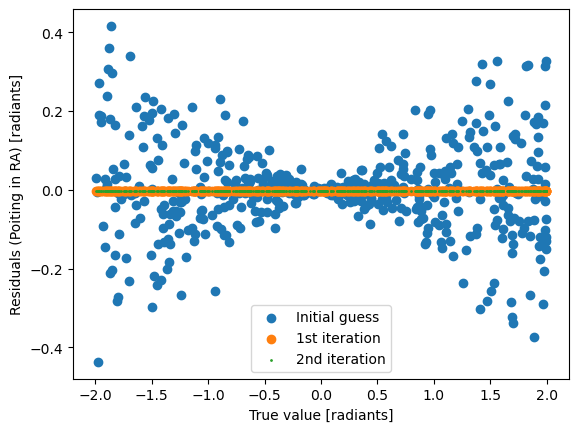

In [640]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

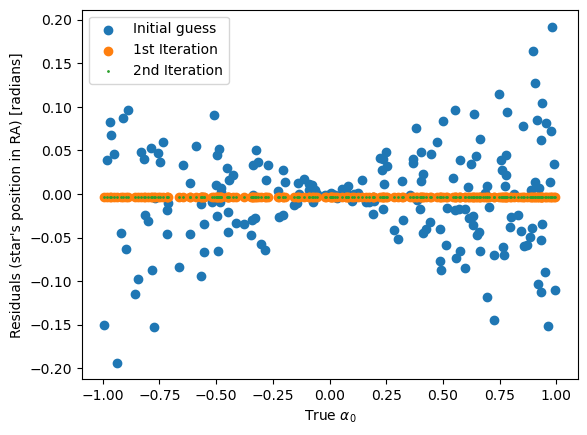

In [641]:
j = 0
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals (star's position in {}) [radians]".format("RA" if j==0 else "DEC"));

In [642]:
scipy.stats.describe(ehat2[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.003708506647403076, -0.003708488920278308), mean=-0.00370849773715784, variance=1.1418286898937656e-17, skewness=0.06409071024773494, kurtosis=-0.2524326849486562)

In [643]:
scipy.stats.describe(shat2[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.003701116100186197, -0.0037011033231706403), mean=-0.0037011101112327137, variance=4.549905018897872e-18, skewness=0.06819236221053578, kurtosis=0.5946031995292498)

In [644]:
scipy.stats.describe(ehat2[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-0.0094412432343568, -0.009441221826107071), mean=-0.009441232460858274, variance=1.1973615530484823e-17, skewness=0.02575561492579753, kurtosis=0.11225436925892529)

In [645]:
scipy.stats.describe(shat2[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.009422431351331917, -0.009422416952552193), mean=-0.009422425181021186, variance=5.2588089797958235e-18, skewness=0.18305284000767466, kurtosis=0.5121804865120176)

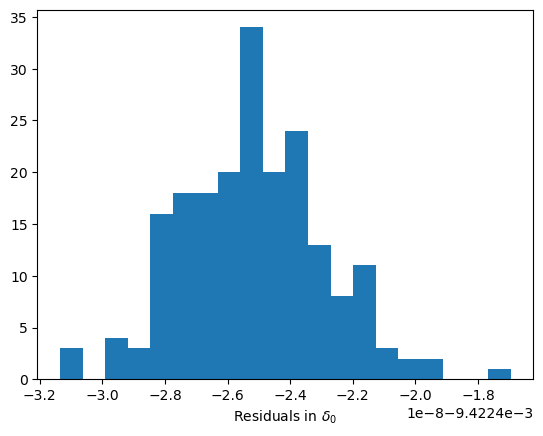

In [648]:
j = 1
#plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
#plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

#### Updating attitude first but using priors as first guess and then source

In [671]:
first_src_guess = np.column_stack((src[:,0],np.vstack(priors)))

In [672]:
%%time
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(first_src_guess,ehat,obs,sig_obs)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1,obs,sig_obs,priors,sig_prior)))

ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1,obs,sig_obs)))
shat2 = jnp.column_stack((shat[:,0],update_source(shat1,ehat2,obs,sig_obs,priors,sig_prior)))

CPU times: user 9.87 s, sys: 2.97 s, total: 12.8 s
Wall time: 9.68 s


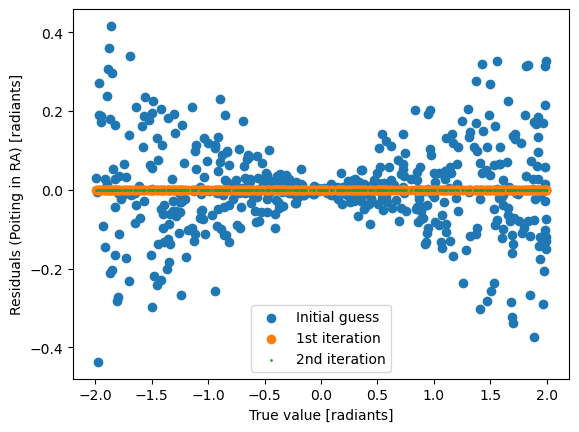

In [673]:
j = 0
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

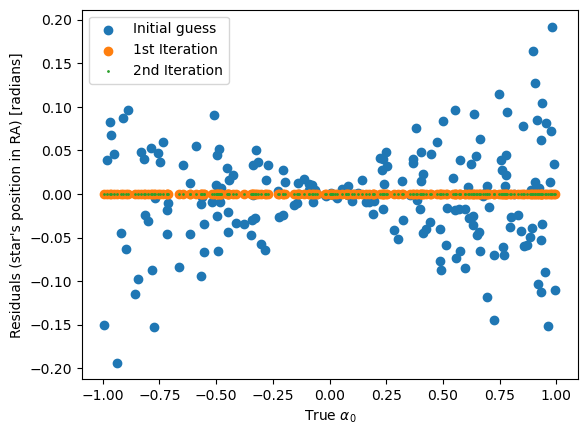

In [674]:
j = 0
plt.scatter(src[:,1+j],shat[:,1+j]-src[:,1+j],label="Initial guess")
plt.scatter(src[:,1+j],shat1[:,1+j]-src[:,1+j],label="1st Iteration")
plt.scatter(src[:,1+j],shat2[:,1+j]-src[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals (star's position in {}) [radians]".format("RA" if j==0 else "DEC"));

In [675]:
scipy.stats.describe(ehat2[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-1.1849300429744858e-08, 1.1007074141033968e-08), mean=9.512424402642079e-11, variance=1.1677524763608482e-17, skewness=-0.12661902383597162, kurtosis=0.22695219268058242)

In [676]:
scipy.stats.describe(shat2[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-5.299155447779924e-09, 5.067273600722899e-09), mean=-1.758778405628724e-10, variance=5.2143535206939926e-18, skewness=0.06651284035386337, kurtosis=-0.6676498650755565)

In [677]:
scipy.stats.describe(ehat2[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(-8.905830184424701e-09, 1.1566284152664252e-08), mean=1.6548944021496443e-09, variance=1.1502025076565409e-17, skewness=-0.11317619393854719, kurtosis=0.05676724883393325)

In [678]:
scipy.stats.describe(shat2[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-5.994874041626019e-09, 8.149506958154973e-09), mean=1.4187379236517547e-09, variance=4.91001350103677e-18, skewness=-0.055981406539481825, kurtosis=0.19602359587045637)

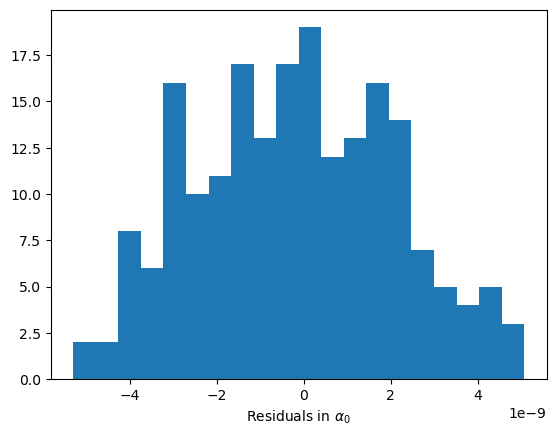

In [680]:
j = 0
#plt.hist(shat[:,1+j]-src[:,1+j],bins=20,label="Initial guess")
#plt.hist(shat1[:,1+j]-src[:,1+j],bins=20,label="1st Iteration")
plt.hist(shat2[:,1+j]-src[:,1+j],bins=20,label="2nd Iteration");

plt.xlabel("Residuals in {}".format([r"$\alpha_0$",r"$\delta_0$",r"$\mu_{\alpha_0}$",
                        r"$\mu_{\delta_0}$",r"$\varpi_0$"][j]));

## CHECK: can we rotate our results back into the right reference frame?

In [167]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
alpha0[0] = 0
delta0[0] = 0
alpha0[-1] = 0
delta0[-1] = np.pi/2

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)
pt_dec = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

In [168]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [169]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [170]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [171]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

In [172]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(-0.0030755423173265406, -0.0030755423173260965), mean=-0.0030755423173263025, variance=2.3708709190548354e-33, skewness=1.6870012418085294, kurtosis=12.247370148778359)

In [173]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(-0.0030755423173272067, -0.0030755423173257634), mean=-0.0030755423173263073, variance=3.8300712562800097e-32, skewness=-0.5565504544190027, kurtosis=3.0547210612003592)

In [174]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(0.0002234096064810398, 0.0002234096064814839), mean=0.00022340960648125117, variance=8.032434371290994e-34, skewness=-1.8972946638983894, kurtosis=22.78017725046701)

In [175]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(0.00022340960648081776, 0.00022340960648181696), mean=0.00022340960648123894, variance=2.3137651342505188e-32, skewness=0.08920073688739107, kurtosis=1.4087992041600712)

In [176]:
src[0]

Array([0., 0., 0.], dtype=float64)

In [177]:
shat1[0]

Array([ 0.        , -0.00307554,  0.00022341], dtype=float64)

In [178]:
src[-1]

Array([199.        ,   0.        ,   1.57079633], dtype=float64)

In [179]:
shat1[-1]

Array([ 1.99000000e+02, -3.07554232e-03,  1.57101974e+00], dtype=float64)

In [181]:
shat1[-1]-src[-1]

Array([ 0.        , -0.00307554,  0.00022341], dtype=float64)

### NOTE: because ALL points are displaced the same amount wrt to ICRS, there is no possible rotation that takes us from our solution's ref. frame back to ICRS

### A more realistic experiment: a patch of stars in a \pm1 degree around the centre of the MW. 

In [182]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.deg2rad(np.random.uniform(-1.0, 1.0, size=source_id.shape))
delta0 = np.deg2rad(np.random.uniform(-1.0, 1.0, size=source_id.shape))
alpha0[0] = 0
delta0[0] = 0
alpha0[-1] = 0
delta0[-1] = np.pi/2

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(np.random.uniform(-2.0, 2.0, size=exposure_id.shape))
pt_dec = np.deg2rad(np.random.uniform(-2.0, 2.0, size=exposure_id.shape))

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

In [183]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [184]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [185]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [186]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

In [187]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(3.1085070439314244e-05, 3.108507043932465e-05), mean=3.1085070439320316e-05, variance=1.2220913142308677e-36, skewness=-1.4862954330118714, kurtosis=4.954050224146492)

In [188]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(3.1085070439300366e-05, 3.108507043933159e-05), mean=3.108507043932002e-05, variance=1.0411707470303868e-35, skewness=-1.4506801779729173, kurtosis=9.415552629803868)

In [189]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_39729/4242913570.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  scipy.stats.describe(ehat1[:,3]-exp[:,3])
/Users/pauramos/miniconda3/envs/jasmine/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1383: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Users/pauramos/miniconda3/envs/jasmine/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1384: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


DescribeResult(nobs=501, minmax=(-0.0009213375644951741, -0.0009213375644951671), mean=-0.0009213375644951696, variance=1.6378162790006933e-36, skewness=0.5674957964315693, kurtosis=0.4351254303535015)

In [190]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(-0.0009213375644951845, -0.0009213375644943067), mean=-0.0009213375644951643, variance=3.737320900631705e-33, skewness=13.906343270917288, kurtosis=192.59186678366066)

In [191]:
src[0]

Array([0., 0., 0.], dtype=float64)

In [192]:
shat1[0]

Array([ 0.00000000e+00,  3.10850704e-05, -9.21337564e-04], dtype=float64)

In [193]:
src[-1]

Array([199.        ,   0.        ,   1.57079633], dtype=float64)

In [194]:
shat1[-1]

Array([1.99000000e+02, 3.10850704e-05, 1.56987499e+00], dtype=float64)

In [195]:
shat1[-1]-src[-1]

Array([ 0.00000000e+00,  3.10850704e-05, -9.21337564e-04], dtype=float64)

In arcseconds instead of radians:

In [198]:
print(shat1[0]*_radiants_to_mas/1000)

[   0.            6.41175603 -190.03951423]


### A more realistic experiment: a patch of stars in a \pm1 degree around the centre of the MW, but now the FoV stays within the patch

In [199]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
alpha0 = np.deg2rad(np.random.uniform(-1.0, 1.0, size=source_id.shape))
delta0 = np.deg2rad(np.random.uniform(-1.0, 1.0, size=source_id.shape))
alpha0[0] = 0
delta0[0] = 0
alpha0[-1] = 0
delta0[-1] = np.pi/2

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(np.random.uniform(-0.5, 0.5, size=exposure_id.shape))
pt_dec = np.deg2rad(np.random.uniform(-0.5, 0.5, size=exposure_id.shape))

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec]).T

In [200]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [201]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    eta_obs = exposure_eta(src[:, 1:], exp[:, 2:], exp[:, 1])
    zeta_obs = exposure_zeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    obs = jnp.hstack([eta_obs,zeta_obs])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    sid = jnp.tile(src[:, 0], 2*exp.shape[0])
    eid = jnp.repeat(exp[:, 0], src.shape[0])
    eid = jnp.hstack([eid,eid])
    axis = jnp.hstack([jnp.zeros(exp.shape[0]*src.shape[0]),jnp.ones(exp.shape[0]*src.shape[0])])
    return jnp.stack([sid, eid, axis, obs]).T

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [202]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [203]:
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
shat1 = jnp.column_stack((shat[:,0],update_source(shat,ehat1)))

In [204]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=501, minmax=(6.72515194403648e-05, 6.725151944036653e-05), mean=6.725151944036549e-05, variance=9.349404521860454e-38, skewness=-1.0721755999041382, kurtosis=1.4907079684461868)

In [205]:
scipy.stats.describe(shat1[:,1]-src[:,1])

DescribeResult(nobs=200, minmax=(6.725151944035092e-05, 6.725151944038908e-05), mean=6.725151944036535e-05, variance=1.2739863052545644e-35, skewness=1.1819215540205652, kurtosis=12.747248984670296)

In [206]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=501, minmax=(0.0001523012760785078, 0.00015230127607851127), mean=0.00015230127607850964, variance=2.7689797991175952e-37, skewness=0.004228125069939101, kurtosis=0.47364408862564567)

In [207]:
scipy.stats.describe(shat1[:,2]-src[:,2])

DescribeResult(nobs=200, minmax=(0.0001523012760784974, 0.00015230127607868127), mean=0.00015230127607851053, variance=1.6030387396172464e-34, skewness=12.342976536234715, kurtosis=164.0522891854605)

In arcseconds instead of radians:

In [213]:
print(shat1[0]*_radiants_to_mas/1000)

[ 0.         13.87162163 31.4143932 ]


### A more realistic experiment: two patches of stars (each of 0.5x0.5degs) around the MW, and the FoV stays within the patch

In [278]:
#old
pkey = jax.random.PRNGKey(42)

#field one
fov1_loc = (-0.5,0)
fov1_size = 0.5
source_id_0 = jnp.arange(100)
alpha0_0 = np.deg2rad(fov1_loc[0] + np.random.uniform(-fov1_size/2, fov1_size/2, size=source_id_0.shape))
delta0_0 = np.deg2rad(fov1_loc[1] + np.random.uniform(-fov1_size/2, fov1_size/2, size=source_id_0.shape))

exposure_id_0 = jnp.arange(250)
ep_0 = jnp.linspace(0,3, exposure_id_0.size)
pt_ra_0 = np.deg2rad(fov1_loc[0] + np.random.uniform(-fov1_size/4, fov1_size/4, size=exposure_id_0.shape))
pt_dec_0 = np.deg2rad(fov1_loc[1] + np.random.uniform(-fov1_size/4, fov1_size/4, size=exposure_id_0.shape))


#field two
fov2_loc = (+0.5,0)
fov2_size = 0.5
source_id_1 = source_id_0[-1]+1 + jnp.arange(100)
alpha0_1 = np.deg2rad(fov2_loc[0] + np.random.uniform(-fov2_size/2, fov2_size/2, size=source_id_1.shape))
delta0_1 = np.deg2rad(fov2_loc[1] + np.random.uniform(-fov2_size/2, fov2_size/2, size=source_id_1.shape))

exposure_id_1 = exposure_id_0[-1]+1 + jnp.arange(250)
ep_1 = jnp.linspace(0,3, exposure_id_1.size)
pt_ra_1 = np.deg2rad(fov2_loc[0] + np.random.uniform(-fov2_size/4, fov2_size/4, size=exposure_id_1.shape))
pt_dec_1 = np.deg2rad(fov2_loc[1] + np.random.uniform(-fov2_size/4, fov2_size/4, size=exposure_id_1.shape))

src_0 = jnp.stack([source_id_0, alpha0_0, delta0_0]).T
exp_0 = jnp.stack([exposure_id_0, ep_0, pt_ra_0,pt_dec_0]).T

src_1 = jnp.stack([source_id_1, alpha0_1, delta0_1]).T
exp_1 = jnp.stack([exposure_id_1, ep_1, pt_ra_1,pt_dec_1]).T

src = jnp.vstack((src_0,src_1))
exp = jnp.vstack((exp_0,exp_1))

In [529]:
pkey = jax.random.PRNGKey(42)

#simulate stars
sky_patch_size = 2
source_id = jnp.arange(1000)
alpha0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))
delta0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))

fovs = [
    [(-0.15,0),0.5,0,250],
    [(+0.15,0),0.5,0.1,250],
    [(0,-0.15),0.5,0.2,250],
    [(0,+0.15),0.5,0.3,250]
]

exps = []
last_exp_id = 0
for buffer in fovs:
    fov_loc,fov_size,delta_t,num_exp = buffer
    exposure_id_ = last_exp_id + jnp.arange(num_exp)
    ep_ = jnp.linspace(0,3, exposure_id_.size) + delta_t
    pt_ra_ = np.deg2rad(fov_loc[0] + np.random.uniform(-fov_size/4, fov_size/4, size=exposure_id_.shape))
    pt_dec_ = np.deg2rad(fov_loc[1] + np.random.uniform(-fov_size/4, fov_size/4, size=exposure_id_.shape))
    exp_ = jnp.stack([exposure_id_, ep_, pt_ra_,pt_dec_]).T
    exps.append(exp_)
    last_exp_id = exposure_id_[-1] + 1

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.vstack((exps))

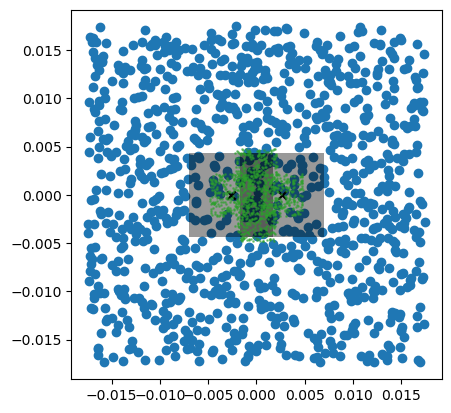

In [531]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
plt.scatter(src[:,1],src[:,2])
plt.scatter(np.deg2rad(fov1_loc[0]),np.deg2rad(fov1_loc[1]),marker="x",color="k")
plt.scatter(np.deg2rad(fov2_loc[0]),np.deg2rad(fov2_loc[1]),marker="x",color="k")
left, bottom, width, height = np.deg2rad(np.array([fov1_loc[0]-fov1_size/2, fov1_loc[1]-fov1_size/2,fov1_size,fov1_size]))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.4)
ax.add_patch(rect)
left, bottom, width, height = np.deg2rad(np.array([fov2_loc[0]-fov2_size/2, fov2_loc[1]-fov2_size/2,fov2_size,fov2_size]))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.4)
ax.add_patch(rect)
plt.scatter(exp[:,2],exp[:,3],c="tab:green",s=1,alpha=0.5,marker="o")
plt.gca().set_aspect("equal");

In [532]:
#initial guesses
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [533]:
exp_ = exp[0]

In [534]:
exp_

Array([ 0.       ,  0.       , -0.0031196, -0.0009253], dtype=float64)

In [535]:
FoV_size = np.deg2rad(0.5)
FoV_centre = exp_[2:]
sources = src[(np.abs(src[:,1]-FoV_centre[0])<FoV_size/2)&(np.abs(src[:,2]-FoV_centre[1])<FoV_size/2)]

In [536]:
len(sources)

50

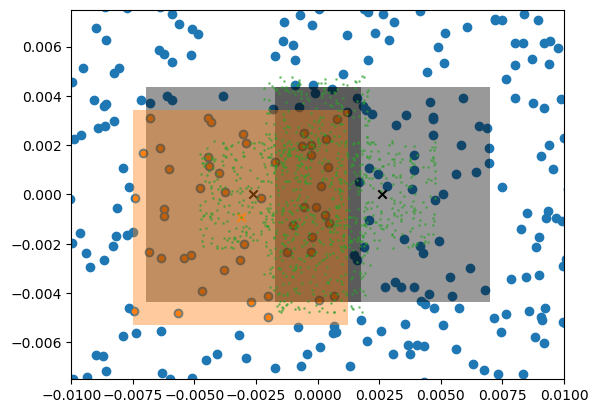

In [537]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
plt.scatter(src[:,1],src[:,2])
plt.scatter(sources[:,1],sources[:,2],color="tab:orange",s=10)
plt.scatter(np.deg2rad(fov1_loc[0]),np.deg2rad(fov1_loc[1]),marker="x",color="k")
plt.scatter(np.deg2rad(fov2_loc[0]),np.deg2rad(fov2_loc[1]),marker="x",color="k")
left, bottom, width, height = np.deg2rad(np.array([fov1_loc[0]-fov1_size/2, fov1_loc[1]-fov1_size/2,fov1_size,fov1_size]))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.4)
ax.add_patch(rect)
left, bottom, width, height = np.deg2rad(np.array([fov2_loc[0]-fov2_size/2, fov2_loc[1]-fov2_size/2,fov2_size,fov2_size]))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.4)
ax.add_patch(rect)



plt.scatter(exp[0,2],exp[0,3],marker="x",color="tab:orange")
left, bottom, width, height = (exp[0,2]-np.deg2rad(fov1_size/2), exp[0,3]-np.deg2rad(fov1_size/2),np.deg2rad(fov1_size),np.deg2rad(fov1_size))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="tab:orange", alpha=0.4)
ax.add_patch(rect)
plt.scatter(exp[:,2],exp[:,3],c="tab:green",s=1,alpha=0.5,marker="o")
plt.gca().set_aspect("equal");

plt.xlim(-0.01,0.01);
plt.ylim(-0.0075,0.0075);

In [538]:
_iterate_src_eta = jax.vmap(eta, (0, None, None), 0)
_iterate_exp_eta = jax.vmap(eta, (None, 0, 0), 0)
_iterate_full_eta = jax.vmap(_iterate_src_eta, (None, 0, 0), 0)
exposure_eta = lambda s, e, t: _iterate_full_eta(s, e, t).ravel()

_iterate_src_zeta = jax.vmap(zeta, (0, None, None), 0)
_iterate_exp_zeta = jax.vmap(zeta, (None, 0, 0), 0)
_iterate_full_zeta = jax.vmap(_iterate_src_zeta, (None, 0, 0), 0)
exposure_zeta = lambda s, e, t: _iterate_full_zeta(s, e, t).ravel()


def estimate(src, exp, noise=0.00,FoV_size=np.deg2rad(0.5)):
    ''' Generate the focal plane position from the parameters.
    For each exposure, look at which sources are within the FoV.
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    ids_ = []
    eta_obs = []
    zeta_obs = []
    for _exp in exp:
        #find sources within FoV
        FoV_centre = _exp[2:]
        sources = src[(np.abs(src[:,1]-FoV_centre[0])<FoV_size/2)&(np.abs(src[:,2]-FoV_centre[1])<FoV_size/2)]
        eta_obs.append(_iterate_src_eta(sources[:,1:],_exp[2:],_exp[1]))
        zeta_obs.append(_iterate_src_zeta(sources[:,1:],_exp[2:],_exp[1]))
        ids_.extend([(sid,_exp[0]) for sid in sources[:,0]])
    
    obs = np.hstack([np.hstack(eta_obs),np.hstack(zeta_obs)])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    axis = np.hstack([jnp.zeros(len(ids_)),jnp.ones(len(ids_))])
    ids_ = np.vstack([ids_,ids_]).astype(int)
    return np.column_stack((ids_,axis,obs))

sig_obs = 0
obs = estimate(src,exp,noise=0)

In [539]:
obs.shape

(117458, 4)

In [540]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None))

deds = jax.vmap(jax.grad(eta, argnums=(0)), (None, 0, 0))
dede = jax.vmap(jax.grad(eta, argnums=(1)), (0, None, None))

In [541]:
aux_df = pd.DataFrame(obs,columns=["sid","eid","axis","obs"])
grouped = aux_df.groupby("sid").count()

In [542]:
scipy.stats.describe(grouped["eid"].values)

DescribeResult(nobs=237, minmax=(4, 1784), mean=495.6033755274262, variance=251789.51998855753, skewness=1.0481242518123008, kurtosis=-0.02279666066966568)

In [543]:
sids_observed = aux_df.sid.values

In [545]:
grouped.loc[sids_observed[0]]

eid     740
axis    740
obs     740
Name: 20.0, dtype: int64

In [568]:
grouped.values[:,0]

array([ 442,  238,  740,  630,  170, 1040,  256,   94,   46, 1486,  404,
        970,  730, 1530,  212,   16, 1716, 1444,  228,  218,   74,  148,
       1574,  246,  188,   20,   24,  314,  128,  252,  566, 1622,   56,
        180,  634,   48,  240, 1122,  160,  176,  574,  524,  286,  478,
       1150,  228,  232,  670,  834,  238,  558,   44,  754, 1598,  582,
        954,  100,  884,  758,  514,   32,   66,   72,  712,  632,  788,
        140,  262,   46,  266,   82,   54,   50,  490,  244, 1464, 1772,
        698,   22,  104,  730,   88,  802,  586,  248,   52,  928,  184,
          4,   12,   10,  100,  188,  106,   20,  664, 1078,    6,    6,
       1784,  430,  162,  138,  452,  334,  986,  616, 1226,   38,  190,
        184,  272, 1716,    4,   40, 1550,  988,   44,   76, 1058,  210,
        392,  272,  678,    8,   88,  250,   66,  232, 1772,  408,    8,
        746,  180,  526,  176,  504,   26,  796,   64, 1372,   94, 1308,
        112,  292,  930, 1406,  320,  238,  950,   

In [546]:
observations = obs[obs[:, 0] == sids_observed[0]]
indices = [i for i,exp_id in enumerate(exp[:,0]) if exp_id in observations[:,1]]
exposures = exp[np.array(indices)]

In [547]:
exposures.shape

(370, 4)

In [548]:
def update_source_inner(src, exp, obs):

    #locate observations related to this source id
    observations = obs[obs[:, 0] == src[0]]
    #locate the parameters of the exposures when this source id was observed
    indices = [i for i,exp_id in enumerate(exp[:,0]) if exp_id in observations[:,1]]
    exposures = exp[jnp.array(indices)]
    
    c_eta = _iterate_exp_eta(src[1:],exposures[:,2:],exposures[:,1])
    o_eta = observations[observations[:,2]==0][:, 3]
    
    c_zeta = _iterate_exp_zeta(src[1:],exposures[:,2:],exposures[:,1])
    o_zeta = observations[observations[:,2]==0][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    Ds = np.vstack([deds(src[1:], exposures[:, 2:], exposures[:, 1]),
                    dzds(src[1:], exposures[:, 2:], exposures[:, 1])])

    
    
    N = Ds.T @ Ds
    b = Ds.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp, obs):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp, obs) for _ in src])

In [549]:
def update_exposure_inner(src, exp, obs):

    #locate all observations of the sources observed at this exposure
    observations = obs[obs[:, 1] == exp[0]]
    #locate the parameters of the sources observed
    indices = [i for i,sid in enumerate(src[:,0]) if sid in observations[:,0]]
    sources = src[jnp.array(indices)]
    
    c_eta = _iterate_src_eta(sources[:,1:], exp[2:],exp[1])
    o_eta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==0)][:, 3]
    
    c_zeta = _iterate_src_zeta(sources[:,1:], exp[2:],exp[1])
    o_zeta = obs[(obs[:, 1] == exp[0])&(obs[:,2]==1)][:, 3]

    o = jnp.hstack([o_eta,o_zeta])
    c = jnp.hstack([c_eta,c_zeta])
    
    De = np.vstack([dede(sources[:,1:], exp[2:], exp[1]),
                    dzde(sources[:,1:], exp[2:], exp[1])])

    
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp, obs):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _, obs) for _ in exp])

In [550]:
src_obs = src[np.array([i for i,sid in enumerate(src[:,0]) if sid in sids_observed])]

In [551]:
shat_obs = shat[np.array([i for i,sid in enumerate(shat[:,0]) if sid in sids_observed])]

In [552]:
observations = obs[obs[:, 1] == exp[0][0]]

In [553]:
observations.shape

(100, 4)

In [554]:
indices = [i for i,sid in enumerate(shat_obs[:,0]) if sid in observations[:,0]]

In [555]:
len(indices)

50

In [556]:
%%time
ehat1 = jnp.column_stack((ehat[:,:2],update_exposure(shat_obs,ehat,obs)))
shat1 = jnp.column_stack((shat_obs[:,0],update_source(shat_obs,ehat1,obs)))

CPU times: user 43.7 s, sys: 1.49 s, total: 45.2 s
Wall time: 45.5 s


In [557]:
%%time
ehat2 = jnp.column_stack((ehat[:,:2],update_exposure(shat1,ehat1,obs)))
shat2 = jnp.column_stack((shat_obs[:,0],update_source(shat1,ehat2,obs)))

CPU times: user 15 s, sys: 360 ms, total: 15.4 s
Wall time: 15.4 s


In [507]:
scipy.stats.describe(ehat1[:,2]-exp[:,2])

DescribeResult(nobs=1000, minmax=(-0.00423368308761712, 0.006042955602352138), mean=0.00036044501663973374, variance=9.153260768554304e-06, skewness=0.13284596213833902, kurtosis=-1.518228847364111)

In [510]:
scipy.stats.describe(shat1[:,1]-src_obs[:,1])

DescribeResult(nobs=189, minmax=(-0.003759782409856505, 0.004977936855156347), mean=0.00042876626170236477, variance=7.295227924430925e-06, skewness=0.04468277628441282, kurtosis=-1.4997993314478737)

In [511]:
scipy.stats.describe(ehat1[:,3]-exp[:,3])

DescribeResult(nobs=1000, minmax=(-0.0034097122034622636, 0.0033586341565005296), mean=0.0001694284873540489, variance=2.720656525878577e-06, skewness=0.16518483429492334, kurtosis=-1.0690797979669449)

In [512]:
scipy.stats.describe(shat1[:,2]-src_obs[:,2])

DescribeResult(nobs=189, minmax=(-0.007548336977060437, 0.00846406699128563), mean=6.71060331711509e-05, variance=1.2322797603029588e-05, skewness=0.07880408102078887, kurtosis=-0.9287914651642044)

In arcseconds instead of radians:

In [514]:
print(shat1[0][1:]*_radiants_to_mas/1000)

[-509.40142919 -261.78843843]


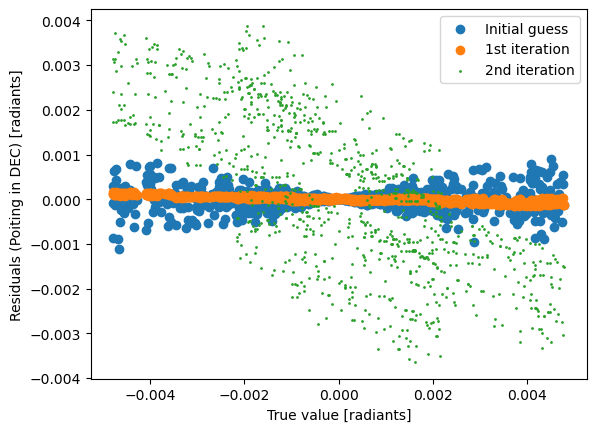

In [565]:
j = 1
plt.scatter(exp[:,2+j],ehat[:,2+j]-exp[:,2+j],label="Initial guess")
plt.scatter(exp[:,2+j],ehat1[:,2+j]-exp[:,2+j],label="1st iteration")
plt.scatter(exp[:,2+j],ehat2[:,2+j]-exp[:,2+j],label="2nd iteration",s=1)
if j==0:
    plt.ylabel("Residuals (Poiting in RA) [radiants]")
elif j==1:
    plt.ylabel("Residuals (Poiting in DEC) [radiants]")
plt.xlabel("True value [radiants]")
plt.legend();

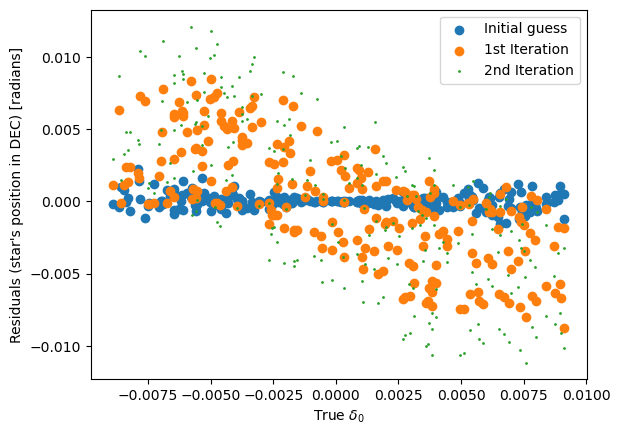

In [564]:
j = 1
plt.scatter(src_obs[:,1+j],shat_obs[:,1+j]-src_obs[:,1+j],label="Initial guess")
plt.scatter(src_obs[:,1+j],shat1[:,1+j]-src_obs[:,1+j],label="1st Iteration")
plt.scatter(src_obs[:,1+j],shat2[:,1+j]-src_obs[:,1+j],label="2nd Iteration",s=1)
plt.legend()

plt.xlabel("{}".format([r"True $\alpha_0$",r"True $\delta_0$",r"True $\mu_{\alpha_0}$",
                        r"True $\mu_{\delta_0}$",r"True $\varpi_0$"][j]));
plt.ylabel("Residuals (star's position in {}) [radians]".format("RA" if j==0 else "DEC"));

## Simple model (attitude is now a rotation)

In [683]:
import numpy as np
from scipy.spatial.transform import Rotation as R

In [971]:
from astropy.coordinates import SkyCoord,ICRS,Galactic,HeliocentricTrueEcliptic,GeocentricMeanEcliptic
import astropy.units as units

In [1122]:
def _comrs2fovrs_fromquat(phi_c,lambda_c,rx_at,ry_at,angle_at):#,parallax,pmra,pmdec
    """
    This function accounts for the astrometric attitude 
    at each exposure and consists of a rotation.

    Input:
        - phi_c: longitude in CoMRS (in radiant)
        - lambda_c: latitude in CoMRS (in radiant)
        - rx_at: first component of the rotation axis
        - ry_at: second component of the rotation axis
        - angle_at: TOTAL rotation angle (in radiant)

    Output:
        - eta: longitude in FoVRS (in radiant)
        - zeta: latitude in FoVRS (in radiant)

    NOTE: the third component of the rotation axis, 
    rz_at, is calculated on the fly to impose that the
    quaternion has module 1.
    """
    #compute the third component of the rotation axis imposing modulus 1
    if (rx_at**2+ry_at**2)>1:
        #To-Do: either FIX THIS or constrain the gradient descent
        raise ValueError("There is an issue with your definition of quaternion.")
    rz_at = np.sqrt(1-rx_at**2-ry_at**2)

    #construct the rotator (FOR NOW, WE RELY ON SCIPY)
        #A) since we already ensured that the modulus is one, the inverse is the conjugate
        #B) we divide the angle by 2 because this way of rotating produces a rotation
        #of twice the angle procured
    q_inv = R.from_quat([-rx_at*np.sin(angle_at/2),
                         -ry_at*np.sin(angle_at/2),
                         -rz_at*np.sin(angle_at/2),
                         np.cos(angle_at/2)])

    #construct the vector to be rotated
    v = np.array([np.cos(phi_c)*np.cos(lambda_c),
                  np.sin(phi_c)*np.cos(lambda_c),
                  np.sin(lambda_c)])

    #rotate
    u = q_inv.apply(v)

    #obtain new angles
        #NOTE: we can safely use arctan2 like this because 
        # latitude is always between -Pi/2 and Pi/2 and
        # thus its cosine is always positive
        #NOTE2: this will return angles between -Pi and Pi
    eta = np.arctan2(u[1],u[0])
    zeta = np.arcsin(u[2])
        #TO-DO: rotate proper motions as well

    return eta,zeta


def _comrs2fovrs(phi_c,lambda_c,pt_ra,pt_dec,pt_rot):
    """
    This function accounts for the astrometric attitude 
    at each exposure and consists of a rotation.

    Input:
        - phi_c: longitude in CoMRS (in radiant)
        - lambda_c: latitude in CoMRS (in radiant)
        - pt_ra: right ascension of the centre of the FoV (in radiant)
        - pt_dec: declination of the centre of the FoV (in radiant)
        - pt_rot: TOTAL rotation angle, counter-clockwise (in radiant)

    Output:
        - eta: longitude in FoVRS (in radiant)
        - zeta: latitude in FoVRS (in radiant)
        
        #rotation matrix
    rot = np.array([[ca*cd,-sa*cr+ca*sd*sr,sa*sr+ca*sd*cr],
                     [sa*cd,ca*cr+sa*sd*sr,-ca*sr+sa*sd*cr],
                     [-sd,cd*sr,cd*cr]])
    rot_trans = np.array([[ca*cd,sa*cd,-sd],
                     [-sa*cr+ca*sd*sr,ca*cr+sa*sd*sr,cd*sr],
                     [sa*sr+ca*sd*cr,-ca*sr+sa*sd*cr,cd*cr]])
    
        #vector to rotate (in CoMRS)
    v = np.array([np.cos(phi_c)*np.cos(lambda_c),
                  np.sin(phi_c)*np.cos(lambda_c),
                  np.sin(lambda_c)])
    """
    #trigonometry
    ca = np.cos(pt_ra)
    sa = np.sin(pt_ra)
    cd = np.cos(-pt_dec)
    sd = np.sin(-pt_dec)
    cr = np.cos(pt_rot)
    sr = np.sin(pt_rot)
    cp = np.cos(phi_c)
    sp = np.sin(phi_c)
    cl = np.cos(lambda_c)
    sl = np.sin(lambda_c)
    #rotated vector
    u0 = cp*cl*ca*cd + sp*cl*sa*cd - sl*sd
    u1 = cp*cl*(ca*sd*sr-sa*cr) + sp*cl*(ca*cr+sa*sd*sr) + sl*cd*sr
    u2 = cp*cl*(sa*sr+ca*sd*cr) + sp*cl*(sa*sd*cr-ca*sr) + sl*cd*cr

    #obtain new angles
        #NOTE: we can safely use arctan2 like this because 
        # latitude is always between -Pi/2 and Pi/2 and
        # thus its cosine is always positive
        #NOTE2: this will return angles between -Pi and Pi
    eta = np.arctan2(u1,u0)
    zeta = np.arcsin(u2)

        #TO-DO: rotate proper motions as well
    return eta,zeta

In [1123]:
def quadconjugate(q):
    return np.array([-q[0],-q[1],-q[2],q[3]])

def quadquad_product(q,p):
    ans = np.zeros_like(q)
    ans[:-1] = q[-1]*p[:-1] + p[-1]*q[:-1] + np.cross(q[:-1],p[:-1])
    ans[-1] = q[-1]*p[-1] - np.dot(q[:-1],p[:-1])
    return ans

def quadvec_product(q,v):
    ans = np.zeros_like(q)
    ans[:-1] = q[-1]*v + np.cross(q[:-1],v)
    ans[-1] = - np.dot(q[:-1],v)
    return ans


def transform_pointing_to_rotation(pt_ra,pt_dec,pt_rot):
    rot1 = R.from_quat([0,
                        0,
                         -np.sin(pt_ra/2),
                         np.cos(pt_ra/2)])
    rot2 = R.from_quat([0,
                        np.sin(pt_dec/2),
                        0,
                         np.cos(pt_dec/2)])

    rot3 = R.from_quat([-np.sin(pt_rot/2),
                        0,
                        0,
                         np.cos(pt_rot/2)])

    return rot1,rot2,rot3

def transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot):
    """
    The resulting matrix R, when applied to a vector as R.T@u, returns
    the representation of that same vector u as seens from another
    reference frame rotated with respect to the one "u" was expressed in.
    
    - pt_ra: radians (if >0, to the east) that we have rotated along longitude.
    - pt_dec: radians (if >0, to the north) that we have rotated along latitude.
    - pt_rot: radians (if >0, counter clockwise) that we have rotated along the line of sight.
    """
    ca = np.cos(pt_ra)
    sa = np.sin(pt_ra)
    cd = np.cos(-pt_dec)
    sd = np.sin(-pt_dec)
    cr = np.cos(pt_rot)
    sr = np.sin(pt_rot)
    return np.array([[ca*cd,-sa*cr+ca*sd*sr,sa*sr+ca*sd*cr],
                     [sa*cd,ca*cr+sa*sd*sr,-ca*sr+sa*sd*cr],
                     [-sd,cd*sr,cd*cr]])

def transform_pointing_to_rotation_quat(pt_ra,pt_dec,pt_rot):
    """
    The resulting unitary quaternion q, when applied to a vector as q*.u.q, returns
    the representation of that same vector u as seens from another
    reference frame rotated with respect to the one "u" was expressed in.
    
    - pt_ra: radians (if >0, to the east) that we have rotated along longitude.
    - pt_dec: radians (if >0, to the north) that we have rotated along latitude.
    - pt_rot: radians (if >0, counter clockwise) that we have rotated along the line of sight.
    """
    ca = np.cos(pt_ra)
    sa = np.sin(pt_ra)
    cd = np.cos(-pt_dec)
    sd = np.sin(-pt_dec)
    cr = np.cos(pt_rot)
    sr = np.sin(pt_rot)
    q = np.array([-sa*sd*cr+sr*(ca+cd),
                     +sd*(1+ca*cr)+sa*sr,
                    +sa*(cd+cr)-ca*sd*sr,
                    1+ca*cd+ca*cr+cd*cr+sa*sd*sr])

    qnorm = np.sqrt(np.sum(q**2))
    return q/qnorm

def quaternion2rotmat(qi,qj,qk,qr):
    return np.array([[1-2*(qj**2+qk**2),2*(qi*qj-qk*qr),2*(qi*qk+qj*qr)],
                    [2*(qi*qj+qk*qr),1-2*(qi**2+qk**2),2*(qj*qk-qi*qr)],
                    [2*(qi*qk-qj*qr),2*(qj*qk+qi*qr),1-2*(qi**2+qj**2)]])

def rotmat2quaternion(mat):
    q = np.array([mat[2,1]-mat[1,2],mat[0,2]-mat[2,0],mat[1,0]-mat[0,1],1+np.sum(np.diag(mat))])
    qnorm = np.sqrt(np.sum(q**2))
    return q/qnorm

def extract_angles_from_vector(u):
    lon = np.arctan2(u[1],u[0])
    lat = np.arcsin(u[2])
    return lon,lat

In [1030]:
phi = (np.pi/6)/2

q = np.array([0,0, np.sin(phi),np.cos(phi)])
qinv = -q
qinv[-1] = q[-1]
v = np.array([1,0,0])


print(quadquad_product(quadvec_product(q,v),qinv))
print(quaternion2rotmat(*q)@v)

[ 0.8660254  0.5        0.        -0.       ]
[0.8660254 0.5       0.       ]


In [1031]:
pt_ra = 0#np.pi/3
pt_dec = 0#np.pi/3
pt_rot = np.deg2rad(23.4)

rot1,rot2,rot3 = transform_pointing_to_rotation(pt_ra,pt_dec,pt_rot)#(0,0,np.pi/4)
rot = transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot)
q = transform_pointing_to_rotation_quat(pt_ra,pt_dec,pt_rot)

In [1032]:
print(q, R.from_matrix(rot).as_quat())

[0.2027873  0.         0.         0.97922281] [0.2027873  0.         0.         0.97922281]


In [1033]:
quadquad_product(quadvec_product(quadconjugate(q),np.array([1,0,0])),q)

array([1., 0., 0., 0.])

In [1034]:
rot.T@np.array([1,0,0])

array([1., 0., 0.])

In [1035]:
""" Ecliptic """
pt_ra = 0#np.pi/3
pt_dec = 0#np.pi/3
pt_rot = np.deg2rad(23.4)
rot = transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot)

print("[0,0] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([1,0,0]))))
print("[0,90] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([0,0,1]))))


ra = np.deg2rad(33)
dec = np.deg2rad(-21)
print("[33,-21] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([np.cos(ra)*np.cos(dec),
                                                                           np.sin(ra)*np.cos(dec),
                                                                           np.sin(dec)]))))

[0,0] =>  [0. 0.]
[0,90] =>  [90.  66.6]
[33,-21] =>  [ 22.50031945 -32.06151014]


In [1036]:
c = SkyCoord(ra=0*units.degree,dec=0*units.degree)
c.transform_to(GeocentricMeanEcliptic)

<SkyCoord (GeocentricMeanEcliptic: equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, )
    (359.99895548, -5.84474624e-06, 1.)>

In [1037]:
c = SkyCoord(ra=0*units.degree,dec=90*units.degree)
c.transform_to(GeocentricMeanEcliptic)

<SkyCoord (GeocentricMeanEcliptic: equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, )
    (90.01430002, 66.56167855, 1.)>

In [1038]:
c = SkyCoord(ra=33*units.degree,dec=-21*units.degree)
c.transform_to(GeocentricMeanEcliptic)

<SkyCoord (GeocentricMeanEcliptic: equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, )
    (22.47900993, -32.07954692, 1.)>

In [993]:
# ICRS to Galactic rotation matrix
Ag = np.array([[-0.054875560416215368492398900454,+0.494109427875583673525222371358,-0.867666149019004701181616534570],
                 [-0.873437090234885048760383168409,-0.444829629960011178146614061616,-0.198076373431201528180486091412],
                 [-0.483835015548713226831774175116,+0.746982244497218890527388004556,+0.455983776175066922272100478348]])

In [1006]:
def target_func(x):
    rot = transform_pointing_to_rotation_matrix(*x)
    return np.sum((rot-Ag)**2)

In [1009]:
scipy.optimize.minimize(target_func,(0,0,0))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.6506994636206528e-14
        x: [-1.634e+00  5.050e-01  1.023e+00]
      nit: 10
      jac: [-2.960e-07  9.195e-08  5.738e-08]
 hess_inv: [[ 3.434e-01 -4.459e-03  1.634e-01]
            [-4.459e-03  2.512e-01 -1.410e-03]
            [ 1.634e-01 -1.410e-03  3.281e-01]]
     nfev: 48
     njev: 12

In [1140]:
""" Galactic """
pt_ra = np.deg2rad(266.40498829)#-1.634#np.deg2rad(-96)#np.pi/3
pt_dec = np.deg2rad(-28.93617776)#np.deg2rad(90-27.12)#np.pi/3
pt_rot = 1.023#np.deg2rad(23.4)
rot = transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot)
#rot = Ag
print("[0,0] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([1,0,0]))))
print("[0,90] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([0,0,1]))))


ra = np.deg2rad(33)
dec = np.deg2rad(-21)
print("[33,-21] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([np.cos(ra)*np.cos(dec),
                                                                           np.sin(ra)*np.cos(dec),
                                                                           np.sin(dec)]))))

ra = pt_ra
dec = pt_dec
print("[ra0,dec0] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([np.cos(ra)*np.cos(dec),
                                                                           np.sin(ra)*np.cos(dec),
                                                                           np.sin(dec)]))))

ra = np.deg2rad(266)
dec = np.deg2rad(-28)
print("[33,-21] => ",np.rad2deg(extract_angles_from_vector(rot.T@np.array([np.cos(ra)*np.cos(dec),
                                                                           np.sin(ra)*np.cos(dec),
                                                                           np.sin(dec)]))))

[0,0] =>  [ 96.34015923 -60.20338103]
[0,90] =>  [122.92777079  27.11572926]
[33,-21] =>  [-161.1244864   -70.63930473]
[ra0,dec0] =>  [ 4.76216102e-17 -1.36036187e-16]
[33,-21] =>  [0.61247308 0.79251056]


In [1141]:
_comrs2fovrs(np.deg2rad(266),np.deg2rad(-28),np.deg2rad(266.40498829),np.deg2rad(-28.93617776),1.023)

(Array(-1.86485741, dtype=float64), Array(-0.25602995, dtype=float64))

In [1044]:
print(np.rad2deg(pt_ra),np.rad2deg(pt_dec),np.rad2deg(pt_rot))

266.40498829 -28.936177760000003 58.61358244188321


In [1025]:
SkyCoord(l=0*units.degree,b=0*units.degree,frame=Galactic).transform_to(ICRS)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>

In [984]:
c = SkyCoord(ra=0*units.degree,dec=0*units.degree)
c.transform_to(Galactic)

<SkyCoord (Galactic): (l, b) in deg
    (96.33728337, -60.18855195)>

In [985]:
c = SkyCoord(ra=0*units.degree,dec=90*units.degree)
c.transform_to(Galactic)

<SkyCoord (Galactic): (l, b) in deg
    (122.93192526, 27.12825241)>

In [979]:
c = SkyCoord(ra=33*units.degree,dec=-21*units.degree)
c.transform_to(Galactic)

<SkyCoord (Galactic): (l, b) in deg
    (198.83532535, -70.64412669)>

In [1046]:
198.835-360

-161.165

### Testing the rotation and comparing it to simple subtraction

In [1151]:
mock_stars = SkyCoord(ra=(2+np.random.uniform(-1,1,1000))*u.degree,
                      dec=(1+np.random.uniform(-1,1,1000))*u.degree,frame=ICRS)

mock_stars = SkyCoord(l=(np.random.uniform(-1,1,1000))*u.degree,
                      b=(np.random.uniform(-1,1,1000))*u.degree,frame=Galactic).transform_to(ICRS)

ra_stars = mock_stars.ra.to(units.radian).value
dec_stars = mock_stars.dec.to(units.radian).value

pt_ra = np.deg2rad(266)
pt_dec = np.deg2rad(-28)
pt_rot = 1.0

vecICRS_stars = [np.array([np.cos(ra)*np.cos(dec_stars[i]),np.sin(ra)*np.cos(dec_stars[i]),np.sin(dec_stars[i])]) \
             for i,ra in enumerate(ra_stars)]

rot = transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot)
vecFoVRS_stars = [rot.T@v for v in vecICRS_stars]
etazeta = np.array([extract_angles_from_vector(v) for v in vecFoVRS_stars])

etazeta_check =  np.array([_comrs2fovrs(ra,dec_stars[i],pt_ra,pt_dec,pt_rot) for i,ra in enumerate(ra_stars)])

In [1152]:
scipy.stats.describe(etazeta-etazeta_check)

DescribeResult(nobs=1000, minmax=(array([-9.02056208e-17, -5.55111512e-17]), array([1.16226473e-16, 5.20417043e-17])), mean=array([ 1.40404723e-17, -1.61481876e-18]), variance=array([1.30857860e-33, 3.50572793e-34]), skewness=array([0.01794674, 0.02670745]), kurtosis=array([0.24115478, 0.11164352]))

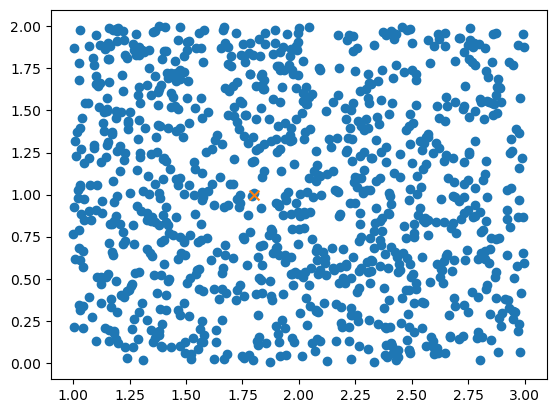

In [1105]:
plt.scatter(np.rad2deg(ra_stars),np.rad2deg(dec_stars))
plt.scatter(np.rad2deg(pt_ra),np.rad2deg(pt_dec),marker="x",color="tab:orange",s=50)

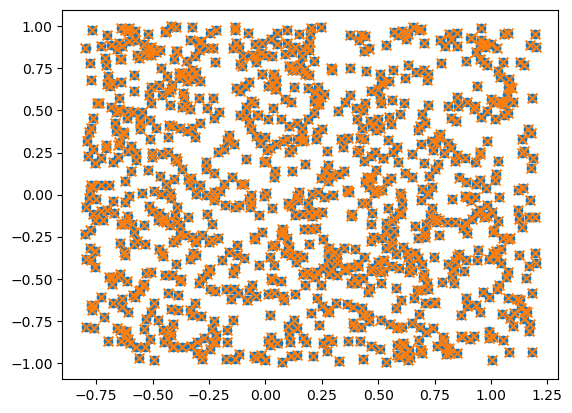

In [1106]:
plt.scatter(np.rad2deg(etazeta[:,0]),np.rad2deg(etazeta[:,1]))
plt.scatter(np.rad2deg(ra_stars-pt_ra),np.rad2deg(dec_stars-pt_dec),marker="x",color="tab:orange",s=50)

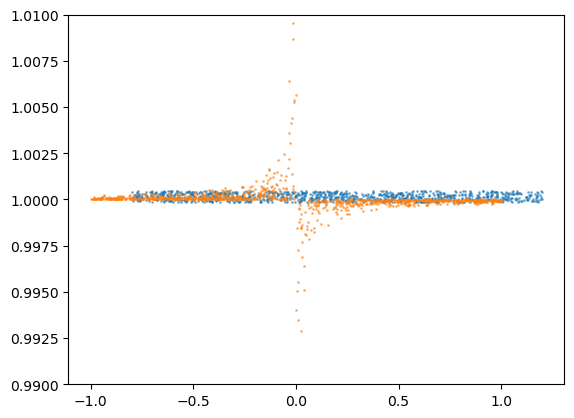

In [1110]:
plt.scatter(np.rad2deg(etazeta[:,0]),(ra_stars-pt_ra)/etazeta[:,0],s=1,alpha=0.5)

plt.scatter(np.rad2deg(etazeta[:,1]),(dec_stars-pt_dec)/etazeta[:,1],s=1,alpha=0.5)
plt.ylim(0.99,1.01);

In [1075]:
mock_stars = SkyCoord(l=np.random.uniform(-1,1,1000)*u.degree,
                      b=np.random.uniform(-1,1,1000)*u.degree,frame=Galactic).transform_to(ICRS)

ra_stars = mock_stars.ra.to(units.radian).value
dec_stars = mock_stars.dec.to(units.radian).value

pt_ra = np.deg2rad(266)
pt_dec = np.deg2rad(-29)
pt_rot = 0#1.0

vecICRS_stars = [np.array([np.cos(ra)*np.cos(dec_stars[i]),np.sin(ra)*np.cos(dec_stars[i]),np.sin(dec_stars[i])]) \
             for i,ra in enumerate(ra_stars)]

rot = transform_pointing_to_rotation_matrix(pt_ra,pt_dec,pt_rot)
vecFoVRS_stars = [rot.T@v for v in vecICRS_stars]
etazeta = np.array([extract_angles_from_vector(v) for v in vecFoVRS_stars])

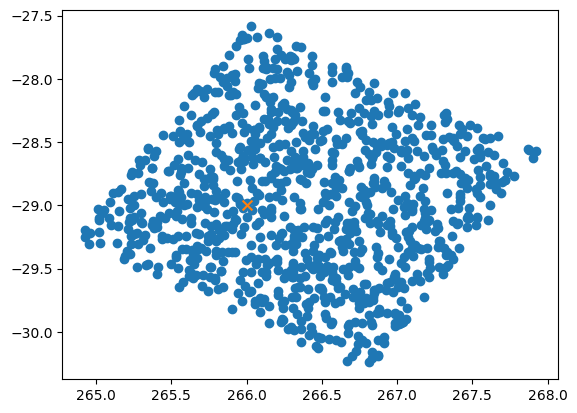

In [1076]:
plt.scatter(np.rad2deg(ra_stars),np.rad2deg(dec_stars))
plt.scatter(np.rad2deg(pt_ra),np.rad2deg(pt_dec),marker="x",color="tab:orange",s=50)

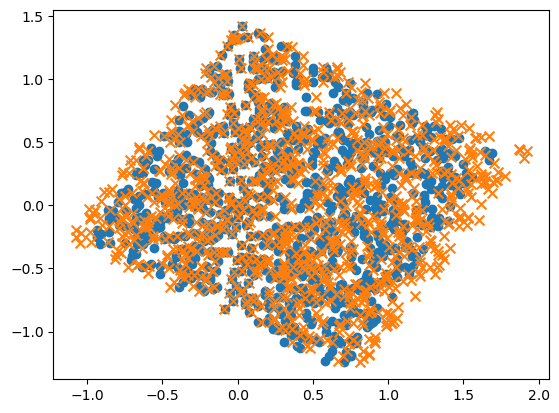

In [1077]:
plt.scatter(np.rad2deg(etazeta[:,0]),np.rad2deg(etazeta[:,1]))
plt.scatter(np.rad2deg(ra_stars-pt_ra),np.rad2deg(dec_stars-pt_dec),marker="x",color="tab:orange",s=50)

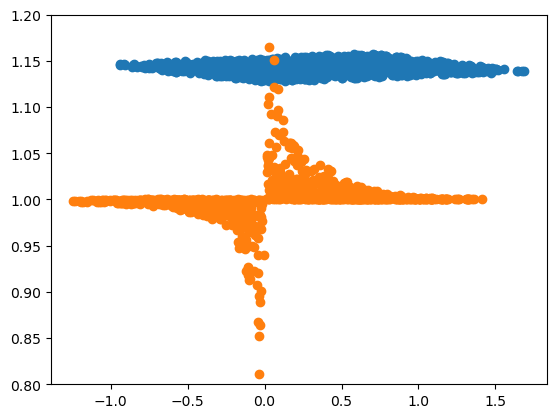

In [1082]:
plt.scatter(np.rad2deg(etazeta[:,0]),(ra_stars-pt_ra)/etazeta[:,0])

plt.scatter(np.rad2deg(etazeta[:,1]),(dec_stars-pt_dec)/etazeta[:,1])
plt.ylim(0.8,1.2);

### Test JAX's Jacobean

In [1186]:
def _comrs2fovrs(phi_c,lambda_c,pt_ra,pt_dec,pt_rot,time):
    """
    This function accounts for the astrometric attitude 
    at each exposure and consists of a rotation.

    Input:
        - phi_c: longitude in CoMRS (in radiant)
        - lambda_c: latitude in CoMRS (in radiant)
        - pt_ra: right ascension of the centre of the FoV (in radiant)
        - pt_dec: declination of the centre of the FoV (in radiant)
        - pt_rot: TOTAL rotation angle, counter-clockwise (in radiant)

    Output:
        - eta: longitude in FoVRS (in radiant)
        - zeta: latitude in FoVRS (in radiant)
        
        #rotation matrix
    rot = np.array([[ca*cd,-sa*cr+ca*sd*sr,sa*sr+ca*sd*cr],
                     [sa*cd,ca*cr+sa*sd*sr,-ca*sr+sa*sd*cr],
                     [-sd,cd*sr,cd*cr]])
    rot_trans = np.array([[ca*cd,sa*cd,-sd],
                     [-sa*cr+ca*sd*sr,ca*cr+sa*sd*sr,cd*sr],
                     [sa*sr+ca*sd*cr,-ca*sr+sa*sd*cr,cd*cr]])
    
        #vector to rotate (in CoMRS)
    v = np.array([np.cos(phi_c)*np.cos(lambda_c),
                  np.sin(phi_c)*np.cos(lambda_c),
                  np.sin(lambda_c)])
    """
    #trigonometry
    ca = jnp.cos(pt_ra)
    sa = jnp.sin(pt_ra)
    cd = jnp.cos(-pt_dec)
    sd = jnp.sin(-pt_dec)
    cr = jnp.cos(pt_rot)
    sr = jnp.sin(pt_rot)
    cp = jnp.cos(phi_c)
    sp = jnp.sin(phi_c)
    cl = jnp.cos(lambda_c)
    sl = jnp.sin(lambda_c)
    #rotated vector
    u0 = cp*cl*ca*cd + sp*cl*sa*cd - sl*sd
    u1 = cp*cl*(ca*sd*sr-sa*cr) + sp*cl*(ca*cr+sa*sd*sr) + sl*cd*sr
    u2 = cp*cl*(sa*sr+ca*sd*cr) + sp*cl*(sa*sd*cr-ca*sr) + sl*cd*cr

    #obtain new angles
        #NOTE: we can safely use arctan2 like this because 
        # latitude is always between -Pi/2 and Pi/2 and
        # thus its cosine is always positive
        #NOTE2: this will return angles between -Pi and Pi
    eta = jnp.arctan2(u1,u0)
    zeta = jnp.arcsin(u2)

        #TO-DO: rotate proper motions as well
    return eta,zeta

In [1309]:
def forwardmodelling(src,exp,time):
    return _comrs2fovrs(src[0],src[1],exp[0],exp[1],exp[2],time)

In [1386]:
def forwardmodelling(src,exp,time):
    return jnp.asarray(_comrs2fovrs(src[0],src[1],exp[0],exp[1],exp[2],time))

In [1387]:
etazeta = jax.jit(lambda s,e,t: forwardmodelling(s,e,t))

In [1532]:
pkey = jax.random.PRNGKey(42)
alpha00 = 0#266.4
delta00 = 0#-28.9
pt_ra0 = 0#266.40498829
pt_dec0 = 0#-28.93617776
pt_rot0 = 0#58.61

source_id = jnp.arange(200)
alpha0 = np.deg2rad(alpha00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.deg2rad(delta00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(pt_ra0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_dec = np.deg2rad(pt_dec0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_rot = np.deg2rad(pt_rot0) + np.random.uniform(-0.1,0.1, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec,pt_rot]).T

In [1533]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [1534]:
_iterate_src_etazeta = jax.vmap(etazeta, (0, None, None), 0)
_iterate_exp_etazeta = jax.vmap(etazeta, (None, 0, 0), 0)
_iterate_full_etazeta = jax.vmap(_iterate_exp_etazeta, (0, None,None), 0)
exposure_etazeta = lambda s, e, t: np.hstack(np.vstack(_iterate_full_etazeta(s, e, t)))


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    obs = exposure_etazeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids_ = np.array([[src[i,0].item(),exp[j,0].item(),k] for i in range(len(src)) for j in range(len(exp)) for k in [0,1]  ])
    return jnp.column_stack([ids_, obs])

sig_obs = 0
obs = estimate(src, exp, noise=sig_obs)

In [1438]:
_iterate_full_etazeta(src[:, 1:], exp[:, 2:], exp[:, 1])

Array([[[-0.47686239, -0.47117442],
        [-0.34180922, -0.3505177 ],
        [-0.72667538, -0.41191144],
        ...,
        [-0.99614627, -0.58050625],
        [-0.59211077, -0.47120099],
        [-0.95047827, -0.49656807]],

       [[ 1.02780367,  0.72690901],
        [ 1.08050578,  1.15373621],
        [ 0.51975596,  1.17702341],
        ...,
        [ 0.51911704,  0.57161041],
        [ 0.23536803,  1.27387063],
        [ 0.10478578,  1.14979546]],

       [[-0.0302799 ,  0.82001806],
        [-0.60367501,  0.98399776],
        [-1.03188798,  0.9142411 ],
        ...,
        [-0.39557489,  0.65107273],
        [-1.09471991,  0.80228223],
        [-1.23938358,  0.83090763]],

       ...,

       [[-0.343066  , -0.31262162],
        [-0.29469027, -0.1548044 ],
        [-0.68734604, -0.21446986],
        ...,
        [-0.82776453, -0.44301936],
        [-0.58535263, -0.27035861],
        [-0.91212456, -0.29874741]],

       [[ 0.80501608, -0.20886639],
        [ 0.75550944,  0.22

In [1451]:
np.hstack(_iterate_exp_etazeta(src[1, 1:], exp[:, 2:], exp[:, 1]))

array([1.02780367, 0.72690901, 1.08050578, ..., 1.27387063, 0.10478578,
       1.14979546])

In [1445]:
obs[1002:1010]

Array([[1.        , 0.        , 0.        , 1.02780367],
       [1.        , 0.        , 1.        , 0.72690901],
       [1.        , 1.        , 0.        , 1.08050578],
       [1.        , 1.        , 1.        , 1.15373621],
       [1.        , 2.        , 0.        , 0.51975596],
       [1.        , 2.        , 1.        , 1.17702341],
       [1.        , 3.        , 0.        , 0.37661257],
       [1.        , 3.        , 1.        , 0.51489132]], dtype=float64)

In [1453]:
obs[obs[:,0]==1][:20]

Array([[1.        , 0.        , 0.        , 1.02780367],
       [1.        , 0.        , 1.        , 0.72690901],
       [1.        , 1.        , 0.        , 1.08050578],
       [1.        , 1.        , 1.        , 1.15373621],
       [1.        , 2.        , 0.        , 0.51975596],
       [1.        , 2.        , 1.        , 1.17702341],
       [1.        , 3.        , 0.        , 0.37661257],
       [1.        , 3.        , 1.        , 0.51489132],
       [1.        , 4.        , 0.        , 0.58164322],
       [1.        , 4.        , 1.        , 1.00464413],
       [1.        , 5.        , 0.        , 0.81905749],
       [1.        , 5.        , 1.        , 0.77487323],
       [1.        , 6.        , 0.        , 0.43935109],
       [1.        , 6.        , 1.        , 0.26505107],
       [1.        , 7.        , 0.        , 0.96778946],
       [1.        , 7.        , 1.        , 0.91201593],
       [1.        , 8.        , 0.        , 0.1063431 ],
       [1.        , 8.        ,

In [1452]:
np.hstack(_iterate_src_etazeta(src[:, 1:], exp[0, 2:], exp[0, 1]))

array([-4.76862395e-01, -4.71174419e-01,  1.02780367e+00,  7.26909006e-01,
       -3.02798958e-02,  8.20018063e-01,  1.36463356e+00, -3.55047390e-01,
        2.06539947e-01,  5.41112873e-01, -2.18691839e-01, -4.13659151e-01,
       -4.67703649e-01, -1.74394849e-01,  1.44723138e+00, -3.31160557e-01,
        1.83841181e-01, -1.49159406e-01,  1.34488113e+00, -3.71992003e-01,
       -4.96698685e-01, -3.39306593e-01, -5.44114107e-02,  2.10954618e-01,
        6.59241217e-01, -7.86173585e-01,  1.56834563e+00, -4.68292059e-01,
        4.66702876e-01, -7.00051966e-01,  1.38032687e+00, -6.60854710e-03,
        8.18166140e-01,  6.30365913e-02,  8.01463364e-01,  2.44025477e-01,
       -3.23878982e-01,  2.82988505e-02, -1.35584290e-01,  2.51079809e-01,
        5.64738735e-01, -7.66694631e-01, -2.48828370e-01, -2.40243889e-01,
        1.31090188e+00,  5.69555899e-02,  1.13748830e+00, -5.41402610e-01,
       -2.22614074e-01,  3.55615854e-02, -1.19791867e-02, -2.63997276e-02,
       -3.23952443e-01,  

In [1450]:
obs[obs[:,1]==0][:20]

Array([[ 0.        ,  0.        ,  0.        , -0.47686239],
       [ 0.        ,  0.        ,  1.        , -0.47117442],
       [ 1.        ,  0.        ,  0.        ,  1.02780367],
       [ 1.        ,  0.        ,  1.        ,  0.72690901],
       [ 2.        ,  0.        ,  0.        , -0.0302799 ],
       [ 2.        ,  0.        ,  1.        ,  0.82001806],
       [ 3.        ,  0.        ,  0.        ,  1.36463356],
       [ 3.        ,  0.        ,  1.        , -0.35504739],
       [ 4.        ,  0.        ,  0.        ,  0.20653995],
       [ 4.        ,  0.        ,  1.        ,  0.54111287],
       [ 5.        ,  0.        ,  0.        , -0.21869184],
       [ 5.        ,  0.        ,  1.        , -0.41365915],
       [ 6.        ,  0.        ,  0.        , -0.46770365],
       [ 6.        ,  0.        ,  1.        , -0.17439485],
       [ 7.        ,  0.        ,  0.        ,  1.44723138],
       [ 7.        ,  0.        ,  1.        , -0.33116056],
       [ 8.        ,  0.

In [1302]:
def aux(x1,x2):
    return jnp.array([x1**2,x1*x2/2])

def aux(x1,x2):
    return x1**2,x2/2


#def aux(x):
#    return jnp.asarray([x[0]**2,x[0]*x[1]/2])

def f(x):
    return jnp.asarray([2*x[0]*x[1], 5*x[2], 4*x[1]**2 - 2*x[2], x[2] * jnp.sin(x[0])])

def f2(x):
    return jnp.asarray([

In [ ]:
jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, 0))

In [1239]:
Jds = jax.vmap(jax.jacrev(etazeta, argnums=(0)), (None, 0, 0))

In [1296]:
Jds = jax.jacrev(aux,argnums=[0,1])

In [1297]:
Jds(np.linspace(-1,1,2),np.linspace(-2,-1,2))

((Array([[-2.,  0.],
         [-0.,  2.]], dtype=float64),
  Array([[0., 0.],
         [0., 0.]], dtype=float64)),
 (Array([[-0.,  0.],
         [-0.,  0.]], dtype=float64),
  Array([[0.5, 0. ],
         [0. , 0.5]], dtype=float64)))

In [1303]:
jax.jacrev(f)(jnp.array([1., 2., 3.]))

Array([[ 4.        ,  2.        ,  0.        ],
       [ 0.        ,  0.        ,  5.        ],
       [ 0.        , 16.        , -2.        ],
       [ 1.62090692,  0.        ,  0.84147098]], dtype=float64)

In [1358]:
def aux(src,exp,time):
    #return jnp.asarray(_comrs2fovrs(src[0],src[1],exp[0],exp[1],exp[2],time))
    return jnp.asarray([src[0]*exp[0],src[1]*exp[1]])

In [1363]:
aux1 = jax.vmap(aux,(0,None,None))
aux2 = jax.vmap(aux,(None,0,0))

In [1364]:
ans = aux1(src[:,1:],exp[0,2:],exp[0,1])

In [1365]:
ans.shape

(200, 2)

In [1367]:
src[0]

Array([ 0.        ,  5.41717218, -1.3723361 ], dtype=float64)

In [1368]:
exp[0]

Array([ 0.        ,  0.        ,  4.4078843 , -0.82545324,  1.01000355],      dtype=float64)

In [1366]:
ans[0]

Array([23.8782682 ,  1.13279928], dtype=float64)

In [1393]:
_iterate_exp_etazeta(src[0,1:],exp[:,2:],exp[:,1])

Array([[-0.47686239, -0.47117442],
       [-0.34180922, -0.3505177 ],
       [-0.72667538, -0.41191144],
       ...,
       [-0.99614627, -0.58050625],
       [-0.59211077, -0.47120099],
       [-0.95047827, -0.49656807]], dtype=float64)

In [1397]:
jnp.hstack(_iterate_exp_etazeta(src[0,1:],exp[:,2:],exp[:,1]))

Array([-0.47686239, -0.47117442, -0.34180922, ..., -0.47120099,
       -0.95047827, -0.49656807], dtype=float64)

In [1398]:
_iterate_src_etazeta(src[:,1:],exp[0,2:],exp[0,1])

Array([[-4.76862395e-01, -4.71174419e-01],
       [ 1.02780367e+00,  7.26909006e-01],
       [-3.02798958e-02,  8.20018063e-01],
       [ 1.36463356e+00, -3.55047390e-01],
       [ 2.06539947e-01,  5.41112873e-01],
       [-2.18691839e-01, -4.13659151e-01],
       [-4.67703649e-01, -1.74394849e-01],
       [ 1.44723138e+00, -3.31160557e-01],
       [ 1.83841181e-01, -1.49159406e-01],
       [ 1.34488113e+00, -3.71992003e-01],
       [-4.96698685e-01, -3.39306593e-01],
       [-5.44114107e-02,  2.10954618e-01],
       [ 6.59241217e-01, -7.86173585e-01],
       [ 1.56834563e+00, -4.68292059e-01],
       [ 4.66702876e-01, -7.00051966e-01],
       [ 1.38032687e+00, -6.60854710e-03],
       [ 8.18166140e-01,  6.30365913e-02],
       [ 8.01463364e-01,  2.44025477e-01],
       [-3.23878982e-01,  2.82988505e-02],
       [-1.35584290e-01,  2.51079809e-01],
       [ 5.64738735e-01, -7.66694631e-01],
       [-2.48828370e-01, -2.40243889e-01],
       [ 1.31090188e+00,  5.69555899e-02],
       [ 1.

In [1401]:
jnp.hstack(_iterate_src_etazeta(src[:,1:],exp[0,2:],exp[0,1]))

Array([-4.76862395e-01, -4.71174419e-01,  1.02780367e+00,  7.26909006e-01,
       -3.02798958e-02,  8.20018063e-01,  1.36463356e+00, -3.55047390e-01,
        2.06539947e-01,  5.41112873e-01, -2.18691839e-01, -4.13659151e-01,
       -4.67703649e-01, -1.74394849e-01,  1.44723138e+00, -3.31160557e-01,
        1.83841181e-01, -1.49159406e-01,  1.34488113e+00, -3.71992003e-01,
       -4.96698685e-01, -3.39306593e-01, -5.44114107e-02,  2.10954618e-01,
        6.59241217e-01, -7.86173585e-01,  1.56834563e+00, -4.68292059e-01,
        4.66702876e-01, -7.00051966e-01,  1.38032687e+00, -6.60854710e-03,
        8.18166140e-01,  6.30365913e-02,  8.01463364e-01,  2.44025477e-01,
       -3.23878982e-01,  2.82988505e-02, -1.35584290e-01,  2.51079809e-01,
        5.64738735e-01, -7.66694631e-01, -2.48828370e-01, -2.40243889e-01,
        1.31090188e+00,  5.69555899e-02,  1.13748830e+00, -5.41402610e-01,
       -2.22614074e-01,  3.55615854e-02, -1.19791867e-02, -2.63997276e-02,
       -3.23952443e-01,  

In [1332]:
auxmap = jax.jacrev(aux,argnums=(0))

In [1381]:
Jds = jax.vmap(jax.jacrev(aux,argnums=(0)),(None,0,0))
Jde = jax.vmap(jax.jacrev(aux,argnums=(1)),(0,None,None))

In [1382]:
jnp.vstack(Jds(src[0,1:],exp[:,2:],exp[:,1]))

Array([[ 4.4078843 ,  0.        ],
       [ 0.        , -0.82545324],
       [ 4.81027131,  0.        ],
       ...,
       [ 0.        , -0.64924138],
       [ 5.1219069 ,  0.        ],
       [ 0.        , -0.34734846]], dtype=float64)

In [1383]:
jnp.vstack(Jde(src[:,1:],exp[0,2:],exp[0,1]))

Array([[ 5.41717218,  0.        ,  0.        ],
       [ 0.        , -1.3723361 ,  0.        ],
       [ 4.17050586,  0.        ,  0.        ],
       ...,
       [ 0.        , -0.16884243,  0.        ],
       [ 4.02096031,  0.        ,  0.        ],
       [ 0.        , -1.25403563,  0.        ]], dtype=float64)

In [1404]:
_iterate_full_etazeta(src[:,1:],exp[:,2:],exp[:,1])

Array([[[-0.47686239, -0.47117442],
        [ 1.02780367,  0.72690901],
        [-0.0302799 ,  0.82001806],
        ...,
        [-0.343066  , -0.31262162],
        [ 0.80501608, -0.20886639],
        [-0.44723059, -0.13086826]],

       [[-0.34180922, -0.3505177 ],
        [ 1.08050578,  1.15373621],
        [-0.60367501,  0.98399776],
        ...,
        [-0.29469027, -0.1548044 ],
        [ 0.75550944,  0.22122149],
        [-0.46202291, -0.02989649]],

       [[-0.72667538, -0.41191144],
        [ 0.51975596,  1.17702341],
        [-1.03188798,  0.9142411 ],
        ...,
        [-0.68734604, -0.21446986],
        [ 0.33866259,  0.22648126],
        [-0.86046743, -0.0956878 ]],

       ...,

       [[-0.99614627, -0.58050625],
        [ 0.51911704,  0.57161041],
        [-0.39557489,  0.65107273],
        ...,
        [-0.82776453, -0.44301936],
        [ 0.3939898 , -0.37893788],
        [-0.90729742, -0.24871849]],

       [[-0.59211077, -0.47120099],
        [ 0.23536803,  1.27

In [1411]:
np.hstack(np.vstack(_iterate_full_etazeta(src[:,1:],exp[:,2:],exp[:,1])))

array([-0.47686239, -0.47117442,  1.02780367, ...,  0.19178636,
       -1.08871813, -0.18066407])

In [1535]:
Jds = jax.vmap(jax.jacrev(etazeta,argnums=(0)),(None,0,0))
Jde = jax.vmap(jax.jacrev(etazeta,argnums=(1)),(0,None,None))

In [1536]:
def update_source_inner(src, exp):
    c = np.hstack(_iterate_exp_etazeta(src[1:], exp[:, 2:], exp[:, 1]))
    o = obs[obs[:, 0] == src[0]][:, -1]
    
    Ds = jnp.vstack(Jds(src[1:],exp[:,2:],exp[:,1]))
    
    N = Ds.T @ Ds
    b = Ds.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta

def update_source(src, exp):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp) for _ in src])

In [1537]:
def update_exposure_inner(src, exp):
    c = np.hstack(_iterate_src_etazeta(src[:,1:], exp[2:], exp[1]))
    o = obs[obs[:, 1] == exp[0]][:, -1]
    
    De = jnp.vstack(Jde(src[:,1:],exp[2:],exp[1]))
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, _) for _ in exp])

In [1538]:
ehats = []
shats = []

iters = 4

for i in range(iters):
    if i==0:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(shat,ehat)))
        new_shat = jnp.column_stack((shat[:,0],update_source(shat,new_ehat)))
    else:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(previous_shat,previous_ehat)))
        new_shat = jnp.column_stack((shat[:,0],update_source(previous_shat,new_ehat)))

    ehats.append(new_ehat)
    shats.append(new_shat)
    previous_ehat = new_ehat
    previous_shat = new_shat

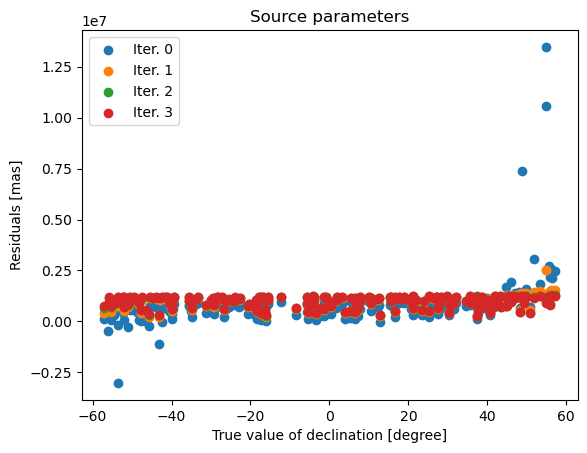

In [1540]:
j = 1

plt.title("Source parameters")

for i,shat_ in enumerate(shats):
    plt.scatter(np.rad2deg(src[:,1+j]),(shat_[:,1+j]-src[:,1+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of right ascension [degree]")
elif j==1:
    plt.xlabel("True value of declination [degree]")
plt.ylabel("Residuals [mas]");

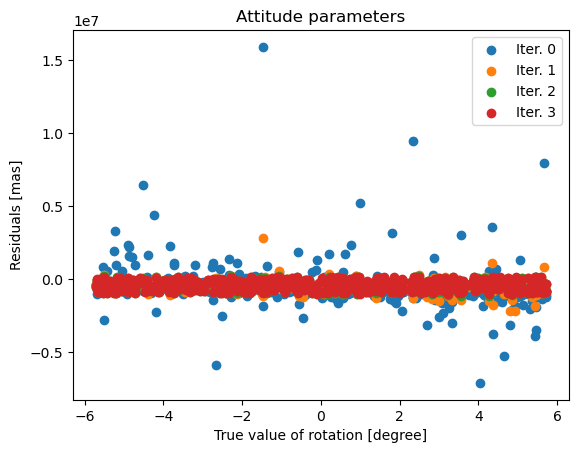

In [1543]:
j = 2

plt.title("Attitude parameters")

for i,ehat_ in enumerate(ehats):
    plt.scatter(np.rad2deg(exp[:,2+j]),(ehat_[:,2+j]-exp[:,2+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of poiting in right ascension [degree]")
elif j==1:
    plt.xlabel("True value of poiting in declination [degree]")
elif j==2:
    plt.xlabel("True value of rotation [degree]")
plt.ylabel("Residuals [mas]");

In [1544]:
scipy.stats.describe(ehats[-1][:,2+j]-exp[:,2+j])

DescribeResult(nobs=501, minmax=(-0.004928810186271525, 0.0008749235923059609), mean=-0.0021404825970389716, variance=2.682121144179984e-06, skewness=0.13574699604291038, kurtosis=-1.2172041577941386)

In [1545]:
scipy.stats.describe(shats[-1][:,1+j]-src[:,1+j])

DescribeResult(nobs=200, minmax=(0.0012372790803141243, 0.00599851584551625), mean=0.004741664589195729, variance=1.5894297657389637e-06, skewness=-1.0103818649326444, kurtosis=-0.06513922283013862)

In [1546]:
## priors are drawn from the true values with the posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 10/_radiants_to_mas
priors = jnp.column_stack((shat[:,0],np.vstack([np.random.normal(src_[1:],priors_uncertainty) for src_ in src])))
sig_prior = np.array([[priors_uncertainty,priors_uncertainty]]*len(src))

In [1549]:
ehats = []
shats = []

iters = 4

ehats.append(ehat)
shats.append(shat)

for i in range(iters):
    if i==0:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(priors,ehat)))
        new_shat = jnp.column_stack((shat[:,0],update_source(priors,new_ehat)))
    else:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(previous_shat,previous_ehat)))
        new_shat = jnp.column_stack((shat[:,0],update_source(previous_shat,new_ehat)))

    ehats.append(new_ehat)
    shats.append(new_shat)
    previous_ehat = new_ehat
    previous_shat = new_shat

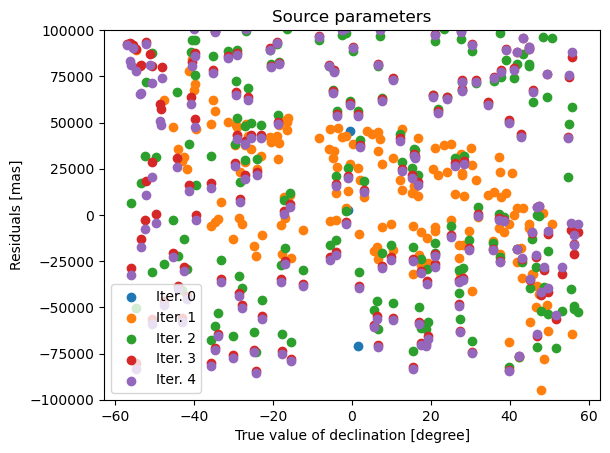

In [1568]:
j = 1

plt.title("Source parameters")

for i,shat_ in enumerate(shats):
    plt.scatter(np.rad2deg(src[:,1+j]),(shat_[:,1+j]-src[:,1+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of right ascension [degree]")
elif j==1:
    plt.xlabel("True value of declination [degree]")
plt.ylabel("Residuals [mas]");

plt.ylim(-1e5,1e5);

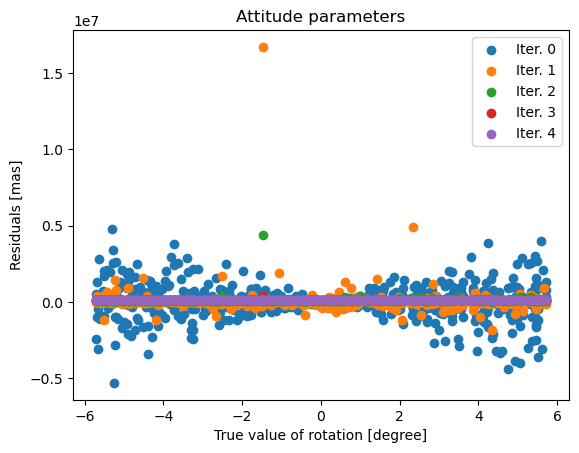

In [1564]:
j = 2

plt.title("Attitude parameters")

for i,ehat_ in enumerate(ehats):
    plt.scatter(np.rad2deg(exp[:,2+j]),(ehat_[:,2+j]-exp[:,2+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of poiting in right ascension [degree]")
elif j==1:
    plt.xlabel("True value of poiting in declination [degree]")
elif j==2:
    plt.xlabel("True value of rotation [degree]")
plt.ylabel("Residuals [mas]");

In [1561]:
j = 2

In [1562]:
scipy.stats.describe(ehats[-1][:,2+j]-exp[:,2+j])

DescribeResult(nobs=501, minmax=(0.0004481025689622442, 0.0006863997331402125), mean=0.0005934777043480973, variance=2.9746552731792794e-09, skewness=-0.7700343991678591, kurtosis=-0.2383570017823704)

In [1560]:
scipy.stats.describe(shats[-1][:,1+j]-src[:,1+j])

DescribeResult(nobs=200, minmax=(-0.00041503240273932374, 0.0005810487649288154), mean=0.00013175571823701246, variance=9.028792436459969e-08, skewness=-0.1874549648158973, kurtosis=-1.3089782352776969)

In [1570]:
np.sqrt(1e-9)*_radiants_to_mas

6522.66588874152

# Simple model with priors (attitude is rotation)

In [2196]:
from propagation import _comrs2fovrs

In [1572]:
def forwardmodelling(src,exp,time):
    return jnp.asarray(_comrs2fovrs(src[0],src[1],exp[0],exp[1],exp[2],time))

In [1573]:
etazeta = jax.jit(lambda s,e,t: forwardmodelling(s,e,t))

## Generate true values

In [1574]:
pkey = jax.random.PRNGKey(42)
alpha00 = 0#266.4
delta00 = 0#-28.9
pt_ra0 = 0#266.40498829
pt_dec0 = 0#-28.93617776
pt_rot0 = 0#58.61

source_id = jnp.arange(200)
alpha0 = np.deg2rad(alpha00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.deg2rad(delta00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(501)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(pt_ra0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_dec = np.deg2rad(pt_dec0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_rot = np.deg2rad(pt_rot0) + np.random.uniform(-0.1,0.1, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec,pt_rot]).T

In [1575]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

## Generate observations and priors

In [1676]:
_iterate_src_etazeta = jax.vmap(etazeta, (0, None, None), 0)
_iterate_exp_etazeta = jax.vmap(etazeta, (None, 0, 0), 0)
_iterate_full_etazeta = jax.vmap(_iterate_exp_etazeta, (0, None,None), 0)
exposure_etazeta = lambda s, e, t: np.hstack(np.vstack(_iterate_full_etazeta(s, e, t)))


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    obs = exposure_etazeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids_ = np.array([[src[i,0].item(),exp[j,0].item(),k] for i in range(len(src)) for j in range(len(exp)) for k in [0,1]  ])
    return jnp.column_stack([ids_, obs])

sig_obs = 0.0001/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

## priors are drawn from the true values with the aprox. posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 1/_radiants_to_mas
priors = np.column_stack((src[:,0],[np.random.normal(src_[1:],priors_uncertainty) for src_ in src]))
sig_prior = np.column_stack((src[:,0],[[priors_uncertainty,priors_uncertainty]]*len(src)))

## Calculate gradients

In [1645]:
Jds = jax.vmap(jax.jacrev(etazeta,argnums=(0)),(None,0,0))
Jde = jax.vmap(jax.jacrev(etazeta,argnums=(1)),(0,None,None))

In [1807]:
def update_source_inner(src, exp,obs,sig_obs,priors,sig_prior):

    #search for the source of interest
    mask = obs[:, 0] == src[0]
    
    #check if priors are given:
    if priors is not None:
        if sig_prior is None:
            raise ValueError("If the priors are given, you need to provide also their uncertainties!")
        else:
            priors_ = priors[priors[:,0]==src[0]][0]
            sig_prior_ = sig_prior[sig_prior[:,0]==src[0]][0]
            
    c = np.hstack(_iterate_exp_etazeta(src[1:], exp[:, 2:], exp[:, 1]))
    o = obs[mask][:, -1]
    
    Ds = jnp.vstack(Jds(src[1:],exp[:,2:],exp[:,1]))

    if priors is None:
        N = Ds.T @ Ds
        b = Ds.T @ (o - c)
    else:
        if isinstance(sig_obs,(float,int)):
            S = jnp.eye(len(o))*sig_obs**(-2)
        elif isinstance(sig_obs,np.ndarray):
            s = sig_obs[mask]
            S = jnp.diag(s**(-2))
        else:
            raise ValueError("The observational uncertainties have to be either a scalar or a numpy array")
        N = Ds.T @ S @ Ds + jnp.diag(sig_prior_[1:]**(-2))
        b = Ds.T @ S @ (o - c) + jnp.matmul(np.diag(sig_prior_[1:]**(-2)),(priors_[1:]-src[1:]))

    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta


def update_source(src, exp,obs,sig_obs,priors,sig_prior):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp,obs,sig_obs,priors,sig_prior) for _ in src])

In [1686]:
def update_exposure_inner(src, exp,obs):
    c = np.hstack(_iterate_src_etazeta(src[:,1:], exp[2:], exp[1]))
    o = obs[obs[:, 1] == exp[0]][:, -1]
    
    De = jnp.vstack(Jde(src[:,1:],exp[2:],exp[1]))
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp,obs):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, exp_,obs) for exp_ in exp])

In [1648]:
update_source_inner(shat[0],ehat,obs,sig_obs_vec,priors,sig_prior)

Array([-0.94508077,  0.52695645], dtype=float64)

## Iterate

In [1649]:
ehats = []
shats = []

iters = 4

for i in range(iters):
    if i==0:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(priors,ehat,obs)))
        new_shat = jnp.column_stack((shat[:,0],update_source(shat,new_ehat,obs,sig_obs_vec,priors,sig_prior)))
    else:
        new_ehat = jnp.column_stack((ehat[:,:2],update_exposure(previous_shat,previous_ehat,obs)))
        new_shat = jnp.column_stack((shat[:,0],update_source(previous_shat,new_ehat,obs,sig_obs_vec,priors,sig_prior)))

    ehats.append(new_ehat)
    shats.append(new_shat)
    previous_ehat = new_ehat
    previous_shat = new_shat

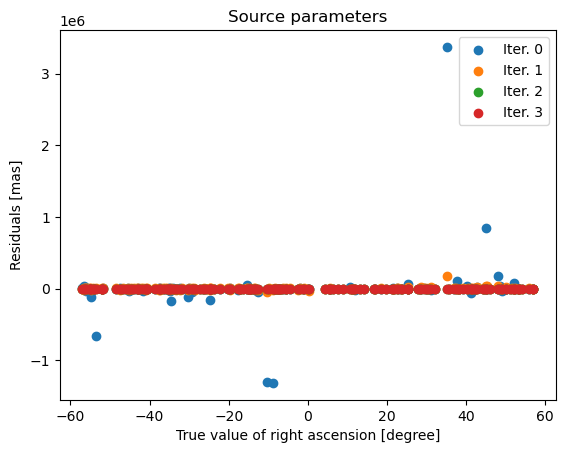

In [1653]:
j = 0

plt.title("Source parameters")

for i,shat_ in enumerate(shats):
    plt.scatter(np.rad2deg(src[:,1+j]),(shat_[:,1+j]-src[:,1+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of right ascension [degree]")
elif j==1:
    plt.xlabel("True value of declination [degree]")
plt.ylabel("Residuals [mas]");

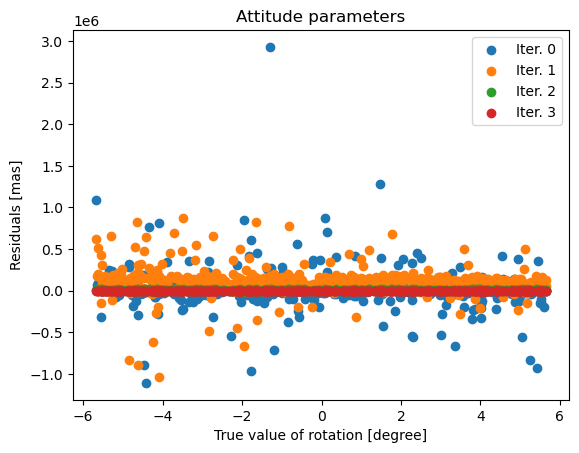

In [1654]:
j = 2

plt.title("Attitude parameters")

for i,ehat_ in enumerate(ehats):
    plt.scatter(np.rad2deg(exp[:,2+j]),(ehat_[:,2+j]-exp[:,2+j])*_radiants_to_mas,label=f"Iter. {i}")

plt.legend()

if j == 0:
    plt.xlabel("True value of poiting in right ascension [degree]")
elif j==1:
    plt.xlabel("True value of poiting in declination [degree]")
elif j==2:
    plt.xlabel("True value of rotation [degree]")
plt.ylabel("Residuals [mas]");

In [1658]:
j = 2

In [1659]:
scipy.stats.describe(shats[-1][:,1+j]-src[:,1+j])

DescribeResult(nobs=200, minmax=(7.585329042658628e-08, 6.300233511558062e-07), mean=2.5179279445949275e-07, variance=8.081527873164681e-15, skewness=0.5720516261463061, kurtosis=1.6859365931165327)

In [1660]:
scipy.stats.describe(ehats[-1][:,2+j]-exp[:,2+j])

DescribeResult(nobs=501, minmax=(-1.7080241472705593e-06, 5.298484395888786e-06), mean=1.8109991126276676e-06, variance=3.089814661222815e-12, skewness=-0.07370238621421726, kurtosis=-1.1336455506578111)

In [1667]:
j = 1

In [1668]:
scipy.stats.describe((shats[-1][:,1+j]-src[:,1+j])*_radiants_to_mas)

DescribeResult(nobs=200, minmax=(15.645864253044547, 129.9516444572987), mean=51.93599196360222, variance=343.82997961689193, skewness=0.5720516261463063, kurtosis=1.6859365931165344)

In [1669]:
scipy.stats.describe((ehats[-1][:,2+j]-exp[:,2+j])*_radiants_to_mas)

DescribeResult(nobs=501, minmax=(772.3763418327692, 1581.3397668817881), mean=1126.8469450263544, variance=21554.471110110488, skewness=-0.03838993733116702, kurtosis=0.12760468852214135)

In [1666]:
np.sqrt(1227)

35.02855977627399

### Test with perfect knowledge 

In [1696]:
ehat_perfect = jnp.column_stack((exp[:,:2],update_exposure(src,ehat,obs)))

In [1697]:
ehat_perfect_2 = jnp.column_stack((exp[:,:2],update_exposure(src,ehat_perfect,obs)))

In [1701]:
ehat_perfect_3 = jnp.column_stack((exp[:,:2],update_exposure(src,ehat_perfect_2,obs)))

In [1698]:
for j in range(ehat_perfect.shape[1]):
    print(scipy.stats.describe((ehat[:,j]-exp[:,j])*_radiants_to_mas))

DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(-25828446.972660735, 31154373.376020916), mean=386077.8719756708, variance=34634813672296.996, skewness=0.29043028221189093, kurtosis=3.7942749096597)
DescribeResult(nobs=501, minmax=(-18554920.33275476, 31511720.40204722), mean=466299.2773465834, variance=34450100233507.098, skewness=0.6759273953797618, kurtosis=3.172806327549295)
DescribeResult(nobs=501, minmax=(-4716795.538759306, 3128400.7338199904), mean=-11719.356518703451, variance=1342825239869.659, skewness=-0.3359689482510699, kurtosis=1.3791653326430007)


In [1699]:
for j in range(ehat_perfect.shape[1]):
    print(scipy.stats.describe((ehat_perfect[:,j]-exp[:,j])*_radiants_to_mas))

DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(-827361.622883571, 381899.5527714992), mean=3063.0539783230224, variance=3591518252.2027354, skewness=-5.790979967375662, kurtosis=82.96740985783599)
DescribeResult(nobs=501, minmax=(-1291338.3865337458, 5866795.921262224), mean=17179.058459653872, variance=107590919732.52661, skewness=12.157056507195364, kurtosis=205.91039946277584)
DescribeResult(nobs=501, minmax=(-1108520.2487072367, 2928911.4891378526), mean=13902.824355677209, variance=57697409750.838745, skewness=3.6595910661366418, kurtosis=47.81692646090074)


In [1700]:
for j in range(ehat_perfect.shape[1]):
    print(scipy.stats.describe((ehat_perfect_2[:,j]-exp[:,j])*_radiants_to_mas))

DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(-2263.5768731108124, 3422.1478685733846), mean=-1.0575839900040098, variance=66837.4823411708, skewness=3.664197866088413, kurtosis=81.73543921349705)
DescribeResult(nobs=501, minmax=(-25810.465941851755, 132983.87513554108), mean=258.1614858478507, variance=37069199.79883078, skewness=20.593134279633606, kurtosis=450.26337317673455)
DescribeResult(nobs=501, minmax=(-79611.13465136834, 11779.376859216896), mean=-146.97853475290577, variance=13236109.56824915, skewness=-20.80115774690812, kurtosis=453.39477496052706)


In [1702]:
for j in range(ehat_perfect.shape[1]):
    print(scipy.stats.describe((ehat_perfect_3[:,j]-exp[:,j])*_radiants_to_mas))

DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=501, minmax=(-21.67512625131001, 0.13173150389705102), mean=-0.04269247393604786, variance=0.9378468235847802, skewness=-22.31413941913619, kurtosis=495.9481661581485)
DescribeResult(nobs=501, minmax=(-0.3389695998430955, 47.64895694993385), mean=0.09939879634610402, variance=4.541541770075736, skewness=22.24013455816533, kurtosis=493.68258328665155)
DescribeResult(nobs=501, minmax=(-51.02633907501145, 3.2544728559216143), mean=-0.09355116253835273, variance=5.220403808557988, skewness=-22.17045614997422, kurtosis=491.8657924076573)


In [1708]:
shat_perfect = jnp.column_stack((src[:,:1],update_source(shat,exp,obs,1,None,None)))

In [1709]:
shat_perfect_2 = jnp.column_stack((src[:,:1],update_source(shat_perfect,exp,obs,1,None,None)))

In [1710]:
shat_perfect_3 = jnp.column_stack((src[:,:1],update_source(shat_perfect_2,exp,obs,1,None,None)))

In [1717]:
shat_perfect_4 = jnp.column_stack((src[:,:1],update_source(shat_perfect_3,exp,obs,1,None,None)))

In [1719]:
shat_perfect_5 = jnp.column_stack((src[:,:1],update_source(shat_perfect_4,exp,obs,1,None,None)))

In [1715]:
shat_perfect_0 = jnp.column_stack((src[:,:1],update_source(src,exp,obs,1,None,None)))

In [1716]:
for j in range(shat_perfect_0.shape[1]):
    print(scipy.stats.describe((shat_perfect_0[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-1.3327796337204718e-05, 1.2572096544888987e-05), mean=3.825743057481576e-07, variance=2.2966659582304907e-11, skewness=-0.274808677541988, kurtosis=0.06903395213640318)
DescribeResult(nobs=200, minmax=(-1.1106496947670599e-05, 1.1472896846975195e-05), mean=-2.4903192460209896e-07, variance=1.572586474011553e-11, skewness=-0.04248234304591016, kurtosis=-0.22278388600453347)


In [1711]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-37147844.11095231, 34978034.82810793), mean=207223.12824805573, variance=136033461340561.98, skewness=-0.2081500514075761, kurtosis=1.407946641840649)
DescribeResult(nobs=200, minmax=(-50196669.804150134, 57352484.803323016), mean=232967.57683661737, variance=161659410947792.75, skewness=0.8322907662578249, kurtosis=4.650776076612858)


In [1712]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat_perfect[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-9923444.300740017, 12833929.24652893), mean=-12659.334400658898, variance=1995501275013.7336, skewness=0.7305007323813928, kurtosis=53.15442876251507)
DescribeResult(nobs=200, minmax=(-15644405.876887973, 33800948.64247974), mean=371237.17558139784, variance=11066999713219.143, skewness=6.232898654592342, kurtosis=59.32492410957252)


In [1713]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat_perfect_2[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-2246157.3951125084, 7860153.873238331), mean=27515.633740635836, variance=339537976675.34033, skewness=11.942053780919602, kurtosis=163.07030720843207)
DescribeResult(nobs=200, minmax=(-556233.9626634254, 13462569.518871063), mean=92338.61782173865, variance=973147036036.6221, skewness=12.73572592817946, kurtosis=168.0406166961972)


In [1714]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat_perfect_3[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-66584.58135816174, 1310731.9374129798), mean=6203.064856461453, variance=8616983998.913568, skewness=13.979082353603536, kurtosis=193.98461460104238)
DescribeResult(nobs=200, minmax=(-505.007067871252, 684055.3910060613), mean=3722.0037581554025, variance=2352812446.5368943, skewness=13.905656102000956, kurtosis=192.45664219680265)


In [1718]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat_perfect_4[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-24.859832687001973, 2603.4472591257004), mean=12.892430620552597, variance=33896.04371506512, skewness=14.033897077797938, kurtosis=194.9689350529322)
DescribeResult(nobs=200, minmax=(-645.8719754424266, 5.426224865144407), mean=-3.2020665782008444, variance=2086.07742501474, skewness=-14.034338815391123, kurtosis=194.97708556090896)


In [1720]:
for j in range(shat_perfect.shape[1]):
    print(scipy.stats.describe((shat_perfect_5[:,j]-src[:,j])*_radiants_to_mas))

DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
DescribeResult(nobs=200, minmax=(-0.009875370386013447, 1.2594996538595525e-05), mean=-4.9034761581698975e-05, variance=4.876714014146303e-07, skewness=-14.034856000215152, kurtosis=194.98655535249034)
DescribeResult(nobs=200, minmax=(-0.003795605256877441, 1.1472896846975195e-05), mean=-1.9221014897295655e-05, variance=7.203952053245171e-08, skewness=-14.031215567663734, kurtosis=194.91877407644293)


### Test with imperfect knowledge 

In [1721]:
ehat_imperfect = jnp.column_stack((exp[:,:2],update_exposure(shat,ehat,obs)))

In [1722]:
ehat_imperfect_2 = jnp.column_stack((exp[:,:2],update_exposure(src,ehat_imperfect,obs)))

In [1723]:
ehat_imperfect_3 = jnp.column_stack((exp[:,:2],update_exposure(src,ehat_imperfect_2,obs)))

In [1724]:
shat_imperfect = jnp.column_stack((src[:,:1],update_source(shat,ehat_imperfect_3,obs,1,None,None)))

In [1725]:
shat_imperfect_2 = jnp.column_stack((src[:,:1],update_source(shat_imperfect,ehat_imperfect_3,obs,1,None,None)))

In [1726]:
shat_imperfect_3 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_2,ehat_imperfect_3,obs,1,None,None)))

In [1727]:
shat_imperfect_4 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_3,ehat_imperfect_3,obs,1,None,None)))

In [1728]:
shat_imperfect_5 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_4,ehat_imperfect_3,obs,1,None,None)))

In [1729]:
ehat_imperfect_11 = jnp.column_stack((exp[:,:2],update_exposure(shat_imperfect_5,ehat_imperfect_3,obs)))

In [1730]:
ehat_imperfect_12 = jnp.column_stack((exp[:,:2],update_exposure(shat_imperfect_5,ehat_imperfect_11,obs)))

In [1731]:
ehat_imperfect_13 = jnp.column_stack((exp[:,:2],update_exposure(shat_imperfect_5,ehat_imperfect_12,obs)))

In [1732]:
shat_imperfect_11 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_5,ehat_imperfect_13,obs,1,None,None)))

In [1734]:
shat_imperfect_12 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_11,ehat_imperfect_13,obs,1,None,None)))

In [1738]:
shat_imperfect_13 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_12,ehat_imperfect_13,obs,1,None,None)))

In [1739]:
shat_imperfect_14 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_13,ehat_imperfect_13,obs,1,None,None)))

In [1740]:
shat_imperfect_15 = jnp.column_stack((src[:,:1],update_source(shat_imperfect_14,ehat_imperfect_13,obs,1,None,None)))

In [1758]:
shats = [shat]
ehats = [ehat]


for n in range(4):
    print(n)
    for i in range(4):
        aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(4):
        aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
3


In [1759]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

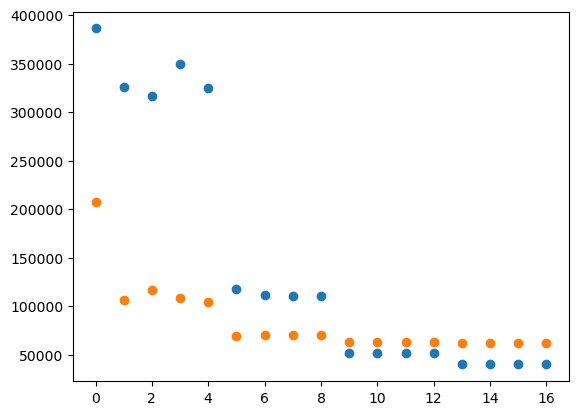

In [1760]:
j = 0
plt.scatter(range(len(exp_means)),exp_means[:,j])
plt.scatter(range(len(src_means)),src_means[:,j])

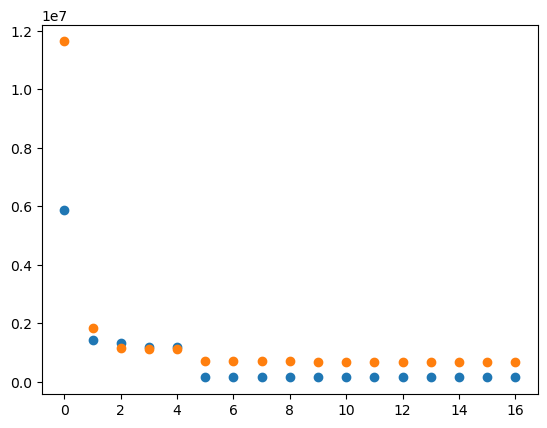

In [1761]:
j = 0
plt.scatter(range(len(exp_means)),exp_std[:,j])
plt.scatter(range(len(src_means)),src_std[:,j])

In [1762]:
shats = [shat]
ehats = [ehat]


for n in range(16):
    print(n)
    for i in range(1):
        aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(1):
        aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [1763]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

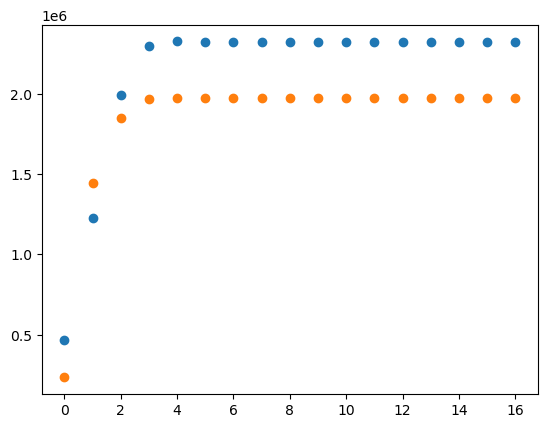

In [1770]:
j = 1
plt.scatter(range(len(exp_means)),exp_means[:,j])
plt.scatter(range(len(src_means)),src_means[:,j])

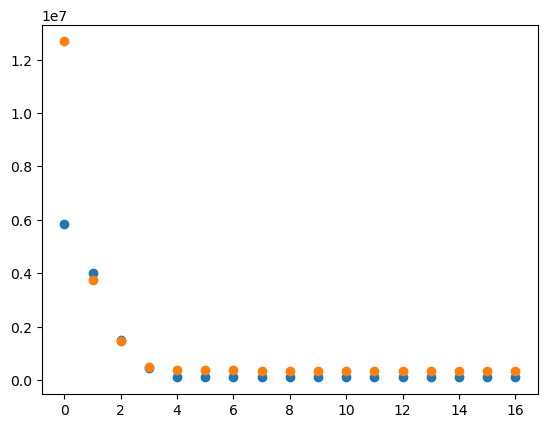

In [1771]:
j = 1
plt.scatter(range(len(exp_means)),exp_std[:,j])
plt.scatter(range(len(src_means)),src_std[:,j])

#### With priors

In [1772]:
shats = [shat]
ehats = [ehat]


for n in range(5):
    print(n)
    for i in range(3):
        if n==0:
            aux = jnp.column_stack((exp[:,:2],update_exposure(priors,ehats[-1],obs)))
        else:
            aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(3):
        aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,sig_obs_vec,priors,sig_prior)))
        shats.append(aux)

0
1
2
3
4


In [1773]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

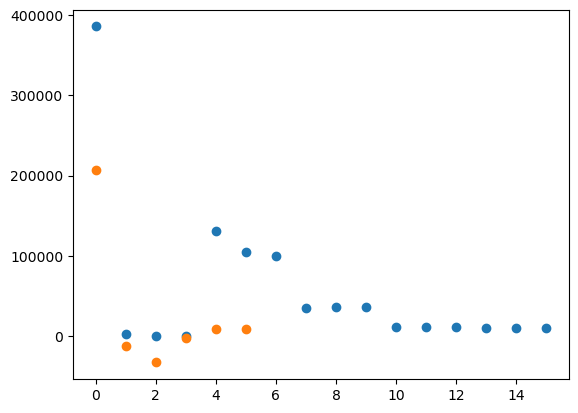

In [1775]:
j = 0
plt.scatter(range(len(exp_means)),exp_means[:,j])
plt.scatter(range(len(src_means)),src_means[:,j])

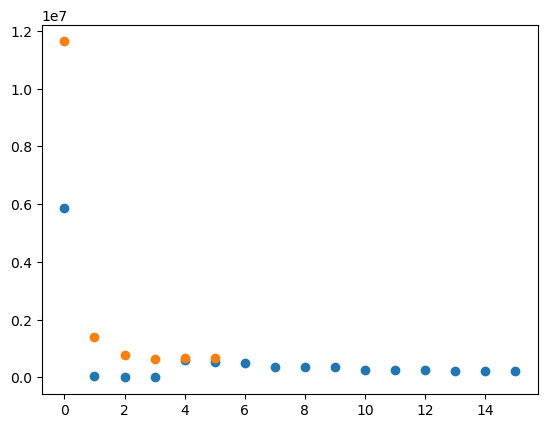

In [1776]:
j = 0
plt.scatter(range(len(exp_means)),exp_std[:,j])
plt.scatter(range(len(src_means)),src_std[:,j])

In [1777]:
exp_means[0]

array([386077.87197567, 466299.27734658, -11719.3565187 ])

In [1778]:
exp_means[1]

array([ 3062.9499598 , 17179.02587554, 13902.67480391])

In [1779]:
exp_means[2]

array([  -1.16213879,  258.13069359, -147.1275544 ])

In [1780]:
exp_means[3]

array([-0.14724419,  0.06859765, -0.24261216])

In [1781]:
exp_std[3]

array([0.96471336, 2.13110908, 2.2912995 ])

In [1782]:
src_means[0]

array([207223.12824806, 232967.57683662])

In [1785]:
src_means[1]

array([-12659.55082927, 371237.23341046])

In [1790]:
np.mean(update_source(shats[0],ehats[3],obs,sig_obs_vec*100,priors,sig_prior)-src[:,1:],axis=0)*_radiants_to_mas

Array([-12659.55182717, 371237.2229784 ], dtype=float64)

In [1793]:
np.mean(update_source(priors,ehats[3],obs,sig_obs_vec,None,None)-src[:,1:],axis=0)*_radiants_to_mas

Array([-0.2202479 ,  0.05553308], dtype=float64)

In [1792]:
np.mean(priors[:,1:]-src[:,1:],axis=0)*_radiants_to_mas

Array([-0.10468712, -0.04326049], dtype=float64)

#### With primary sources

In [1819]:
_iterate_src_etazeta = jax.vmap(etazeta, (0, None, None), 0)
_iterate_exp_etazeta = jax.vmap(etazeta, (None, 0, 0), 0)
_iterate_full_etazeta = jax.vmap(_iterate_exp_etazeta, (0, None,None), 0)
exposure_etazeta = lambda s, e, t: np.hstack(np.vstack(_iterate_full_etazeta(s, e, t)))


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    obs = exposure_etazeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids_ = np.array([[src[i,0].item(),exp[j,0].item(),k] for i in range(len(src)) for j in range(len(exp)) for k in [0,1]  ])
    return jnp.column_stack([ids_, obs])

sig_obs = 0.0001/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

## priors are drawn from the true values with the aprox. posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 1/_radiants_to_mas
priors = np.column_stack((src[:,0],[np.random.normal(src_[1:],priors_uncertainty) for src_ in src]))
sig_prior = np.column_stack((src[:,0],[[priors_uncertainty,priors_uncertainty]]*len(src)))

In [1820]:
shats = [shat]
ehats = [ehat]


for n in range(5):
    print(n)
    for i in range(3):
        if n==0:
            aux = jnp.column_stack((exp[:,:2],update_exposure(priors,ehats[-1],obs)))
        else:
            aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(3):
        if n==0:
            aux = jnp.column_stack((src[:,:1],update_source(priors,ehats[-1],obs,1,None,None)))
        else:
            aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
3
4


In [1821]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

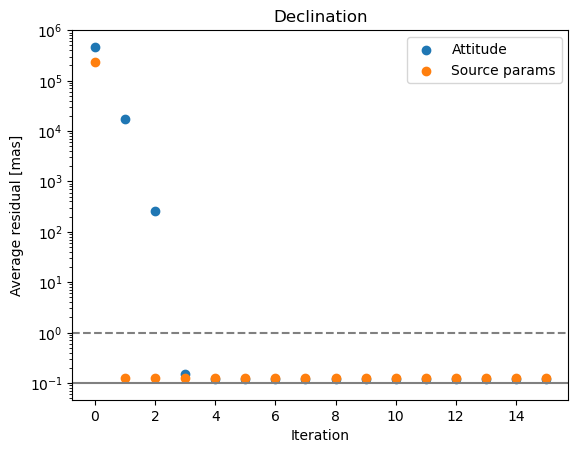

In [1822]:
j = 1
plt.scatter(range(len(exp_means)),np.abs(exp_means[:,j]),label="Attitude")
plt.scatter(range(len(src_means)),np.abs(src_means[:,j]),label="Source params")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.axhline(1,ls="--",color="grey")
plt.axhline(0.1,ls="-",color="grey")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Average residual [mas]");

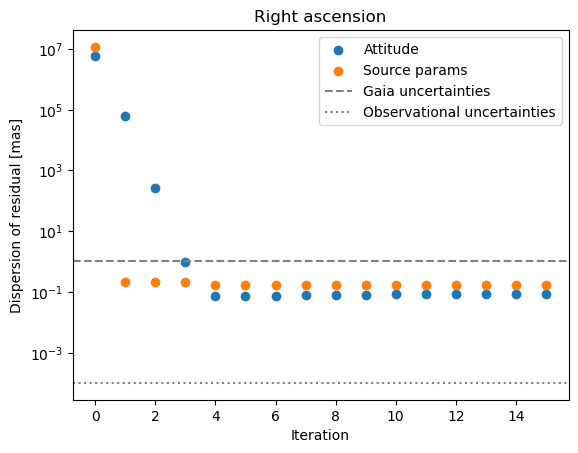

In [1823]:
j = 0
plt.scatter(range(len(exp_means)),exp_std[:,j],label="Attitude")
plt.scatter(range(len(src_means)),src_std[:,j],label="Source params")
plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Dispersion of residual [mas]");

#### With primary sources (worse data)

In [1808]:
_iterate_src_etazeta = jax.vmap(etazeta, (0, None, None), 0)
_iterate_exp_etazeta = jax.vmap(etazeta, (None, 0, 0), 0)
_iterate_full_etazeta = jax.vmap(_iterate_exp_etazeta, (0, None,None), 0)
exposure_etazeta = lambda s, e, t: np.hstack(np.vstack(_iterate_full_etazeta(s, e, t)))


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    obs = exposure_etazeta(src[:, 1:], exp[:, 2:], exp[:, 1])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids_ = np.array([[src[i,0].item(),exp[j,0].item(),k] for i in range(len(src)) for j in range(len(exp)) for k in [0,1]  ])
    return jnp.column_stack([ids_, obs])

sig_obs = 100/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

## priors are drawn from the true values with the aprox. posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 10/_radiants_to_mas
priors = np.column_stack((src[:,0],[np.random.normal(src_[1:],priors_uncertainty) for src_ in src]))
sig_prior = np.column_stack((src[:,0],[[priors_uncertainty,priors_uncertainty]]*len(src)))

In [1809]:
shats = [shat]
ehats = [ehat]


for n in range(5):
    print(n)
    for i in range(3):
        if n==0:
            aux = jnp.column_stack((exp[:,:2],update_exposure(priors,ehats[-1],obs)))
        else:
            aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(3):
        if n==0:
            aux = jnp.column_stack((src[:,:1],update_source(priors,ehats[-1],obs,1,None,None)))
        else:
            aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
3
4


In [1810]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

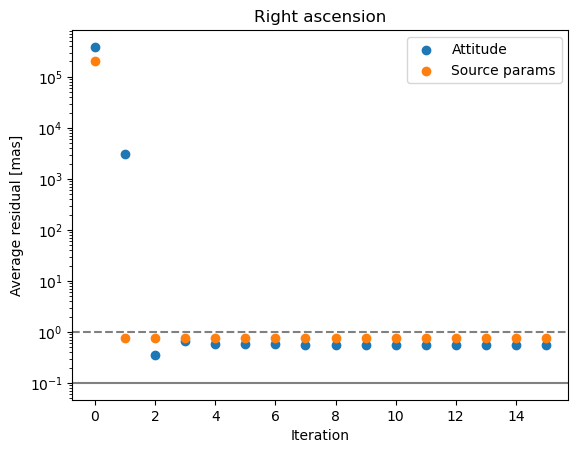

In [1816]:
j = 0
plt.scatter(range(len(exp_means)),np.abs(exp_means[:,j]),label="Attitude")
plt.scatter(range(len(src_means)),np.abs(src_means[:,j]),label="Source params")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.axhline(1,ls="--",color="grey")
plt.axhline(0.1,ls="-",color="grey")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Average residual [mas]");

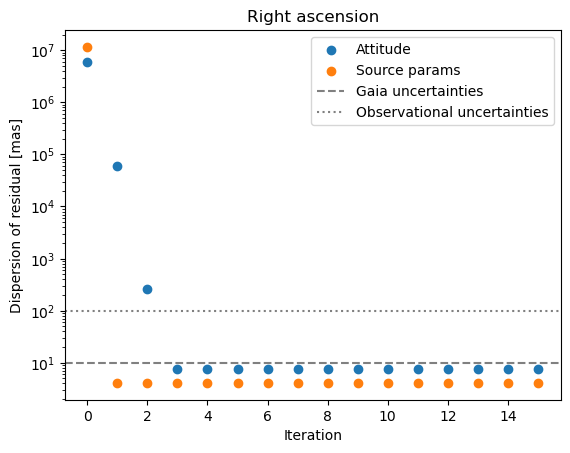

In [1818]:
j = 0
plt.scatter(range(len(exp_means)),exp_std[:,j],label="Attitude")
plt.scatter(range(len(src_means)),src_std[:,j],label="Source params")
plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Dispersion of residual [mas]");

#### With primary sources (multiple FoVs)

In [1882]:
# real values
pkey = jax.random.PRNGKey(42)

#simulate stars
sky_patch_size = 2
source_id = jnp.arange(5000)
alpha0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))
delta0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))

fovs = [
    [(-0.15,0),0.5,0,200],
    [(+0.15,0),0.5,0.1,200],
    [(0,-0.15),0.5,0.2,200],
    [(0,+0.15),0.5,0.3,200]
]

exps = []
last_exp_id = 0
for buffer in fovs:
    fov_loc,fov_size,delta_t,num_exp = buffer
    exposure_id_ = last_exp_id + jnp.arange(num_exp)
    ep_ = jnp.linspace(0,3, exposure_id_.size) + delta_t
    pt_ra_ = np.deg2rad(fov_loc[0] + np.random.uniform(-fov_size/4, fov_size/4, size=exposure_id_.shape))
    pt_dec_ = np.deg2rad(fov_loc[1] + np.random.uniform(-fov_size/4, fov_size/4, size=exposure_id_.shape))
    exp_ = jnp.stack([exposure_id_, ep_, pt_ra_,pt_dec_]).T
    exps.append(exp_)
    last_exp_id = exposure_id_[-1] + 1

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.vstack((exps))

In [1923]:
#observations
_iterate_src_etazeta = jax.vmap(etazeta, (0, None, None), 0)
_iterate_exp_etazeta = jax.vmap(etazeta, (None, 0, 0), 0)
_iterate_full_etazeta = jax.vmap(_iterate_exp_etazeta, (0, None,None), 0)
exposure_etazeta = lambda s, e, t: np.hstack(np.vstack(_iterate_full_etazeta(s, e, t)))


def estimate(src, exp, noise=0.00,FoV_size=np.deg2rad(0.5)):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    ids_ = []
    obs_ = []
    for _exp in exp:
        #find sources within FoV
        FoV_centre = _exp[2:]
        sources = src[(np.abs(src[:,1]-FoV_centre[0])<FoV_size/2)&(np.abs(src[:,2]-FoV_centre[1])<FoV_size/2)]
        obs_.extend(_iterate_src_etazeta(sources[:, 1:], _exp[2:], _exp[1]))
        ids_.extend([(sid.item(),_exp[0].item(),k) for sid in sources[:,0] for k in [0,1]])
    obs = np.hstack(np.vstack(obs_))
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids = np.vstack(ids_)
    return jnp.column_stack([ids, obs])

sig_obs = 100/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

In [1924]:
sids_observed = np.unique(obs[:,0]).tolist()

In [1925]:
src_obs = src[np.array([i for i,sid in enumerate(src[:,0]) if sid in sids_observed])]

In [1932]:
#initial guesses
shat = jnp.hstack([src_obs[:, 0:1], src_obs[:, 1:] * np.random.normal(1.0, 0.1, size=src_obs[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

In [1927]:
## priors are drawn from the true values with the aprox. posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 10/_radiants_to_mas
priors = np.column_stack((src_obs[:,0],[np.random.normal(src_[1:],priors_uncertainty) for src_ in src_obs]))
sig_prior = np.column_stack((src_obs[:,0],[[priors_uncertainty,priors_uncertainty]]*len(src_obs)))

In [1933]:
src_obs.shape

(1268, 3)

In [1934]:
shat_obs.shape

(1268, 3)

In [1935]:
priors.shape

(1268, 3)

In [1936]:
obs.shape

(502170, 4)

In [1937]:
df = pd.DataFrame(obs,columns=["sid","expid","axis","value"])

In [1938]:
df.head()

sid  expid  axis     value
0  29.0    0.0   0.0  0.004267
1  29.0    0.0   1.0 -0.001078
2  44.0    0.0   0.0 -0.001436
3  44.0    0.0   1.0 -0.003997
4  78.0    0.0   0.0 -0.003043

In [1939]:
df.groupby(["sid","axis"]).count()

expid  value
sid    axis              
7.0    0.0       3      3
       1.0       3      3
18.0   0.0      30     30
       1.0      30     30
19.0   0.0     453    453
...            ...    ...
4986.0 1.0      46     46
4989.0 0.0      31     31
       1.0      31     31
4998.0 0.0     330    330
       1.0     330    330

[2536 rows x 2 columns]

In [1940]:
df.groupby(["expid","axis"]).count()

sid  value
expid axis            
0.0   0.0   328    328
      1.0   328    328
1.0   0.0   312    312
      1.0   312    312
2.0   0.0   303    303
...         ...    ...
797.0 1.0   290    290
798.0 0.0   313    313
      1.0   313    313
799.0 0.0   311    311
      1.0   311    311

[1600 rows x 2 columns]

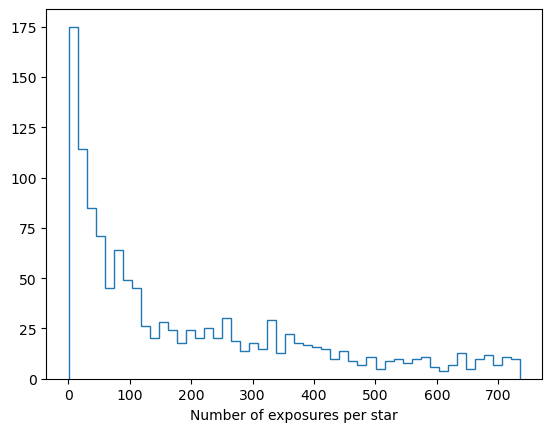

In [1941]:
plt.hist(df.groupby(["sid","axis"]).count().query("axis==0")["value"],bins=50,histtype="step");
plt.xlabel("Number of exposures per star");

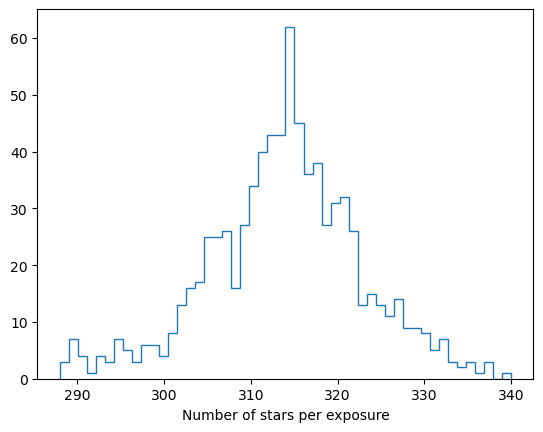

In [1942]:
plt.hist(df.groupby(["expid","axis"]).count().query("axis==0")["value"],bins=50,histtype="step");
plt.xlabel("Number of stars per exposure");

In [1944]:
scipy.stats.describe((priors-src_obs)*_radiants_to_mas)

DescribeResult(nobs=1268, minmax=(array([  0.        , -32.74739461, -28.97409049]), array([ 0.        , 31.7056823 , 30.06274782])), mean=array([ 0.        , -0.30755291,  0.15547347]), variance=array([ 0.        , 97.12450222, 97.08000269]), skewness=array([        nan, -0.00026814,  0.02838321]), kurtosis=array([        nan, -0.01981428, -0.16919022]))

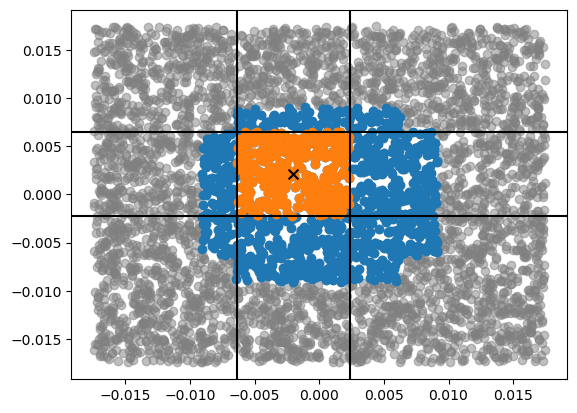

In [1945]:
FoV_centre = exp[10][2:]
sources = src[(np.abs(src[:,1]-FoV_centre[0])<FoV_size/2)&(np.abs(src[:,2]-FoV_centre[1])<FoV_size/2)]

plt.scatter(src[:,1],src[:,2],color="grey",alpha=0.5)
plt.scatter(src_obs[:,1],src_obs[:,2])
plt.scatter(sources[:,1],sources[:,2])
plt.scatter(FoV_centre[0],FoV_centre[1],marker="x",color="k",s=50);
plt.axhline(FoV_centre[1]-FoV_size/2,color="k")
plt.axhline(FoV_centre[1]+FoV_size/2,color="k")

plt.axvline(FoV_centre[0]-FoV_size/2,color="k")
plt.axvline(FoV_centre[0]+FoV_size/2,color="k")

In [1946]:
Jds = jax.vmap(jax.jacrev(etazeta,argnums=(0)),(None,0,0))
Jde = jax.vmap(jax.jacrev(etazeta,argnums=(1)),(0,None,None))

In [1996]:
def update_source_inner(src, exp,obs,sig_obs,priors,sig_prior):

    #locate observations related to this source id
    observations = obs[obs[:, 0] == src[0]]
    #locate the parameters of the exposures when this source id was observed
    mask = np.isin(exp[:,0],observations[:,1])
    exposures = exp[mask]
    
    #check if priors are given:
    if priors is not None:
        if sig_prior is None:
            raise ValueError("If the priors are given, you need to provide also their uncertainties!")
        else:
            priors_ = priors[priors[:,0]==src[0]][0]
            sig_prior_ = sig_prior[sig_prior[:,0]==src[0]][0]
            
    c = np.hstack(_iterate_exp_etazeta(src[1:], exposures[:, 2:], exposures[:, 1]))
    o = observations[:, -1]
    
    Ds = jnp.vstack(Jds(src[1:],exposures[:,2:],exposures[:,1]))

    if priors is None:
        N = Ds.T @ Ds
        b = Ds.T @ (o - c)
    else:
        if isinstance(sig_obs,(float,int)):
            S = jnp.eye(len(o))*sig_obs**(-2)
        elif isinstance(sig_obs,np.ndarray):
            s = sig_obs[mask]
            S = jnp.diag(s**(-2))
        else:
            raise ValueError("The observational uncertainties have to be either a scalar or a numpy array")
        N = Ds.T @ S @ Ds + jnp.diag(sig_prior_[1:]**(-2))
        b = Ds.T @ S @ (o - c) + jnp.matmul(np.diag(sig_prior_[1:]**(-2)),(priors_[1:]-src[1:]))

    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta


def update_source(src, exp,obs,sig_obs,priors,sig_prior):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp,obs,sig_obs,priors,sig_prior) for _ in src])

In [1997]:
def update_exposure_inner(src, exp,obs):
    #locate all observations of the sources observed at this exposure
    observations = obs[obs[:, 1] == exp[0]]
    #locate the parameters of the sources observed
    mask = np.isin(src[:,0],observations[:,0])
    sources = src[mask]
    
    c = np.hstack(_iterate_src_etazeta(sources[:,1:], exp[2:], exp[1]))
    o = observations[:, -1]
    
    De = jnp.vstack(Jde(sources[:,1:],exp[2:],exp[1]))
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp,obs):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, exp_,obs) for exp_ in exp])

In [1998]:
%%timeit
update_exposure_inner(priors,ehats[-1][0],obs)

7.13 ms ± 170 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1999]:
%%timeit
update_source_inner(priors[0],ehats[-1],obs,1,None,None)

4.98 ms ± 145 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2002]:
shats = [shat]
ehats = [ehat]


for n in range(5):
    print(n)
    for i in range(3):
        if n==0:
            aux = jnp.column_stack((exp[:,:2],update_exposure(priors,ehats[-1],obs)))
        else:
            aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(3):
        if n==0:
            aux = jnp.column_stack((src_obs[:,:1],update_source(priors,ehats[-1],obs,1,None,None)))
        else:
            aux = jnp.column_stack((src_obs[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
3
4


In [2004]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src_obs[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src_obs[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

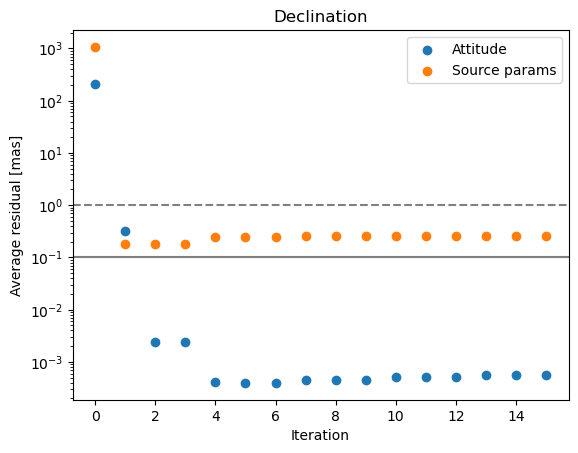

In [2007]:
j = 1
plt.scatter(range(len(exp_means)),np.abs(exp_means[:,j]),label="Attitude")
plt.scatter(range(len(src_means)),np.abs(src_means[:,j]),label="Source params")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.axhline(1,ls="--",color="grey")
plt.axhline(0.1,ls="-",color="grey")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Average residual [mas]");

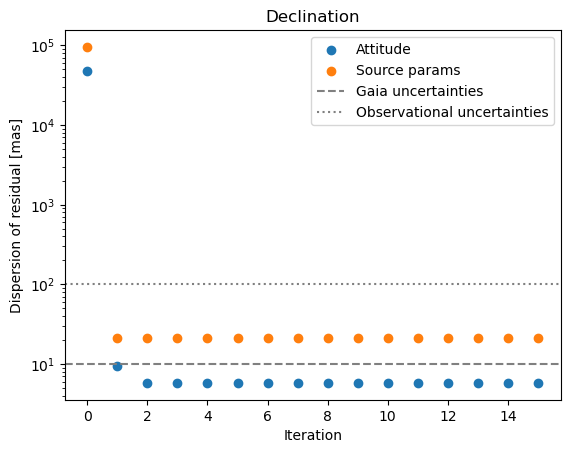

In [2008]:
j = 1
plt.scatter(range(len(exp_means)),exp_std[:,j],label="Attitude")
plt.scatter(range(len(src_means)),src_std[:,j],label="Source params")
plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Dispersion of residual [mas]");

In [2053]:
original_exp_df = pd.DataFrame(exp,columns=["eid","alfa0","delta0","rot0"]).sort_values(by="eid")

In [2056]:
result_exp_df = pd.DataFrame(ehats[-1],columns=["eid","alfa0_est","delta0_est","rot0_est"]).sort_values(by="eid")

In [2021]:
original_df = pd.DataFrame(src_obs,columns=["sid","alfa0","delta0"]).sort_values(by="sid")

In [2026]:
result_df = pd.DataFrame(shats[-1],columns=["sid","alfa0_est","delta0_est"]).sort_values(by="sid")

In [2023]:
obs_df = pd.DataFrame(obs,columns=["sid","eid","axis","value"])

In [2024]:
num_exp = (obs_df.groupby("sid").count()["value"].values/2).astype(int)

In [2057]:
num_sources = (obs_df.groupby("eid").count()["value"].values/2).astype(int)

In [2034]:
result_df = result_df.join(original_df,rsuffix="_o")[["sid","alfa0","delta0","alfa0_est","delta0_est"]]

In [2036]:
result_df["num_exp"] = num_exp

In [2037]:
result_df

sid     alfa0    delta0  alfa0_est  delta0_est  num_exp
0        7.0 -0.007248  0.006259  -0.007248    0.006259        3
1       18.0 -0.005605  0.006276  -0.005605    0.006276       30
2       19.0  0.003288 -0.002061   0.003288   -0.002061      453
3       23.0  0.003553  0.004729   0.003553    0.004729      211
4       29.0  0.000131  0.000311   0.000131    0.000311      719
...      ...       ...       ...        ...         ...      ...
1263  4983.0  0.001697 -0.008838   0.001698   -0.008838       20
1264  4985.0  0.003908  0.005744   0.003908    0.005744      128
1265  4986.0  0.007800 -0.002873   0.007800   -0.002873       46
1266  4989.0  0.005665  0.006309   0.005665    0.006309       31
1267  4998.0 -0.000141 -0.004938  -0.000141   -0.004938      330

[1268 rows x 6 columns]

In [2058]:
result_exp_df = result_exp_df.join(original_exp_df,rsuffix="_o")[["eid","alfa0","delta0","rot0","alfa0_est","delta0_est","rot0_est"]]

In [2059]:
result_exp_df["num_src"] = num_sources

In [2189]:
_radiants_to_mas

206264806.24709633

In [2066]:
result_df.to_csv("/Users/pauramos/Downloads/results_test_4FoV_800exposures_withGaia1stGuess_sourceparams.csv",index=False)

In [2067]:
result_exp_df.to_csv("/Users/pauramos/Downloads/results_test_4FoV_800exposures_withGaia1stGuess_attitudeparams.csv",index=False)

In [2041]:
xbins = np.arange(0,800,10)
mean_error_alfa,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_delta,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

std_error_alfa,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_delta,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

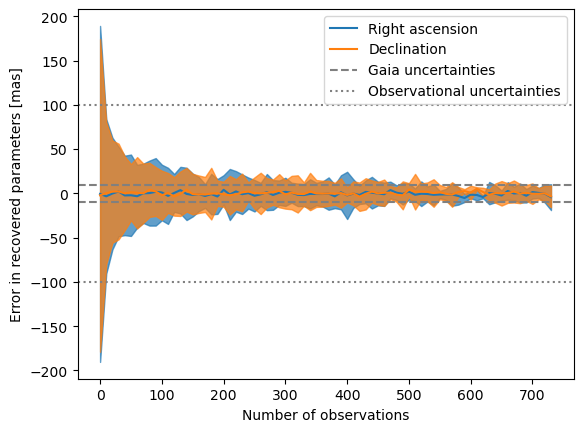

In [2052]:
#plt.scatter(result_df["num_exp"],(result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,s=1,alpha=0.5)
#plt.scatter(result_df["num_exp"],(result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,s=1,alpha=0.5)

plt.plot(xbins[:-1],mean_error_alfa,label="Right ascension")
plt.plot(xbins[:-1],mean_error_delta,label="Declination")

plt.fill_between(xbins[:-1],mean_error_alfa-3*std_error_alfa,mean_error_alfa+3*std_error_alfa,alpha=0.7,color="tab:blue")
plt.fill_between(xbins[:-1],mean_error_delta-3*std_error_delta,mean_error_delta+3*std_error_delta,alpha=0.7,color="tab:orange")

plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(-priors_uncertainty*_radiants_to_mas,ls="--",color="grey")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.axhline(-sig_obs*_radiants_to_mas,ls=":",color="grey")

plt.legend()

plt.xlabel("Number of observations")
plt.ylabel("Error in recovered parameters [mas]");

In [2063]:
xbins = np.arange(0,800,10)
mean_error_alfa_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["alfa0_est"] - result_exp_df["alfa0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_delta_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["delta0_est"] - result_exp_df["delta0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_rot_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["rot0_est"] - result_exp_df["rot0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

std_error_alfa_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["alfa0_est"] - result_exp_df["alfa0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_delta_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["delta0_est"] - result_exp_df["delta0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_rot_att,_,_ = scipy.stats.binned_statistic(result_exp_df["num_src"],
                                                   (result_exp_df["rot0_est"] - result_exp_df["rot0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

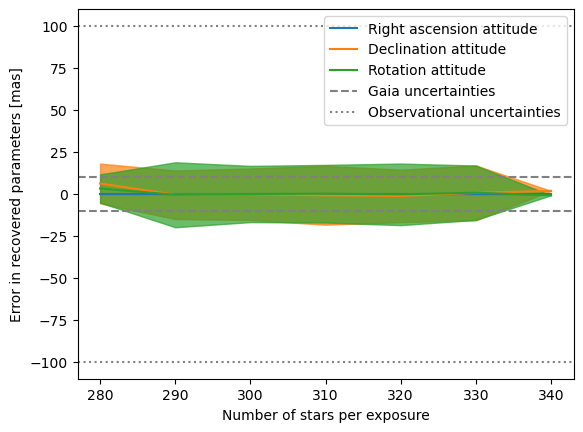

In [2064]:
#plt.scatter(result_df["num_exp"],(result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,s=1,alpha=0.5)
#plt.scatter(result_df["num_exp"],(result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,s=1,alpha=0.5)

plt.plot(xbins[:-1],mean_error_alfa_att,label="Right ascension attitude")
plt.plot(xbins[:-1],mean_error_delta_att,label="Declination attitude")
plt.plot(xbins[:-1],mean_error_rot_att,label="Rotation attitude")

plt.fill_between(xbins[:-1],mean_error_alfa_att-3*std_error_alfa_att,
                 mean_error_alfa_att+3*std_error_alfa_att,alpha=0.7,color="tab:blue")
plt.fill_between(xbins[:-1],mean_error_delta_att-3*std_error_delta_att,
                 mean_error_delta_att+3*std_error_delta_att,alpha=0.7,color="tab:orange")
plt.fill_between(xbins[:-1],mean_error_rot_att-3*std_error_rot_att,
                 mean_error_rot_att+3*std_error_rot_att,alpha=0.7,color="tab:green")

plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(-priors_uncertainty*_radiants_to_mas,ls="--",color="grey")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.axhline(-sig_obs*_radiants_to_mas,ls=":",color="grey")

plt.legend()

plt.xlabel("Number of stars per exposure")
plt.ylabel("Error in recovered parameters [mas]");

In [2191]:
scipy.stats.describe((result_exp_df["alfa0_est"] - result_exp_df["alfa0"])*_radiants_to_mas)

DescribeResult(nobs=800, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)

In [2192]:
mean_error_alfa_att

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [2193]:
mean_error_delta_att

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  6.22616032, -0.49994497,
       -0.19989151, -0.79836503, -1.21330106,  0.63328585,  1.82291963,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

# Attitude + gnomonic projection in 1 step

In [2278]:
def _comrs2fprs(phi_c,lambda_c,pt_ra,pt_dec,pt_rot,F,time):
    """
    This function accounts for the astrometric attitude 
    at each exposure and consists of a rotation.

    Input:
        - phi_c: longitude in CoMRS (in radiant)
        - lambda_c: latitude in CoMRS (in radiant)
        - pt_ra: right ascension of the centre of the FoV (in radiant)
        - pt_dec: declination of the centre of the FoV (in radiant)
        - pt_rot: TOTAL rotation angle, counter-clockwise (in radiant)
        - F: scaling factor

    Output:
        - xf: cartesian distance in the Focal Plane along x-axis [units given by F]
        - yf: cartesian distance in the Focal Plane along y-axis [units given by F]
        
    From C2-TN-R0-20231212
    """
    #trigonometry
    cd = jnp.cos(pt_dec)
    sd = jnp.sin(pt_dec)
    cr = jnp.cos(pt_rot)
    sr = jnp.sin(pt_rot)
    cl = jnp.cos(lambda_c)
    sl = jnp.sin(lambda_c)
    cosr = sd*sl + cd*cl*np.cos(phi_c - pt_ra)
    #projected (gnomonic) angles
    zeta = (sl*cd-sd*cl*np.cos(phi_c-pt_ra))/cosr
    #eta = + (cd*np.sin(phi_c-pt_ra))/cosr
    eta = + (cl*np.sin(phi_c-pt_ra))/cosr

    #rotate and scale
    xf = F * (cr*eta + sr*zeta)
    yf = F * (cr*zeta - sr*eta)

    return xf,yf

## Test function

In [2070]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2279]:
def plot_func(ra_src,dec_src,pt_ra,pt_dec,pt_rot,F):
    xf,yf = _comrs2fprs(ra_src,dec_src,pt_ra,pt_dec,pt_rot,F,None)

    ragrid,decgrid = np.meshgrid(np.linspace(-np.pi/2,np.pi/2,200),np.linspace(-np.pi/2,np.pi/2,200))
    ragrid = ragrid.flatten()
    decgrid = decgrid.flatten()

    xfgrid,yfgrid = _comrs2fprs(ragrid,decgrid,pt_ra,pt_dec,pt_rot,F,None)
    fovmask = (np.abs(ragrid)<0.55/2)&(np.abs(decgrid)<0.55/2)
    plt.scatter(xfgrid,yfgrid,s=1,color="grey",rasterized=True)
    plt.scatter(xfgrid[fovmask],yfgrid[fovmask],s=1,color="tab:orange",rasterized=True)

    ra_aux = np.deg2rad(np.linspace(0,360,1000))
    for d_ in np.deg2rad(np.arange(-80,80,20)):
        xaux,yaux = _comrs2fprs(ra_aux,d_*np.ones_like(ra_aux),pt_ra,pt_dec,pt_rot,F,None)
        plt.scatter(xaux,yaux,color="tab:green",s=10,rasterized=True)

    dec_aux = np.deg2rad(np.linspace(-90,90,1000))
    for r_ in np.deg2rad(np.arange(-90,90,20)):
        xaux,yaux = _comrs2fprs(r_*np.ones_like(dec_aux),dec_aux,pt_ra,pt_dec,pt_rot,F,None)
        plt.scatter(xaux,yaux,color="tab:green",s=10,rasterized=True)
    
    plt.scatter(xf,yf)
    plt.axvline(0,ls="--",color="grey")
    plt.axhline(0,ls="--",color="grey")
    plt.xlim(-np.pi/3,np.pi/3)
    plt.ylim(-np.pi/3,np.pi/3)
    plt.xlabel(r"$X_F$")
    plt.ylabel(r"$Y_F$");

In [2280]:
interactive_plot = interactive(plot_func, 
                               ra_src=widgets.FloatSlider(value=0,min=-np.deg2rad(20),max=np.deg2rad(20),step=0.01),
                               dec_src=widgets.FloatSlider(value=0,min=-np.deg2rad(85),max=np.deg2rad(85),step=0.01),
                               pt_ra=widgets.FloatSlider(value=0,min=-np.deg2rad(20),max=np.deg2rad(20),step=0.01),
                               pt_dec=widgets.FloatSlider(value=0,min=-np.deg2rad(85),max=np.deg2rad(85),step=0.01),
                               pt_rot=widgets.FloatSlider(value=0,min=-np.pi/2,max=np.pi/2,step=0.01),
                               F=widgets.FloatSlider(value=1,min=0.1,max=2,step=0.1))
output = interactive_plot.children[-1]
output.layout.height = '900px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='ra_src', max=0.3490658503988659, min=-0.349065850398…

In [2258]:
dec_aux1 = np.linspace(-np.pi/4,np.pi/4,100)
ra_aux1 = np.pi/6*np.ones_like(dec_aux)

ra_aux2 = np.linspace(-np.pi/4,np.pi/4,100)
dec_aux2 = np.pi/3*np.ones_like(dec_aux)

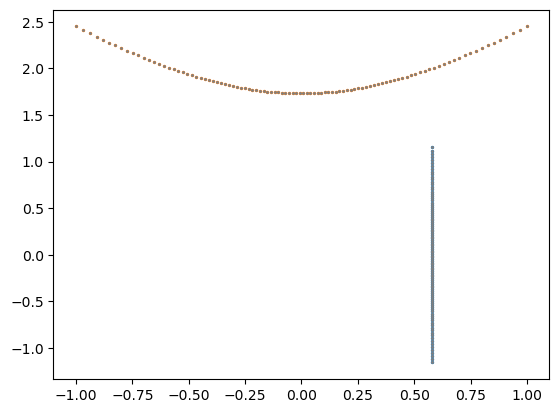

In [2259]:
xaux1,yaux1 = _comrs2fprs(ra_aux1,dec_aux1,0,0,0,1,None)

plt.scatter(np.tan(ra_aux1),np.tan(dec_aux1)/np.cos(ra_aux1),s=2)
plt.scatter(xaux1,-yaux1,s=1,color="grey")


xaux2,yaux2 = _comrs2fprs(ra_aux2,dec_aux2,0,0,0,1,None)

plt.scatter(np.tan(ra_aux2),np.tan(dec_aux2)/np.cos(ra_aux2),s=2)
plt.scatter(xaux2,-yaux2,s=1,color="grey")

In [2201]:
c = SkyCoord(ra = 0.2*units.radian,dec=0.1*units.radian)
c0 = SkyCoord(ra = 0*units.radian,dec=0*units.radian)

In [2202]:
c.separation(c0).to(units.radian)

<Angle 0.22330746 rad>

In [2203]:
np.arccos(np.cos(0.2)*np.cos(0.1))

0.22330745949001382

In [2204]:
eta = np.deg2rad(0)
zeta = np.deg2rad(-10)

print(np.rad2deg(np.arctan(np.tan(zeta)/np.sin(eta))))

-90.0


/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_39729/1069422316.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  print(np.rad2deg(np.arctan(np.tan(zeta)/np.sin(eta))))


In [2205]:
zeta = 0.49#0.18#0.363#np.deg2rad(36.3)
eta = 0.67#0.545#np.deg2rad(54.5)

In [2206]:
np.tan(zeta)

0.533388146637203

In [2207]:
np.sin(eta)

0.6209859870365597

In [2208]:
np.arccos(np.cos(eta)*np.cos(zeta))

0.8071060258307693

In [2209]:
np.tan(np.pi/6)

0.5773502691896256

In [2210]:
1/np.cos(np.pi/6)

1.1547005383792515

In [2231]:
zeta = np.deg2rad(71)
eta = np.deg2rad(32)
print(np.tan(eta),np.tan(zeta)/np.cos(eta))

0.6248693519093275 3.4245827457646083


In [2232]:
_comrs2fprs(eta,zeta,0,0,0,1,None)

(Array(1.91931964, dtype=float64), Array(-3.42458275, dtype=float64))

In [2221]:
_comrs2fprs(eta+0.2,zeta+0.2,0.2,0.2,0,1,None)

(Array(0.63837796, dtype=float64), Array(-0.67734759, dtype=float64))

In [2220]:
_comrs2fprs(0.4,0.4,0.4,0.4,0,1,None)

(Array(0., dtype=float64), Array(-0., dtype=float64))

In [2222]:
_comrs2fprs(0.4,0.6,0.4,0.4,0,1,None)

(Array(0., dtype=float64), Array(-0.20271004, dtype=float64))

In [2223]:
_comrs2fprs(0.4,0.2,0.4,0.0,0,1,None)

(Array(0., dtype=float64), Array(-0.20271004, dtype=float64))

In [2224]:
_comrs2fprs(0.6,0.4,0.4,0.4,0,1,None)

(Array(0.18613421, dtype=float64), Array(-0.00727267, dtype=float64))

In [2226]:
_comrs2fprs(0.2,0.4,0.0,0.4,0,1,None)

(Array(0.18613421, dtype=float64), Array(-0.00727267, dtype=float64))

In [2260]:
etagrid,zetagrid = np.meshgrid(np.linspace(-np.pi/4,np.pi/4,20),np.linspace(-np.pi/4,np.pi/4,20))
etagrid = etagrid.flatten()
zetagrid = zetagrid.flatten()

In [2283]:
x = np.tan(etagrid)
y = np.tan(zetagrid)/np.cos(etagrid)

x1,y1 = _comrs2fprs(etagrid,zetagrid,0,0,0,1,None)

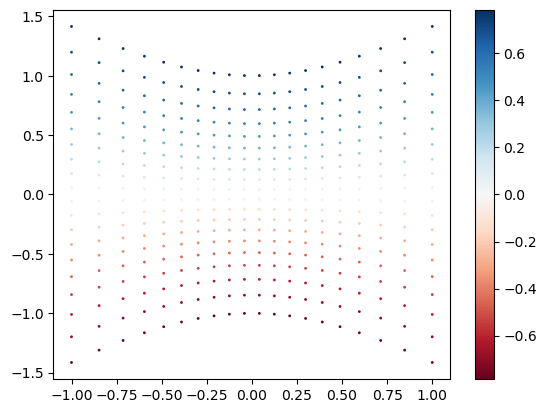

In [2282]:
plt.scatter(x,y,s=1,c=zetagrid,cmap="RdBu")
plt.colorbar();

In [2284]:
scipy.stats.describe(x1-x)

DescribeResult(nobs=400, minmax=(-1.1102230246251565e-16, 1.1102230246251565e-16), mean=4.8572257327350596e-18, variance=2.4221344513621928e-33, skewness=-0.16868360803241475, kurtosis=1.4038160509769453)

In [2285]:
scipy.stats.describe(y1-y)

DescribeResult(nobs=400, minmax=(-2.220446049250313e-16, 2.220446049250313e-16), mean=8.326672684688674e-18, variance=3.0052230159786796e-33, skewness=-0.15100682356405756, kurtosis=6.80870124961187)

## Compare two steps vs one step

In [4]:
from propagation import _comrs2fovrs,_fovrs2fprs,_comrs2fprs

In [5]:
ragrid,decgrid = np.meshgrid(np.linspace(-np.pi/3,np.pi/3,200),np.linspace(-np.pi/3,np.pi/3,200))
ragrid = ragrid.flatten()
decgrid = decgrid.flatten()

In [6]:
pt_ra = np.pi/6
pt_dec = np.pi/6
pt_rot = np.pi/4
F = 1

#2steps
eta,zeta = _comrs2fovrs(ragrid,decgrid,pt_ra,pt_dec,pt_rot)
xf2,yf2 = _fovrs2fprs(eta,zeta,F)
#1step
xf1,yf1 = _comrs2fprs(ragrid,decgrid,pt_ra,pt_dec,pt_rot,F)

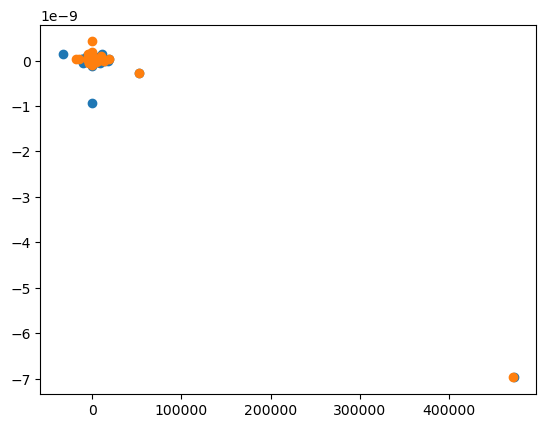

In [7]:
plt.scatter(xf1,(xf2-xf1)/xf1*100)
plt.scatter(yf1,(yf2-yf1)/yf1*100)

In [8]:
scipy.stats.describe(xf1-xf2)

DescribeResult(nobs=40000, minmax=(-1.549233275000006e-08, 3.2953626941889524e-05), mean=8.283173805044268e-10, variance=2.7149080430923667e-14, skewness=199.9864422630319, kurtosis=39993.38065692104)

In [9]:
scipy.stats.describe(xf1)

DescribeResult(nobs=40000, minmax=(-33039.26379891832, 472382.84344513784), mean=12.3389932773159, variance=5725935.371827389, skewness=192.53827058248524, kurtosis=37970.2899566081)

In [10]:
gc = SkyCoord(ra="17h 45m 40.0409s", dec="−29° 0′ 28.118″")

In [11]:
gc

<SkyCoord (ICRS): (ra, dec) in deg
    (266.41683708, -29.00781056)>

In [12]:
gc_ra = gc.ra.value
gc_dec = gc.dec.value

In [13]:
ragrid,decgrid = np.meshgrid(np.deg2rad(gc_ra) + np.linspace(-np.pi/12,np.pi/12,200),
                             np.deg2rad(gc_dec) + np.linspace(-np.pi/12,np.pi/12,200))
ragrid = ragrid.flatten()
decgrid = decgrid.flatten()

In [14]:
pt_ra = np.deg2rad(gc_ra)
pt_dec = np.deg2rad(gc_dec)
pt_rot = 54.95
F = 1

#2steps
eta,zeta = _comrs2fovrs(ragrid,decgrid,pt_ra,pt_dec,pt_rot)
xf2,yf2 = _fovrs2fprs(eta,zeta,F)
#1step
xf1,yf1 = _comrs2fprs(ragrid,decgrid,pt_ra,pt_dec,pt_rot,F)

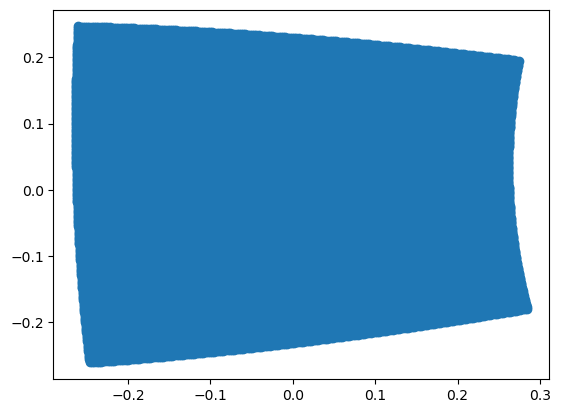

In [15]:
plt.scatter(eta,zeta)

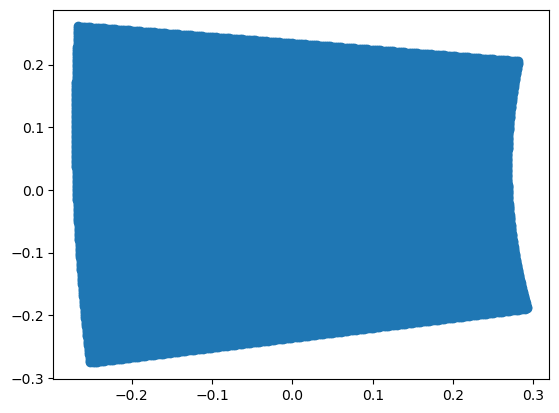

In [16]:
plt.scatter(xf2,yf2)

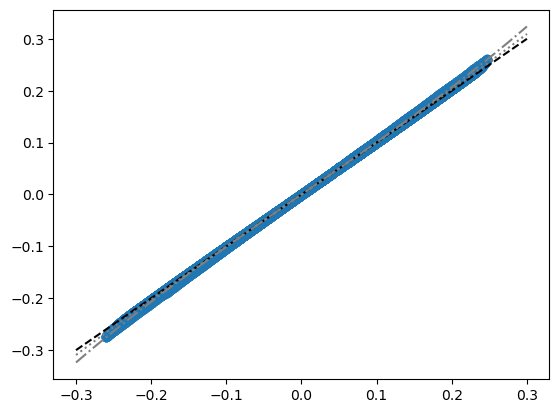

In [17]:
#plt.scatter(eta,xf2)
plt.plot(np.linspace(-0.3,0.3,2),np.linspace(-0.3,0.3,2),ls="--",color="k");
#plt.plot(np.linspace(-0.3,0.3,100),np.tan(np.linspace(-0.3,0.3,100)),ls="-",color="grey");

plt.scatter(zeta,yf2)
plt.plot(np.linspace(-0.3,0.3,100),np.tan(np.linspace(-0.3,0.3,100)),ls=":",color="grey");
plt.plot(np.linspace(-0.3,0.3,100),np.tan(np.linspace(-0.3,0.3,100))/np.cos(np.linspace(-0.3,0.3,100)),
         ls="-.",color="grey");


In [18]:
scipy.stats.describe(xf2-xf1)

DescribeResult(nobs=40000, minmax=(-2.7755575615628914e-16, 2.220446049250313e-16), mean=-3.473139846197054e-18, variance=2.7276602321371528e-33, skewness=-0.06686372081890554, kurtosis=0.3753408892849843)

In [19]:
scipy.stats.describe(yf2-yf1)

DescribeResult(nobs=40000, minmax=(-1.6653345369377348e-16, 1.6653345369377348e-16), mean=-5.793153665485044e-18, variance=7.312559054043914e-34, skewness=-0.014679645543850761, kurtosis=2.288975238234065)

In [20]:
len(ragrid)

40000

In [21]:
%%timeit
#2steps
eta,zeta = _comrs2fovrs(ragrid,decgrid,pt_ra,pt_dec,pt_rot)
xf2,yf2 = _fovrs2fprs(eta,zeta,F)

1.69 ms ± 12 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit
#1step
xf1,yf1 = _comrs2fprs(ragrid,decgrid,pt_ra,pt_dec,pt_rot,F)

592 μs ± 12.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Model

In [26]:
def forwardmodelling(src,exp,time):
    return jnp.asarray(_comrs2fprs(src[0],src[1],exp[0],exp[1],exp[2],exp[3]))

In [27]:
xy_fprs = jax.jit(lambda s,e,t: forwardmodelling(s,e,t))

## Generate true values

In [202]:
pkey = jax.random.PRNGKey(42)
alpha00 = 266.4
delta00 = -28.9
pt_ra0 = 266.40498829
pt_dec0 = -28.93617776
pt_rot0 = 58.61
F0 = 0.69

source_id = jnp.arange(200)
alpha0 = np.deg2rad(alpha00+np.random.uniform(-5.0, 5.0, size=source_id.shape))
delta0 = np.deg2rad(delta00+np.random.uniform(-5.0, 5.0, size=source_id.shape))

exposure_id = jnp.arange(500)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(pt_ra0 + np.random.uniform(-1, 1, size=exposure_id.shape))
pt_dec = np.deg2rad(pt_dec0+ np.random.uniform(-1, 1, size=exposure_id.shape))
pt_rot = np.deg2rad(pt_rot0 + np.random.uniform(-2,2, size=exposure_id.shape))
F = F0*np.random.uniform(0.9,1.1, size=exposure_id.shape)

src = jnp.stack([source_id, alpha0, delta0]).T
exp = jnp.stack([exposure_id, ep, pt_ra,pt_dec,pt_rot,F]).T

In [203]:
shat = jnp.hstack([src[:, 0:1], src[:, 1:] * np.random.normal(1.0, 0.1, size=src[:, 1:].shape)])
ehat = jnp.hstack([exp[:, 0:2], exp[:, 2:] * np.random.normal(1.0, 0.1, size=exp[:, 2:].shape)])

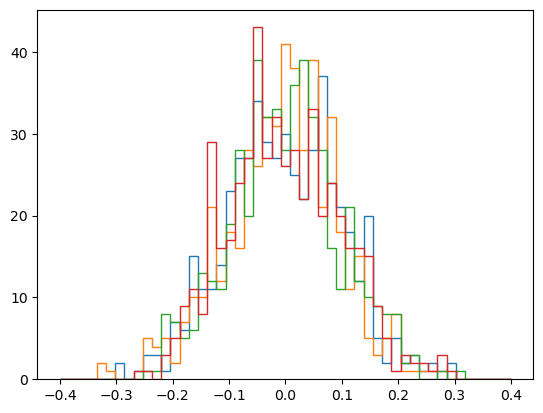

In [211]:
plt.hist((ehat[:,2]-exp[:,2])/exp[:,2],bins=np.linspace(-0.4,0.4,50),histtype="step");
plt.hist((ehat[:,3]-exp[:,3])/exp[:,3],bins=np.linspace(-0.4,0.4,50),histtype="step");
plt.hist((ehat[:,4]-exp[:,4])/exp[:,4],bins=np.linspace(-0.4,0.4,50),histtype="step");
plt.hist((ehat[:,5]-exp[:,5])/exp[:,5],bins=np.linspace(-0.4,0.4,50),histtype="step");

## Generate observations and priors

In [204]:
_iterate_src_xyfprs = jax.vmap(xy_fprs, (0, None, None), 0)
_iterate_exp_xyfprs = jax.vmap(xy_fprs, (None, 0, 0), 0)
_iterate_full_xyfprs = jax.vmap(_iterate_exp_xyfprs, (0, None,None), 0)
exposure_xyfprs = lambda s, e, t: np.hstack(np.vstack(_iterate_full_xyfprs(s, e, t)))


def estimate(src, exp, noise=0.00):
    ''' Generate the focal plane position from the parameters
    
    Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters
    
    Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
    '''
    obs = exposure_xyfprs(src[:, 1:], exp[:, 2:], exp[:, 1])
    if noise > 0:
        obs = np.random.normal(obs, noise)
    ids_ = np.array([[src[i,0].item(),exp[j,0].item(),k] for i in range(len(src)) for j in range(len(exp)) for k in [0,1]  ])
    return jnp.column_stack([ids_, obs])

sig_obs = 0.001/_radiants_to_mas
obs = estimate(src, exp, noise=sig_obs)
sig_obs_vec = np.ones(len(obs))*sig_obs

## priors are drawn from the true values with the aprox. posicion precision of Gaia 10yrs after the mission end (from 2019 to 2029)
priors_uncertainty = 10/_radiants_to_mas
priors = np.column_stack((src[:,0],[np.random.normal(src_[1:],priors_uncertainty) for src_ in src]))
sig_prior = np.column_stack((src[:,0],[[priors_uncertainty,priors_uncertainty]]*len(src)))

## Calculate gradients

In [135]:
Jds = jax.vmap(jax.jacrev(xy_fprs,argnums=(0)),(None,0,0))
Jde = jax.vmap(jax.jacrev(xy_fprs,argnums=(1)),(0,None,None))

In [136]:
def update_source_inner(src, exp,obs,sig_obs,priors,sig_prior):

    #search for the source of interest
    mask = obs[:, 0] == src[0]
    
    #check if priors are given:
    if priors is not None:
        if sig_prior is None:
            raise ValueError("If the priors are given, you need to provide also their uncertainties!")
        else:
            priors_ = priors[priors[:,0]==src[0]][0]
            sig_prior_ = sig_prior[sig_prior[:,0]==src[0]][0]
            
    c = np.hstack(_iterate_exp_xyfprs(src[1:], exp[:, 2:], exp[:, 1]))
    o = obs[mask][:, -1]
    
    Ds = jnp.vstack(Jds(src[1:],exp[:,2:],exp[:,1]))

    if priors is None:
        N = Ds.T @ Ds
        b = Ds.T @ (o - c)
    else:
        if isinstance(sig_obs,(float,int)):
            S = jnp.eye(len(o))*sig_obs**(-2)
        elif isinstance(sig_obs,np.ndarray):
            s = sig_obs[mask]
            S = jnp.diag(s**(-2))
        else:
            raise ValueError("The observational uncertainties have to be either a scalar or a numpy array")
        N = Ds.T @ S @ Ds + jnp.diag(sig_prior_[1:]**(-2))
        b = Ds.T @ S @ (o - c) + jnp.matmul(np.diag(sig_prior_[1:]**(-2)),(priors_[1:]-src[1:]))

    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return src[1:] + delta


def update_source(src, exp,obs,sig_obs,priors,sig_prior):
  ''' Updates of the source parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(_, exp,obs,sig_obs,priors,sig_prior) for _ in src])

In [137]:
def update_exposure_inner(src, exp,obs):
    c = np.hstack(_iterate_src_xyfprs(src[:,1:], exp[2:], exp[1]))
    o = obs[obs[:, 1] == exp[0]][:, -1]
    
    De = jnp.vstack(Jde(src[:,1:],exp[2:],exp[1]))
    
    N = De.T @ De
    b = De.T @ (o - c)
    
    cfac = jax.scipy.linalg.cho_factor(N)
    delta = jax.scipy.linalg.cho_solve(cfac, b)
    return exp[2:] + delta

def update_exposure(src, exp,obs):
  ''' Updates of the exposure parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(src, exp_,obs) for exp_ in exp])

In [138]:
update_source_inner(shat[0],ehat,obs,sig_obs_vec,priors,sig_prior)

Array([ 4.71517703, -0.60849525], dtype=float64)

In [266]:
np.rad2deg(4.7151)

270.15532998213445

In [267]:
np.rad2deg(4.7151*0.2)

54.03106599642689

## iterate

In [212]:
%%time
shats = [shat]
ehats = [ehat]


for n in range(3):
    print(n)
    for i in range(10):
        if n==0:
            aux = jnp.column_stack((exp[:,:2],update_exposure(priors,ehats[-1],obs)))
        else:
            aux = jnp.column_stack((exp[:,:2],update_exposure(shats[-1],ehats[-1],obs)))
        ehats.append(aux)
    
    for j in range(3):
        if n==0:
            aux = jnp.column_stack((src[:,:1],update_source(priors,ehats[-1],obs,1,None,None)))
        else:
            aux = jnp.column_stack((src[:,:1],update_source(shats[-1],ehats[-1],obs,1,None,None)))
        shats.append(aux)

0
1
2
CPU times: user 1min 23s, sys: 8.94 s, total: 1min 31s
Wall time: 1min 28s


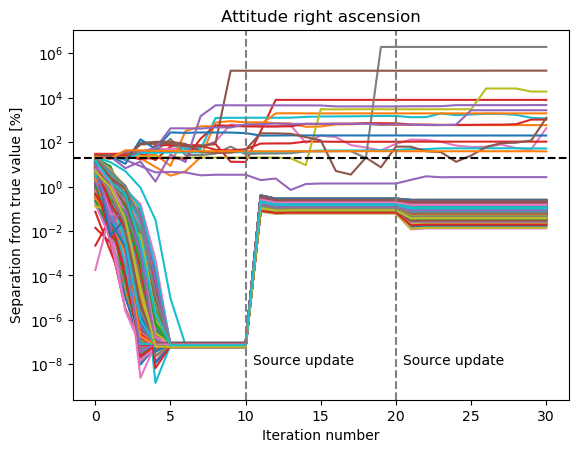

In [228]:
e_ = np.array(ehats)
aux = []
for i in range(e_.shape[1]):
    aux.append([i,np.abs(e_[9,i,2]-exp[i,2])*_radiants_to_mas])
    plt.plot(range(e_.shape[0]),np.abs(e_[:,i,2]-exp[i,2])/exp[i,2]*100)
aux = np.array(aux)
plt.axhline(20,ls="--",color="k");
plt.axvline(10,ls="--",color="grey");
plt.annotate("Source update",xy=(10.5,1e-8))
plt.axvline(20,ls="--",color="grey");
plt.annotate("Source update",xy=(20.5,1e-8))
plt.gca().set_yscale("log");
plt.xlabel("Iteration number")
plt.ylabel("Separation from true value [%]");
plt.title("Attitude right ascension");

In [240]:
ehats[-1][np.abs((ehats[-1][:,2]-exp[:,2])/exp[:,2])>0.01][:,2:4]

Array([[-3.69222294e+02,  5.70079652e+01],
       [-1.51799833e+01,  2.52960725e+01],
       [ 5.88527407e+01,  4.25334564e+01],
       [ 3.20561454e+01,  2.32811946e+00],
       [ 9.05264076e+04, -5.32410483e+04],
       [-2.87639966e-01,  6.55090067e+00],
       [-8.80421578e+01,  2.50545696e+01],
       [ 8.93941630e+02,  5.57063404e+02],
       [-7.74154857e+03, -6.87019505e+03],
       [-4.39228949e+01, -9.65158336e+00],
       [ 4.54164002e+00, -3.62185064e+00],
       [ 2.21911388e+00, -4.03901911e+00],
       [ 1.40012335e+01, -1.20751220e+01],
       [-1.22925752e+02, -9.78680801e+01],
       [ 2.23325811e+02, -1.83827860e+01],
       [ 6.27038759e+01,  5.21197396e+01],
       [ 6.46437940e+00, -4.91630191e-01]], dtype=float64)

In [241]:
exp[np.abs((ehats[-1][:,2]-exp[:,2])/exp[:,2])>0.01][:,2:4]

Array([[ 4.64168584, -0.48949221],
       [ 4.64525325, -0.51698954],
       [ 4.63244045, -0.48931593],
       [ 4.64786082, -0.50409489],
       [ 4.64344179, -0.4935136 ],
       [ 4.65223819, -0.48992662],
       [ 4.66271406, -0.49591976],
       [ 4.66646307, -0.50410809],
       [ 4.6442522 , -0.50774295],
       [ 4.64587613, -0.49122138],
       [ 4.66672899, -0.49312784],
       [ 4.65104548, -0.50513179],
       [ 4.65711653, -0.49688232],
       [ 4.63732337, -0.50183658],
       [ 4.64632492, -0.49637019],
       [ 4.6458575 , -0.50783759],
       [ 4.65525642, -0.48883683]], dtype=float64)

In [245]:
ehats[9][np.abs((ehats[0][:,2]-exp[:,2])/exp[:,2])<0.1][:,2:4]

Array([[ 4.64247818, -0.49502636],
       [ 4.64244799, -0.50344597],
       [ 4.64655257, -0.49009068],
       [ 4.66028235, -0.50136399],
       [ 4.64497297, -0.51895469],
       [ 4.66354715, -0.49777209],
       [ 4.65221027, -0.51467146],
       [ 4.64959251, -0.51133279],
       [ 4.6376023 , -0.50539628],
       [ 4.66399142, -0.50859189],
       [ 4.63833609, -0.51796722],
       [ 4.63669597, -0.51932208],
       [ 4.65189455, -0.52157086],
       [ 4.66037609, -0.4984943 ],
       [ 4.65090689, -0.51724343],
       [ 4.65739508, -0.49428614],
       [ 4.63944382, -0.52137676],
       [ 4.64555559, -0.49384652],
       [ 4.64716891, -0.50623979],
       [ 4.63866892, -0.49340421],
       [ 4.64544121, -0.52189743],
       [ 4.64217656, -0.51084186],
       [ 4.6510698 , -0.49185267],
       [ 4.65173192, -0.51292376],
       [ 4.63427952, -0.49817254],
       [ 4.65174271, -0.50277961],
       [ 4.6548441 , -0.49209189],
       [ 4.66225374, -0.51665831],
       [ 4.66185303,

In [246]:
exp[np.abs((ehats[0][:,2]-exp[:,2])/exp[:,2])<0.1][:,2:4]

Array([[ 4.64247819, -0.49502636],
       [ 4.64244799, -0.50344597],
       [ 4.64655258, -0.49009068],
       [ 4.66028235, -0.50136399],
       [ 4.64497298, -0.51895469],
       [ 4.66354715, -0.49777209],
       [ 4.65221027, -0.51467147],
       [ 4.64959251, -0.51133279],
       [ 4.6376023 , -0.50539628],
       [ 4.66399142, -0.5085919 ],
       [ 4.63833609, -0.51796722],
       [ 4.63669597, -0.51932209],
       [ 4.65189455, -0.52157086],
       [ 4.66037609, -0.4984943 ],
       [ 4.65090689, -0.51724343],
       [ 4.65739508, -0.49428614],
       [ 4.63944383, -0.52137676],
       [ 4.64555559, -0.49384652],
       [ 4.64716891, -0.5062398 ],
       [ 4.63866893, -0.49340421],
       [ 4.64544121, -0.52189743],
       [ 4.64217657, -0.51084186],
       [ 4.6510698 , -0.49185268],
       [ 4.65173192, -0.51292376],
       [ 4.63427952, -0.49817254],
       [ 4.65174271, -0.50277961],
       [ 4.65484411, -0.49209189],
       [ 4.66225375, -0.51665831],
       [ 4.66185304,

In [215]:
aux[aux[:,1]>10][:,0]

array([  3.,  36.,  89.,  91., 127., 133., 161., 178., 255., 263., 294.,
       349., 360., 444., 454., 455., 491.])

In [197]:
exp[55]

Array([55.        ,  1.66666667,  4.63773005, -0.50992914,  1.05491492,
        0.65537408], dtype=float64)

In [198]:
ehat[55]

Array([55.        ,  1.66666667,  3.51670686, -0.4811513 ,  1.11267391,
        0.66129179], dtype=float64)

In [220]:
((ehat[aux[:,1]>10]-exp[aux[:,1]>10])/exp[aux[:,1]>10])[:,2:]*100

Array([[ 30.07028393,   2.52072245,  -0.90401941,  -1.45155575],
       [ 28.62651144,  -3.8229515 ,  -3.54864838,  26.13549335],
       [-24.09314437,  -7.2409894 ,  -2.48983516,   6.06351618],
       [-28.85914487,   3.13527102,   7.32006682,  17.48336319],
       [-22.4981564 ,  13.72879793,  -1.93988648,  -0.58790217],
       [-28.6989214 ,  13.35343406,   4.35858161, -10.37960981],
       [-26.35678311, -10.87337184,   1.45440788,   9.02332135],
       [ 25.38062778,   0.69397135,  -8.18415294,  -4.66158823],
       [-24.41214855,  -0.64333706,   0.93956451,   3.4788628 ],
       [ 26.2497297 ,  -6.76661733, -15.16213461,  -0.88454288],
       [ 23.64108428,   2.71976013,  -3.88347013,   9.14050895],
       [-23.96768604,  -8.99906261,   5.59821453,  14.846108  ],
       [ 23.44048995,  -0.27813531,   6.66454575,   8.49453668],
       [ 22.5922815 ,   6.34464991,   8.68256232,   8.64720361],
       [-23.20465972,  -9.64300884,  10.82540022, -13.69304108],
       [ 24.00179799, -13

In [158]:
scipy.stats.describe((ehats[-1]-exp)*_radiants_to_mas)

DescribeResult(nobs=10, minmax=(array([  0.        ,   0.        ,  52.27683422, 281.0927192 ,
       -23.59707428,  47.92766038]), array([  0.        ,   0.        ,  59.00644053, 283.61635997,
       -12.97514999,  56.44991539])), mean=array([  0.        ,   0.        ,  55.25526449, 282.12749116,
       -19.04895252,  51.18865609]), variance=array([ 0.        ,  0.        ,  7.12182801,  1.07882492, 18.2625961 ,
        7.46009019]), skewness=array([       nan,        nan, 0.238391  , 0.47192141, 0.27075676,
       0.62013442]), kurtosis=array([        nan,         nan, -1.50181689, -1.54317895, -1.4723364 ,
       -0.59389528]))

In [159]:
scipy.stats.describe((shats[-1]-src)*_radiants_to_mas)

DescribeResult(nobs=200, minmax=(array([  0.        ,  32.34983128, 274.55257245]), array([  0.        ,  75.85809834, 288.91275415])), mean=array([  0.        ,  55.80818033, 282.16033061]), variance=array([  0.        , 150.4828184 ,  15.94031368]), skewness=array([        nan, -0.03707947, -0.01293324]), kurtosis=array([        nan, -1.1697018 , -1.33591872]))

In [186]:
exp_means = np.array([np.mean(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_means = np.array([np.mean(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

exp_std = np.array([np.std(ehat_[:,2:]-exp[:,2:],axis=0)*_radiants_to_mas for ehat_ in ehats])

src_std = np.array([np.std(shat_[:,1:]-src[:,1:],axis=0)*_radiants_to_mas for shat_ in shats])

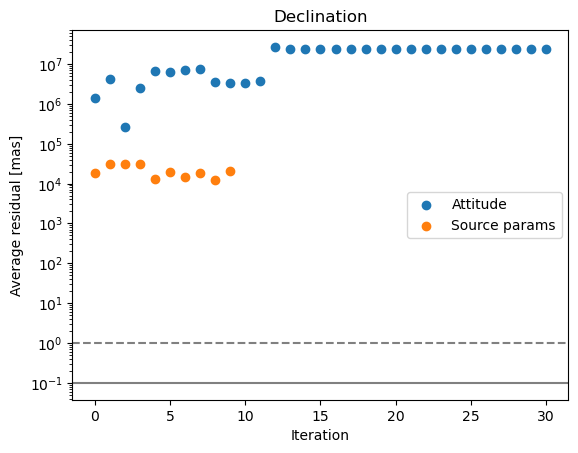

In [187]:
j = 1
plt.scatter(range(len(exp_means)),np.abs(exp_means[:,j]),label="Attitude")
plt.scatter(range(len(src_means)),np.abs(src_means[:,j]),label="Source params")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.axhline(1,ls="--",color="grey")
plt.axhline(0.1,ls="-",color="grey")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Average residual [mas]");

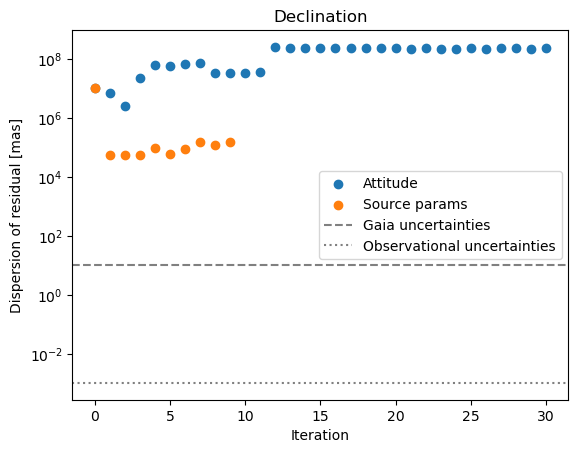

In [188]:
j = 1
plt.scatter(range(len(exp_means)),exp_std[:,j],label="Attitude")
plt.scatter(range(len(src_means)),src_std[:,j],label="Source params")
plt.axhline(priors_uncertainty*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties")
plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
plt.legend();
plt.title(f"{['Right ascension','Declination'][j]}")
plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Dispersion of residual [mas]");

# Other tests

In [251]:
def At(ra,dec,rot):
    return np.array([   [ np.cos(ra)*np.cos(dec), np.sin(ra)*np.cos(dec) , np.sin(dec)],
                        [ -np.cos(ra)*np.sin(dec)*np.sin(rot) - np.sin(ra)*np.cos(rot), 
                            np.cos(ra)*np.cos(rot) - np.sin(ra)*np.sin(dec)*np.sin(rot) , np.cos(dec)*np.sin(rot) ],
                        [ np.sin(ra)*np.sin(rot) - np.cos(ra)*np.sin(dec)*np.cos(rot),
                             -np.sin(ra)*np.sin(dec)*np.cos(rot) - np.cos(ra)*np.sin(rot), np.cos(dec)*np.cos(rot) ]])

In [253]:
At(np.deg2rad(266.40498829),np.deg2rad(-28.93617776),np.deg2rad(58.61))

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49393773, -0.44486891,  0.7470724 ],
       [-0.8677639 , -0.19798831,  0.45583599]])

In [249]:
def rot(pt_ra,pt_dec,pt_rot):
    ca = np.cos(pt_ra)
    sa = np.sin(pt_ra)
    cd = np.cos(-pt_dec)
    sd = np.sin(-pt_dec)
    cr = np.cos(pt_rot)
    sr = np.sin(pt_rot)
    return np.array([[ca*cd,sa*cd,-sd],
                 [-sa*cr+ca*sd*sr,ca*cr+sa*sd*sr,cd*sr],
                 [sa*sr+ca*sd*cr,-ca*sr+sa*sd*cr,cd*cr]])

In [254]:
rot(np.deg2rad(266.40498829),np.deg2rad(-28.93617776),np.deg2rad(58.61))

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49393773, -0.44486891,  0.7470724 ],
       [-0.8677639 , -0.19798831,  0.45583599]])

In [264]:
ra = -0.3
dec = 1.1

aux = At(np.deg2rad(266.40498829),np.deg2rad(-28.93617776),np.deg2rad(58.61))@np.array([[np.cos(ra)*np.cos(dec)],
                                                                                    [np.sin(ra)*np.cos(dec)],
                                                                                  [np.sin(dec)]])

l = np.rad2deg(np.arctan2(aux[1],aux[0])[0])
b = np.rad2deg(np.arcsin(aux[2])[0])

print(l,b)
print(360+l,b)

109.78191933469925 3.2532806003988024
469.78191933469924 3.2532806003988024


In [265]:
c = SkyCoord(ra=ra*units.radian,dec = dec*units.radian)
print(c.transform_to(Galactic))

<SkyCoord (Galactic): (l, b) in deg
    (109.78213781, 3.26394938)>


In [5]:
def foo(x):
  return jnp.asarray(
    [x[0], 5*x[2], 4*x[1]**2 - 2*x[2], x[2] * jnp.sin(x[0])])

In [7]:
jac = jax.vmap(jax.jacrev(foo,argnums=(0)),0)

In [10]:
ans = jac(jnp.stack((jnp.array([1., 2., 3.]),jnp.array([1., 2., 3.]))))

In [11]:
ans[0]

Array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.        ],
       [ 0.        , 16.        , -2.        ],
       [ 1.62090692,  0.        ,  0.84147098]], dtype=float64)